Processando evento 0
Analisando evento 0
#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
Processando evento 1000
Analis

/home/levi/miniconda3/lib/python3.12/site-packages/mplhep/utils.py:198: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/home/levi/miniconda3/lib/python3.12/site-packages/mplhep/utils.py:198: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/home/levi/miniconda3/lib/python3.12/site-packages/mplhep/utils.py:198: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/home/levi/miniconda3/lib/python3.12/site-packages/mplhep/utils.py:198: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


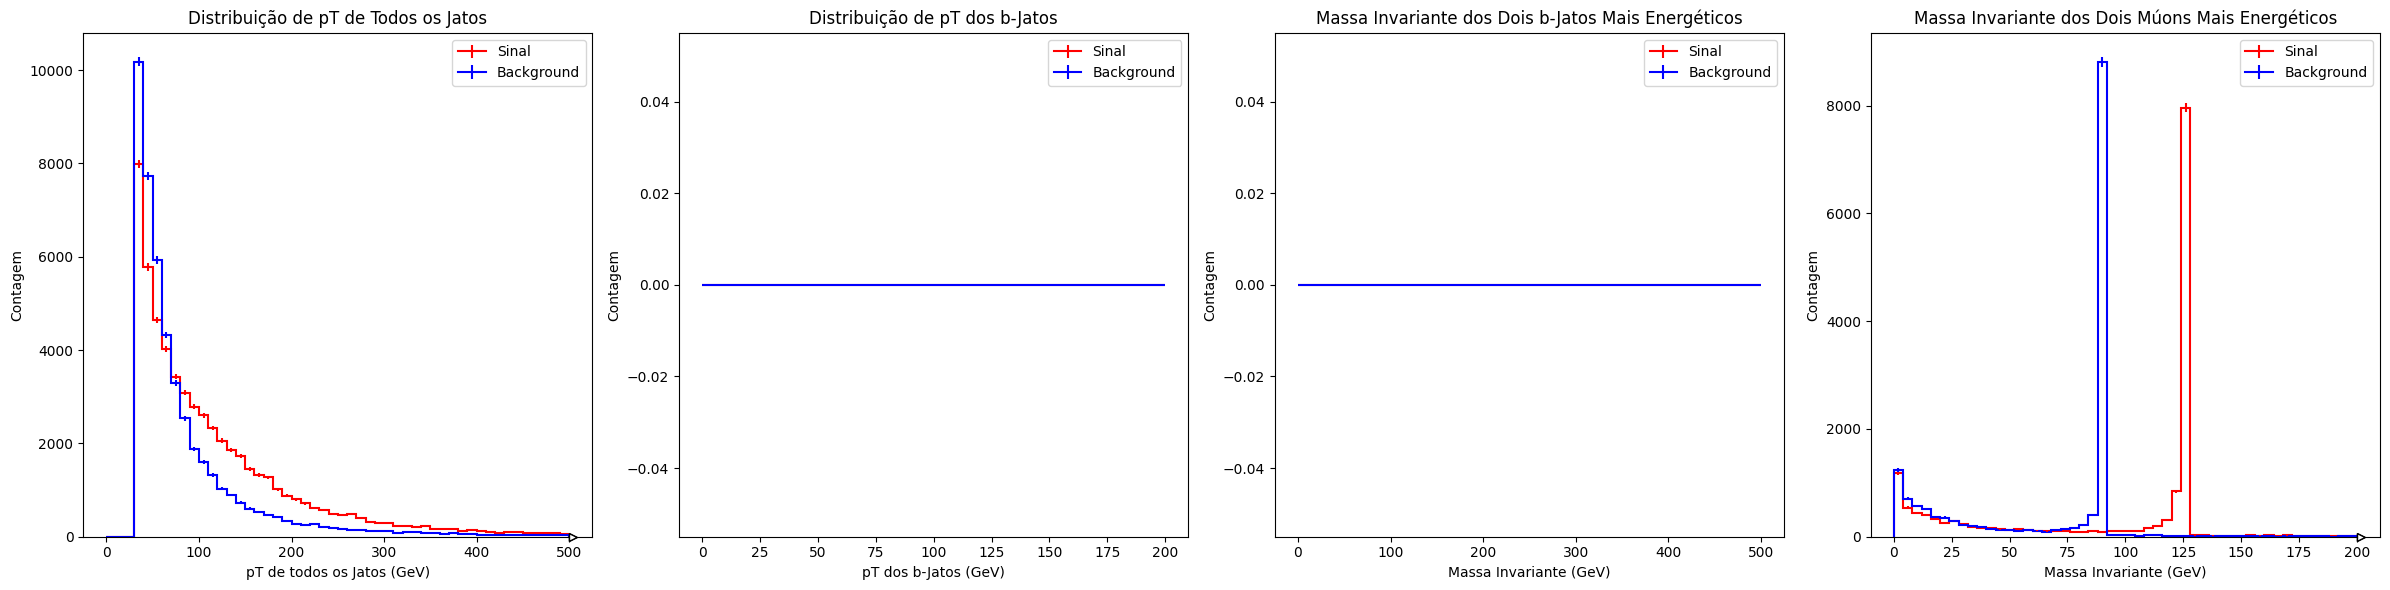

In [3]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background_file = '/home/levi/Documentos/Sinal_background/pp_zz_background_nobornQCD.hepmc'

# Limite máximo de eventos para evitar sobrecarga
max_events = 10000

# Definir histogramas
histo_jets_pt_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_pt_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_pt_sinal = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt_bg = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_muons_mass_sinal = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_muons_mass_bg = hist.Hist.new.Reg(50, 0., 200.).Double()

# Função para ler eventos HEPMC
def read_hepmc_file(hepmc_file):
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            if i % 1000 == 0:
                print(f"Processando evento {i}")
            yield event

# Função para calcular a massa invariante
def invariant_mass(p1, p2):
    E_tot = p1.e + p2.e
    px_tot = p1.px + p2.px
    py_tot = p1.py + p2.py
    pz_tot = p1.pz + p2.pz
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para processar eventos e preencher histogramas
def analyze_events(events, histo_all_jets, histo_bjets_pt, histo_mass, histo_muons_mass):
    for i, event in enumerate(events):
        if i % 1000 == 0:
            print(f"Analisando evento {i}")
        
        particles = [p for p in event.particles if p.status == 1]
        
        # Encontrar múons
        muons = [p for p in particles if abs(p.pid) == 13]
        muons_sorted_by_pt = sorted(muons, key=lambda p: p.momentum.pt(), reverse=True)
        
        # Selecionar os dois múons de maior pT com cargas opostas
        for i, muon1 in enumerate(muons_sorted_by_pt):
            for j, muon2 in enumerate(muons_sorted_by_pt):
                if i < j and np.sign(muon1.pid) != np.sign(muon2.pid):
                    mass = invariant_mass(muon1.momentum, muon2.momentum)
                    histo_muons_mass.fill(mass)
                    break
        
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles]
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        jets = clusterer.inclusive_jets(30.0)
        
        for jet in jets:
            histo_all_jets.fill(jet.pt())
        
        b_jets = [jet for jet in jets if any(abs(p.pid) == 5 for p in particles)]
        for jet in b_jets:
            histo_bjets_pt.fill(jet.pt())
        
        if len(b_jets) >= 2:
            b_jets = sorted(b_jets, key=lambda j: j.e(), reverse=True)[:2]
            histo_mass.fill(invariant_mass(b_jets[0], b_jets[1]))

# Ler e processar eventos
events_sinal = read_hepmc_file(sinal_file)
events_bg = read_hepmc_file(background_file)
analyze_events(events_sinal, histo_jets_pt_sinal, histo_bjets_pt_sinal, histo_bjets_mass_sinal, histo_muons_mass_sinal)
analyze_events(events_bg, histo_jets_pt_bg, histo_bjets_pt_bg, histo_bjets_mass_bg, histo_muons_mass_bg)

# Plotar histogramas
fig, ax = plt.subplots(1, 4, figsize=(24, 6))

# Histogramas de pT de todos os jatos
histo_jets_pt_sinal.plot(ax=ax[0], label='Sinal', color='red')
histo_jets_pt_bg.plot(ax=ax[0], label='Background', color='blue')
ax[0].set(xlabel='pT de todos os Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT de Todos os Jatos')
ax[0].legend()

# Histogramas de pT dos jatos b-tagging
histo_bjets_pt_sinal.plot(ax=ax[1], label='Sinal', color='red')
histo_bjets_pt_bg.plot(ax=ax[1], label='Background', color='blue')
ax[1].set(xlabel='pT dos b-Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT dos b-Jatos')
ax[1].legend()

# Histogramas da massa invariante dos dois b-jatos mais energéticos
histo_bjets_mass_sinal.plot(ax=ax[2], label='Sinal', color='red')
histo_bjets_mass_bg.plot(ax=ax[2], label='Background', color='blue')
ax[2].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois b-Jatos Mais Energéticos')
ax[2].legend()

# Histogramas da massa invariante dos dois múons mais energéticos com cargas opostas
histo_muons_mass_sinal.plot(ax=ax[3], label='Sinal', color='red')
histo_muons_mass_bg.plot(ax=ax[3], label='Background', color='blue')
ax[3].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois Múons Mais Energéticos')
ax[3].legend()

plt.tight_layout()
plt.show()


In [ ]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj

# Limite máximo de eventos para evitar sobrecarga
max_events = 10000

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background_file = '/home/levi/Documentos/Sinal_background/pp_zz_background_nobornQCD.hepmc'

# Definir histogramas
histo_jets_pt_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_pt_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_pt_sinal = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt_bg = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_muons_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_muons_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()

# Função para ler eventos HEPMC com limite de eventos
def read_hepmc_file(hepmc_file, max_events=max_events):
    events = []
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            events.append(event)
            if (i + 1) % 1000 == 0:  # Print a cada 1000 eventos
                print(f"Eventos lidos: {i + 1}")
    return events

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, particles, cone_radius=0.4):
    secondary_vertex_displacement = []
    for p in particles:
        if p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)
    if len(secondary_vertex_displacement) > 0:
        return np.mean(secondary_vertex_displacement) > 1.0
    return False

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para processar eventos e preencher histogramas de jatos
def analyze_events(events, histo_all_jets, histo_bjets_pt, histo_mass):
    for i, event in enumerate(events):
        particles = [p for p in event.particles if p.status == 1]
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles]
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        jets = clusterer.inclusive_jets(30.0)
        
        for jet in jets:
            histo_all_jets.fill(jet.pt())
        
        b_jets = [jet for jet in jets if is_b_tagged(jet, particles)]
        for jet in b_jets:
            histo_bjets_pt.fill(jet.pt())
        
        if len(b_jets) >= 2:
            b_jets = sorted(b_jets, key=lambda j: j.e(), reverse=True)[:2]
            histo_mass.fill(invariant_mass(b_jets[0], b_jets[1]))
        
        if (i + 1) % 1000 == 0:  # Print a cada 1000 eventos
            print(f"Eventos processados: {i + 1}")

# Função para identificar múons com cargas opostas e de mesmo sabor
def find_opposite_charge_muons(particles):
    muons = []
    for p in particles:
        if abs(p.pid) == 13:  # Múons têm PID ±13
            muons.append(p)
    
    # Selecionar pares de múons com cargas opostas
    muon_pairs = []
    for i in range(len(muons)):
        for j in range(i + 1, len(muons)):
            if muons[i].pid == -muons[j].pid:  # Cargas opostas
                muon_pairs.append((muons[i], muons[j]))
    
    return muon_pairs

# Função para processar eventos e preencher histograma de múons
def analyze_muons(events, histo_muons_mass):
    for i, event in enumerate(events):
        particles = [p for p in event.particles if p.status == 1]
        muon_pairs = find_opposite_charge_muons(particles)
        
        if len(muon_pairs) >= 1:
            # Selecionar o par de múons com maior soma de pT
            selected_pair = max(muon_pairs, key=lambda pair: pair[0].momentum.pt() + pair[1].momentum.pt())
            
            # Criar objetos PseudoJet para os múons
            muon1 = fj.PseudoJet(selected_pair[0].momentum.x, selected_pair[0].momentum.y, selected_pair[0].momentum.z, selected_pair[0].momentum.e)
            muon2 = fj.PseudoJet(selected_pair[1].momentum.x, selected_pair[1].momentum.y, selected_pair[1].momentum.z, selected_pair[1].momentum.e)
            
            # Calcular a massa invariante
            mass = invariant_mass(muon1, muon2)
            histo_muons_mass.fill(mass)
        
        if (i + 1) % 1000 == 0:  # Print a cada 1000 eventos
            print(f"Eventos processados: {i + 1}")

# Ler e processar eventos
print("Processando eventos de sinal...")
events_sinal = read_hepmc_file(sinal_file)
analyze_events(events_sinal, histo_jets_pt_sinal, histo_bjets_pt_sinal, histo_bjets_mass_sinal)
analyze_muons(events_sinal, histo_muons_mass_sinal)

print("\nProcessando eventos de background...")
events_bg = read_hepmc_file(background_file)
analyze_events(events_bg, histo_jets_pt_bg, histo_bjets_pt_bg, histo_bjets_mass_bg)
analyze_muons(events_bg, histo_muons_mass_bg)

# Plotar histogramas
fig, ax = plt.subplots(2, 2, figsize=(18, 12))

# Histogramas de pT de todos os jatos
histo_jets_pt_sinal.plot(ax=ax[0, 0], label='Sinal', color='red')
histo_jets_pt_bg.plot(ax=ax[0, 0], label='Background', color='blue')
ax[0, 0].set(xlabel='pT de todos os Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT de Todos os Jatos')
ax[0, 0].legend()

# Histogramas de pT dos jatos b-tagging
histo_bjets_pt_sinal.plot(ax=ax[0, 1], label='Sinal', color='red')
histo_bjets_pt_bg.plot(ax=ax[0, 1], label='Background', color='blue')
ax[0, 1].set(xlabel='pT dos b-Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT dos b-Jatos')
ax[0, 1].legend()

# Histogramas da massa invariante dos dois b-jatos mais energéticos
histo_bjets_mass_sinal.plot(ax=ax[1, 0], label='Sinal', color='red')
histo_bjets_mass_bg.plot(ax=ax[1, 0], label='Background', color='blue')
ax[1, 0].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois b-Jatos Mais Energéticos')
ax[1, 0].legend()

# Histograma da massa invariante dos dois múons de maior pT
histo_muons_mass_sinal.plot(ax=ax[1, 1], label='Sinal', color='red')
histo_muons_mass_bg.plot(ax=ax[1, 1], label='Background', color='blue')
ax[1, 1].set(xlabel='Massa Invariante dos Múons (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois Múons de Maior pT')
ax[1, 1].legend()

plt.tight_layout()
plt.show()


Processando eventos de sinal...
Eventos lidos: 1000
Eventos lidos: 2000


In [ ]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj
import psutil
import os
import gc

# Função para verificar o uso de memória
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Limite máximo de eventos para evitar sobrecarga
max_events = 10000  # Reduzido para teste

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background_file = '/home/levi/Documentos/Sinal_background/pp_zz_background_nobornQCD.hepmc'

# Definir histogramas
histo_jets_pt_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_pt_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_pt_sinal = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt_bg = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_muons_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_muons_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()

# Função para ler eventos HEPMC com limite de eventos
def read_hepmc_file(hepmc_file, max_events=max_events):
    events = []
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            events.append(event)
            if (i + 1) % 1000 == 0:
                print(f"Eventos lidos: {i + 1}")
                print_memory_usage()
                del event  # Liberar memória
                gc.collect()  # Forçar liberação de memória
    return events

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, particles, cone_radius=0.4):
    secondary_vertex_displacement = []
    for p in particles:
        if p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)
    if len(secondary_vertex_displacement) > 0:
        return np.mean(secondary_vertex_displacement) > 1.0
    return False

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para processar eventos e preencher histogramas de jatos
def analyze_events(events, histo_all_jets, histo_bjets_pt, histo_mass):
    for i, event in enumerate(events):
        particles = [p for p in event.particles if p.status == 1]
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles]
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        jets = clusterer.inclusive_jets(30.0)
        
        for jet in jets:
            histo_all_jets.fill(jet.pt())
        
        b_jets = [jet for jet in jets if is_b_tagged(jet, particles)]
        for jet in b_jets:
            histo_bjets_pt.fill(jet.pt())
        
        if len(b_jets) >= 2:
            b_jets = sorted(b_jets, key=lambda j: j.e(), reverse=True)[:2]
            histo_mass.fill(invariant_mass(b_jets[0], b_jets[1]))
        
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, fj_particles, jets, b_jets  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Função para identificar múons com cargas opostas e de mesmo sabor
def find_opposite_charge_muons(particles):
    muons = []
    for p in particles:
        if abs(p.pid) == 13:  # Múons têm PID ±13
            muons.append(p)
    
    # Selecionar pares de múons com cargas opostas
    muon_pairs = []
    for i in range(len(muons)):
        for j in range(i + 1, len(muons)):
            if muons[i].pid == -muons[j].pid:  # Cargas opostas
                muon_pairs.append((muons[i], muons[j]))
    
    return muon_pairs

# Função para processar eventos e preencher histograma de múons
def analyze_muons(events, histo_muons_mass):
    for i, event in enumerate(events):
        particles = [p for p in event.particles if p.status == 1]
        muon_pairs = find_opposite_charge_muons(particles)
        
        if len(muon_pairs) >= 1:
            # Selecionar o par de múons com maior soma de pT
            selected_pair = max(muon_pairs, key=lambda pair: pair[0].momentum.pt() + pair[1].momentum.pt())
            
            # Criar objetos PseudoJet para os múons
            muon1 = fj.PseudoJet(selected_pair[0].momentum.x, selected_pair[0].momentum.y, selected_pair[0].momentum.z, selected_pair[0].momentum.e)
            muon2 = fj.PseudoJet(selected_pair[1].momentum.x, selected_pair[1].momentum.y, selected_pair[1].momentum.z, selected_pair[1].momentum.e)
            
            # Calcular a massa invariante
            mass = invariant_mass(muon1, muon2)
            histo_muons_mass.fill(mass)
        
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, muon_pairs, selected_pair, muon1, muon2  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Ler e processar eventos
print("Processando eventos de sinal...")
events_sinal = read_hepmc_file(sinal_file)
analyze_events(events_sinal, histo_jets_pt_sinal, histo_bjets_pt_sinal, histo_bjets_mass_sinal)
analyze_muons(events_sinal, histo_muons_mass_sinal)

print("\nProcessando eventos de background...")
events_bg = read_hepmc_file(background_file)
analyze_events(events_bg, histo_jets_pt_bg, histo_bjets_pt_bg, histo_bjets_mass_bg)
analyze_muons(events_bg, histo_muons_mass_bg)

# Plotar histogramas
fig, ax = plt.subplots(2, 2, figsize=(18, 12))

# Histogramas de pT de todos os jatos
histo_jets_pt_sinal.plot(ax=ax[0, 0], label='Sinal', color='red')
histo_jets_pt_bg.plot(ax=ax[0, 0], label='Background', color='blue')
ax[0, 0].set(xlabel='pT de todos os Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT de Todos os Jatos')
ax[0, 0].legend()

# Histogramas de pT dos jatos b-tagging
histo_bjets_pt_sinal.plot(ax=ax[0, 1], label='Sinal', color='red')
histo_bjets_pt_bg.plot(ax=ax[0, 1], label='Background', color='blue')
ax[0, 1].set(xlabel='pT dos b-Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT dos b-Jatos')
ax[0, 1].legend()

# Histogramas da massa invariante dos dois b-jatos mais energéticos
histo_bjets_mass_sinal.plot(ax=ax[1, 0], label='Sinal', color='red')
histo_bjets_mass_bg.plot(ax=ax[1, 0], label='Background', color='blue')
ax[1, 0].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois b-Jatos Mais Energéticos')
ax[1, 0].legend()

# Histograma da massa invariante dos dois múons de maior pT
histo_muons_mass_sinal.plot(ax=ax[1, 1], label='Sinal', color='red')
histo_muons_mass_bg.plot(ax=ax[1, 1], label='Background', color='blue')
ax[1, 1].set(xlabel='Massa Invariante dos Múons (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois Múons de Maior pT')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

Processando eventos de sinal...


Processando eventos de sinal...
#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
Eventos processados: 1000
Uso de memóri

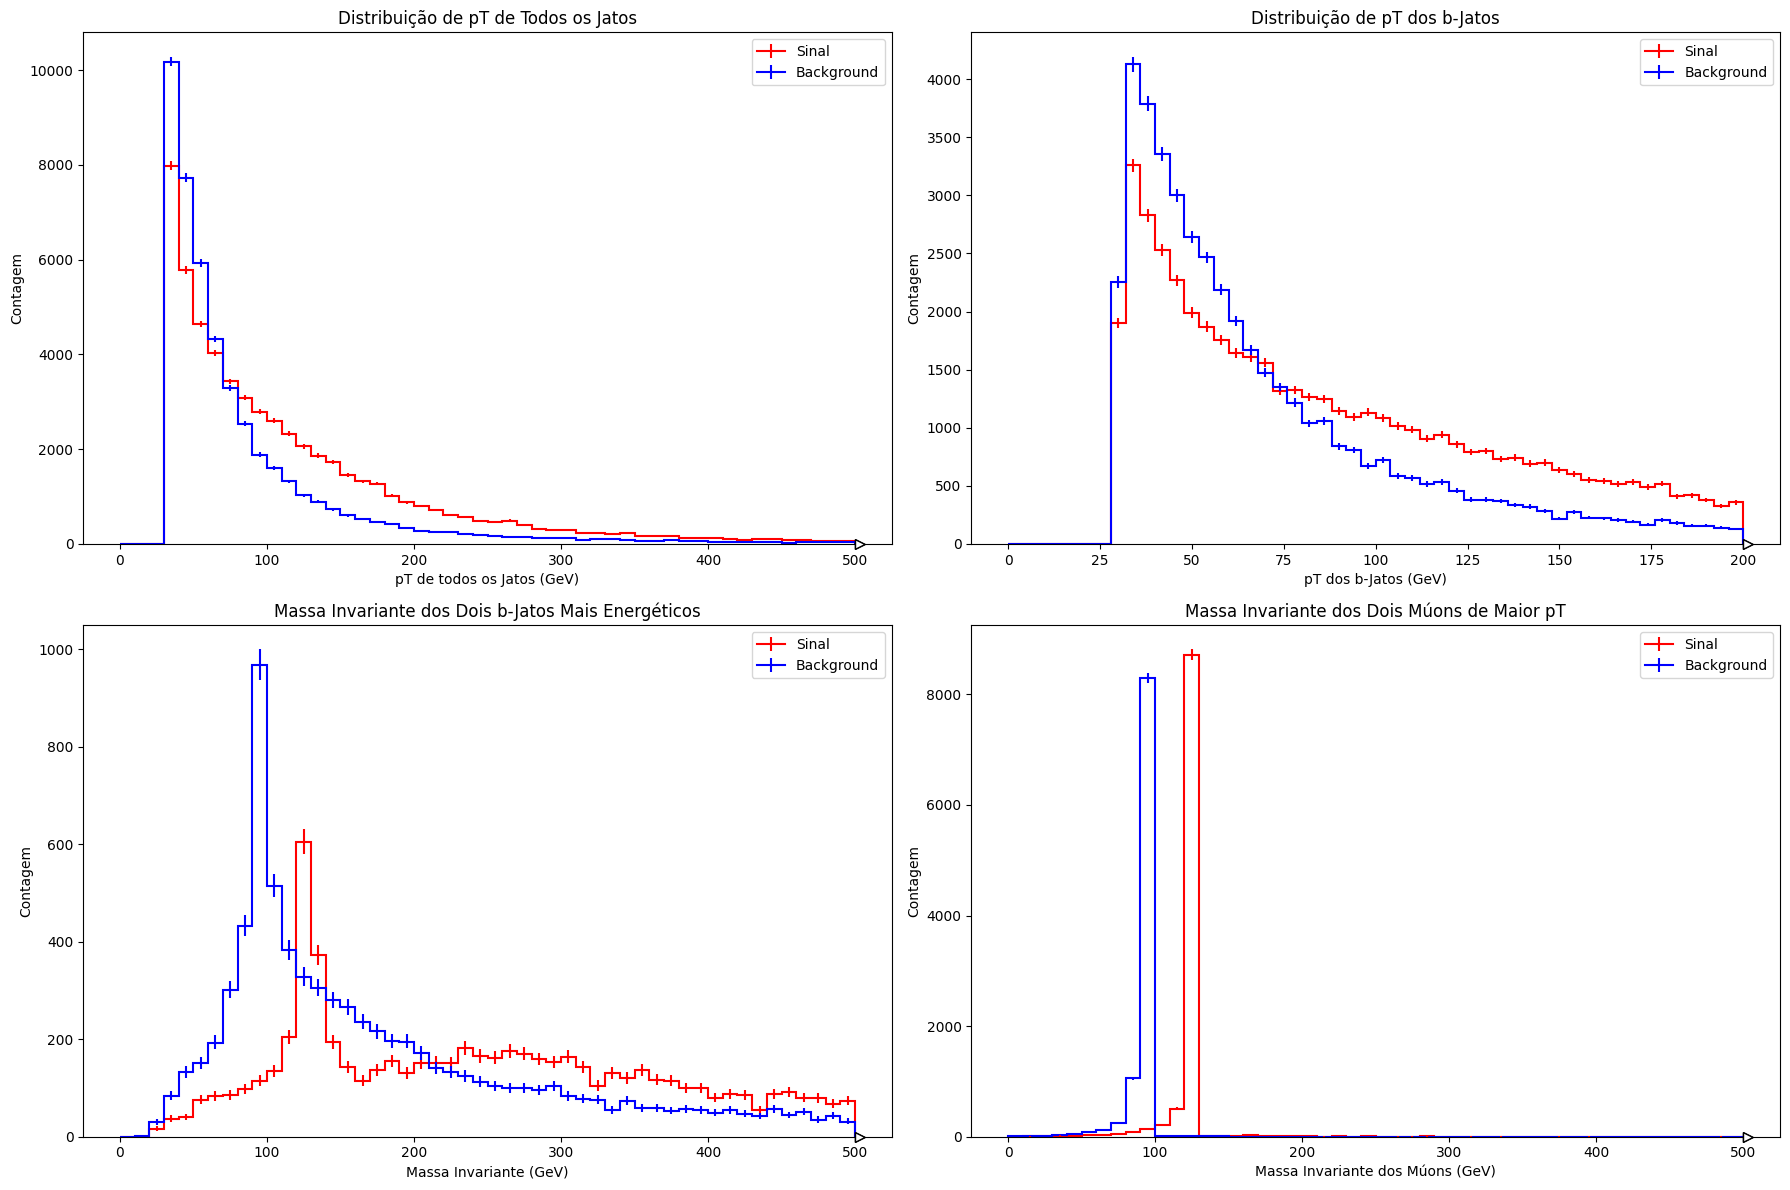

In [1]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj
import psutil
import os
import gc

# Função para verificar o uso de memória
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Limite máximo de eventos
max_events = 10000  # Total de eventos a serem processados
chunk_size = 1000   # Eventos por chunk

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background_file = '/home/levi/Documentos/Sinal_background/pp_zz_background_nobornQCD.hepmc'

# Definir histogramas
histo_jets_pt_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_pt_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_pt_sinal = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt_bg = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_muons_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_muons_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()

# Função para ler eventos HEPMC em chunks
def read_hepmc_file_in_chunks(hepmc_file, max_events=max_events, chunk_size=chunk_size):
    events = []
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            events.append(event)
            if (i + 1) % chunk_size == 0:  # Processar chunk
                yield events
                events = []  # Limpar lista de eventos
                print(f"Eventos lidos: {i + 1}")
                print_memory_usage()
                gc.collect()  # Forçar liberação de memória
        if events:  # Processar eventos restantes
            yield events

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, particles, cone_radius=0.4):
    secondary_vertex_displacement = []
    for p in particles:
        if p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)
    if len(secondary_vertex_displacement) > 0:
        return np.mean(secondary_vertex_displacement) > 1.0
    return False

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para processar eventos e preencher histogramas de jatos
def analyze_events(events, histo_all_jets, histo_bjets_pt, histo_mass):
    for i, event in enumerate(events):
        particles = [p for p in event.particles if p.status == 1]
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles]
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        jets = clusterer.inclusive_jets(30.0)
        
        for jet in jets:
            histo_all_jets.fill(jet.pt())
        
        b_jets = [jet for jet in jets if is_b_tagged(jet, particles)]
        for jet in b_jets:
            histo_bjets_pt.fill(jet.pt())
        
        if len(b_jets) >= 2:
            b_jets = sorted(b_jets, key=lambda j: j.e(), reverse=True)[:2]
            histo_mass.fill(invariant_mass(b_jets[0], b_jets[1]))
        
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, fj_particles, jets, b_jets  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Função para identificar múons com cargas opostas e de mesmo sabor
def find_opposite_charge_muons(particles):
    muons = []
    for p in particles:
        if abs(p.pid) == 13:  # Múons têm PID ±13
            muons.append(p)
    
    # Selecionar pares de múons com cargas opostas
    muon_pairs = []
    for i in range(len(muons)):
        for j in range(i + 1, len(muons)):
            if muons[i].pid == -muons[j].pid:  # Cargas opostas
                muon_pairs.append((muons[i], muons[j]))
    
    return muon_pairs

# Função para processar eventos e preencher histograma de múons
def analyze_muons(events, histo_muons_mass):
    for i, event in enumerate(events):
        particles = [p for p in event.particles if p.status == 1]
        muon_pairs = find_opposite_charge_muons(particles)
        
        if len(muon_pairs) >= 1:
            # Selecionar o par de múons com maior soma de pT
            selected_pair = max(muon_pairs, key=lambda pair: pair[0].momentum.pt() + pair[1].momentum.pt())
            
            # Criar objetos PseudoJet para os múons
            muon1 = fj.PseudoJet(selected_pair[0].momentum.x, selected_pair[0].momentum.y, selected_pair[0].momentum.z, selected_pair[0].momentum.e)
            muon2 = fj.PseudoJet(selected_pair[1].momentum.x, selected_pair[1].momentum.y, selected_pair[1].momentum.z, selected_pair[1].momentum.e)
            
            # Calcular a massa invariante
            mass = invariant_mass(muon1, muon2)
            histo_muons_mass.fill(mass)
        
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, muon_pairs, selected_pair, muon1, muon2  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Processar eventos de sinal em chunks
print("Processando eventos de sinal...")
for chunk in read_hepmc_file_in_chunks(sinal_file):
    analyze_events(chunk, histo_jets_pt_sinal, histo_bjets_pt_sinal, histo_bjets_mass_sinal)
    analyze_muons(chunk, histo_muons_mass_sinal)

# Processar eventos de background em chunks
print("\nProcessando eventos de background...")
for chunk in read_hepmc_file_in_chunks(background_file):
    analyze_events(chunk, histo_jets_pt_bg, histo_bjets_pt_bg, histo_bjets_mass_bg)
    analyze_muons(chunk, histo_muons_mass_bg)

# Plotar histogramas
fig, ax = plt.subplots(2, 2, figsize=(18, 12))

# Histogramas de pT de todos os jatos
histo_jets_pt_sinal.plot(ax=ax[0, 0], label='Sinal', color='red')
histo_jets_pt_bg.plot(ax=ax[0, 0], label='Background', color='blue')
ax[0, 0].set(xlabel='pT de todos os Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT de Todos os Jatos')
ax[0, 0].legend()

# Histogramas de pT dos jatos b-tagging
histo_bjets_pt_sinal.plot(ax=ax[0, 1], label='Sinal', color='red')
histo_bjets_pt_bg.plot(ax=ax[0, 1], label='Background', color='blue')
ax[0, 1].set(xlabel='pT dos b-Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT dos b-Jatos')
ax[0, 1].legend()

# Histogramas da massa invariante dos dois b-jatos mais energéticos
histo_bjets_mass_sinal.plot(ax=ax[1, 0], label='Sinal', color='red')
histo_bjets_mass_bg.plot(ax=ax[1, 0], label='Background', color='blue')
ax[1, 0].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois b-Jatos Mais Energéticos')
ax[1, 0].legend()

# Histograma da massa invariante dos dois múons de maior pT
histo_muons_mass_sinal.plot(ax=ax[1, 1], label='Sinal', color='red')
histo_muons_mass_bg.plot(ax=ax[1, 1], label='Background', color='blue')
ax[1, 1].set(xlabel='Massa Invariante dos Múons (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois Múons de Maior pT')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

Processando eventos de sinal...
Eventos processados: 1000
Uso de memória: 3335.88 MB
Eventos processados: 1000
Uso de memória: 3335.88 MB
Eventos lidos: 1000
Uso de memória: 3335.88 MB
Eventos processados: 1000
Uso de memória: 3323.11 MB
Eventos processados: 1000
Uso de memória: 3323.11 MB
Eventos lidos: 2000
Uso de memória: 3323.11 MB
Eventos processados: 1000
Uso de memória: 3322.54 MB
Eventos processados: 1000
Uso de memória: 3322.54 MB
Eventos lidos: 3000
Uso de memória: 3322.54 MB
Eventos processados: 1000
Uso de memória: 3322.54 MB
Eventos processados: 1000
Uso de memória: 3322.54 MB
Eventos lidos: 4000
Uso de memória: 3322.54 MB
Eventos processados: 1000
Uso de memória: 3322.54 MB
Eventos processados: 1000
Uso de memória: 3322.54 MB
Eventos lidos: 5000
Uso de memória: 3322.54 MB
Eventos processados: 1000
Uso de memória: 3322.54 MB
Eventos processados: 1000
Uso de memória: 3322.54 MB
Eventos lidos: 6000
Uso de memória: 3322.54 MB
Eventos processados: 1000
Uso de memória: 3335.68 

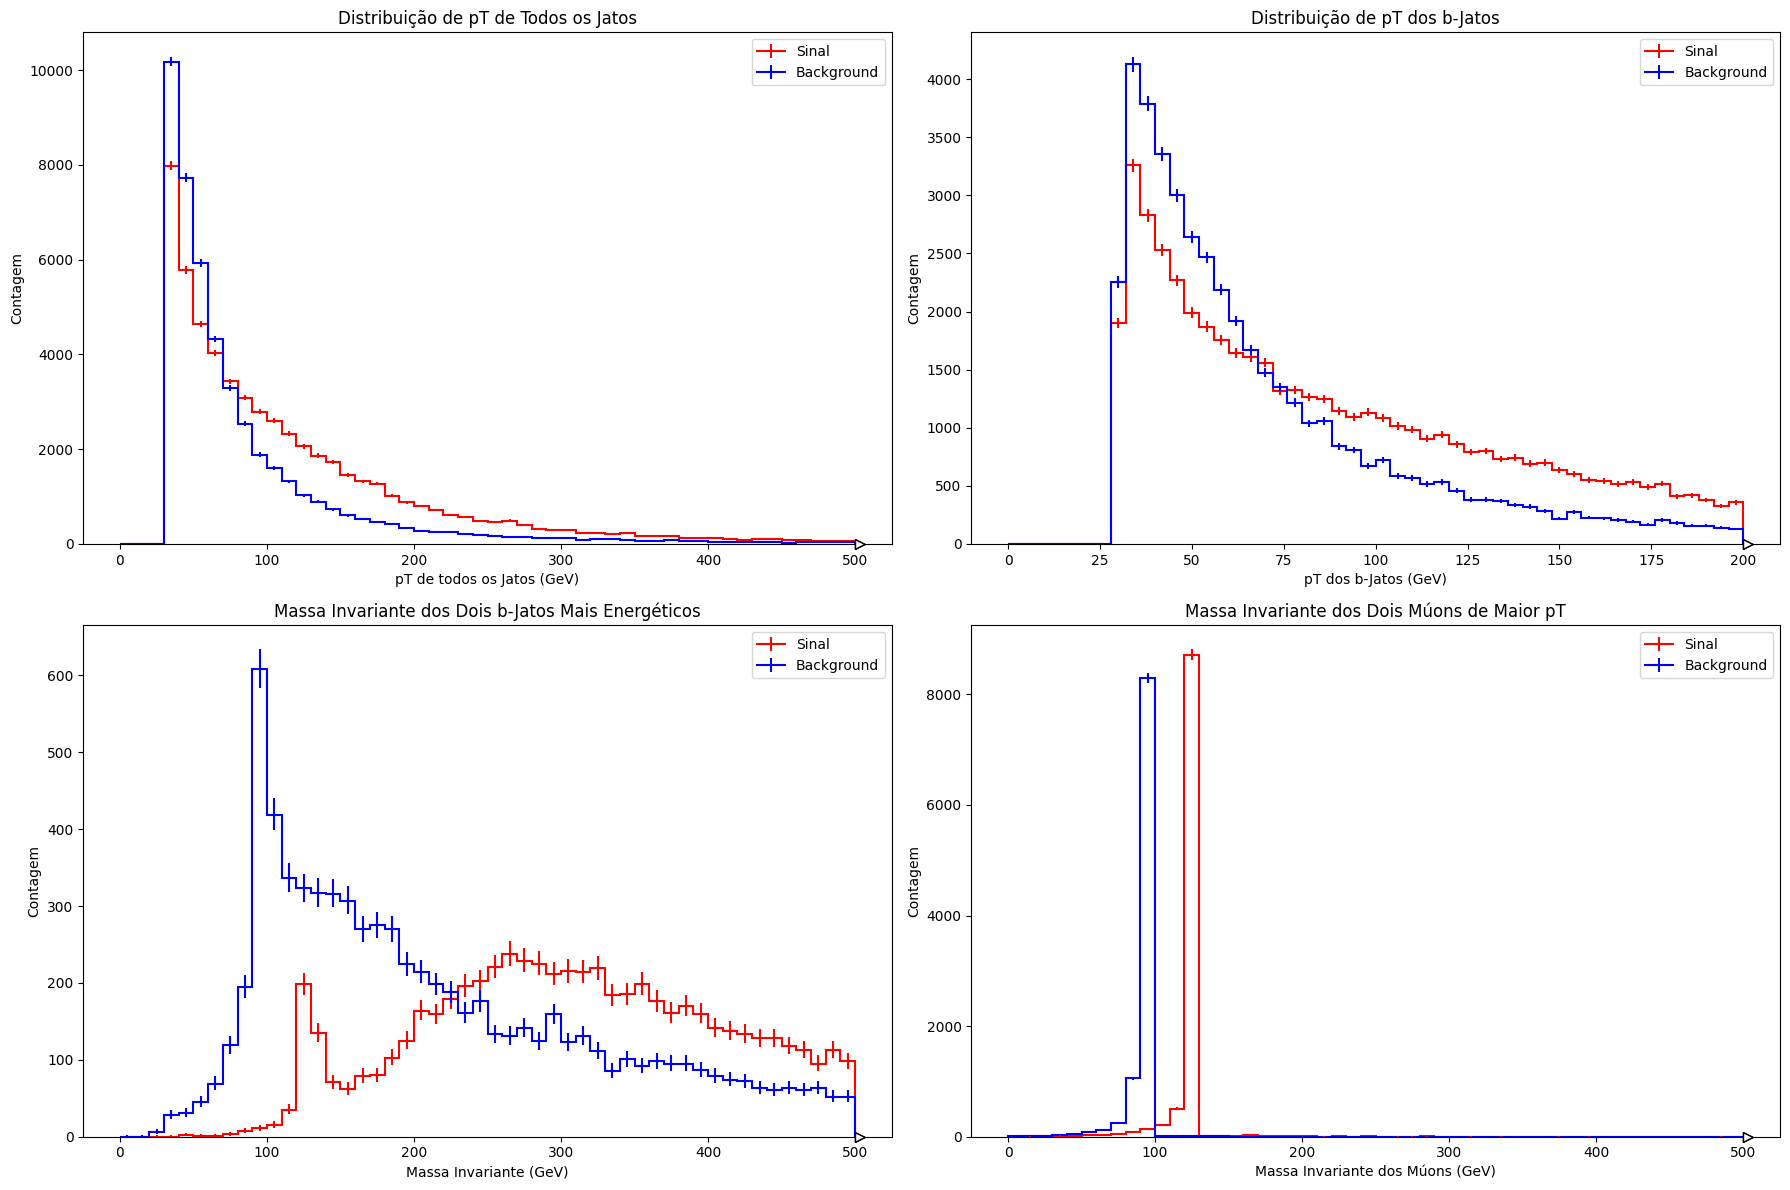

In [2]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj
import psutil
import os
import gc

# Função para verificar o uso de memória
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Limite máximo de eventos
max_events = 10000  # Total de eventos a serem processados
chunk_size = 1000   # Eventos por chunk

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background_file = '/home/levi/Documentos/Sinal_background/pp_zz_background_nobornQCD.hepmc'

# Definir histogramas
histo_jets_pt_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_pt_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_pt_sinal = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt_bg = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_muons_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_muons_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()

# Função para ler eventos HEPMC em chunks
def read_hepmc_file_in_chunks(hepmc_file, max_events=max_events, chunk_size=chunk_size):
    events = []
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            events.append(event)
            if (i + 1) % chunk_size == 0:  # Processar chunk
                yield events
                events = []  # Limpar lista de eventos
                print(f"Eventos lidos: {i + 1}")
                print_memory_usage()
                gc.collect()  # Forçar liberação de memória
        if events:  # Processar eventos restantes
            yield events

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, particles, cone_radius=0.4):
    secondary_vertex_displacement = []
    for p in particles:
        if p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)
    if len(secondary_vertex_displacement) > 0:
        return np.mean(secondary_vertex_displacement) > 1.0
    return False

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para processar eventos e preencher histogramas de jatos
def analyze_events(events, histo_all_jets, histo_bjets_pt, histo_mass):
    for i, event in enumerate(events):
        particles = [p for p in event.particles if p.status == 1]
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles]
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        jets = clusterer.inclusive_jets(30.0)
        
        for jet in jets:
            histo_all_jets.fill(jet.pt())
        
        b_jets = [jet for jet in jets if is_b_tagged(jet, particles)]
        for jet in b_jets:
            histo_bjets_pt.fill(jet.pt())
        
        if len(b_jets) >= 2:
            # Selecionar os dois jatos de maior pT
            b_jets = sorted(b_jets, key=lambda j: j.pt(), reverse=True)[:2]
            histo_mass.fill(invariant_mass(b_jets[0], b_jets[1]))
        
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, fj_particles, jets, b_jets  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Função para identificar múons com cargas opostas e de mesmo sabor
def find_opposite_charge_muons(particles):
    muons = []
    for p in particles:
        if abs(p.pid) == 13:  # Múons têm PID ±13
            muons.append(p)
    
    # Selecionar pares de múons com cargas opostas
    muon_pairs = []
    for i in range(len(muons)):
        for j in range(i + 1, len(muons)):
            if muons[i].pid == -muons[j].pid:  # Cargas opostas
                muon_pairs.append((muons[i], muons[j]))
    
    return muon_pairs

# Função para processar eventos e preencher histograma de múons
def analyze_muons(events, histo_muons_mass):
    for i, event in enumerate(events):
        particles = [p for p in event.particles if p.status == 1]
        muon_pairs = find_opposite_charge_muons(particles)
        
        if len(muon_pairs) >= 1:
            # Selecionar o par de múons com maior soma de pT
            selected_pair = max(muon_pairs, key=lambda pair: pair[0].momentum.pt() + pair[1].momentum.pt())
            
            # Criar objetos PseudoJet para os múons
            muon1 = fj.PseudoJet(selected_pair[0].momentum.x, selected_pair[0].momentum.y, selected_pair[0].momentum.z, selected_pair[0].momentum.e)
            muon2 = fj.PseudoJet(selected_pair[1].momentum.x, selected_pair[1].momentum.y, selected_pair[1].momentum.z, selected_pair[1].momentum.e)
            
            # Calcular a massa invariante
            mass = invariant_mass(muon1, muon2)
            histo_muons_mass.fill(mass)
        
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, muon_pairs, selected_pair, muon1, muon2  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Processar eventos de sinal em chunks
print("Processando eventos de sinal...")
for chunk in read_hepmc_file_in_chunks(sinal_file):
    analyze_events(chunk, histo_jets_pt_sinal, histo_bjets_pt_sinal, histo_bjets_mass_sinal)
    analyze_muons(chunk, histo_muons_mass_sinal)

# Processar eventos de background em chunks
print("\nProcessando eventos de background...")
for chunk in read_hepmc_file_in_chunks(background_file):
    analyze_events(chunk, histo_jets_pt_bg, histo_bjets_pt_bg, histo_bjets_mass_bg)
    analyze_muons(chunk, histo_muons_mass_bg)

# Plotar histogramas
fig, ax = plt.subplots(2, 2, figsize=(18, 12))

# Histogramas de pT de todos os jatos
histo_jets_pt_sinal.plot(ax=ax[0, 0], label='Sinal', color='red')
histo_jets_pt_bg.plot(ax=ax[0, 0], label='Background', color='blue')
ax[0, 0].set(xlabel='pT de todos os Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT de Todos os Jatos')
ax[0, 0].legend()

# Histogramas de pT dos jatos b-tagging
histo_bjets_pt_sinal.plot(ax=ax[0, 1], label='Sinal', color='red')
histo_bjets_pt_bg.plot(ax=ax[0, 1], label='Background', color='blue')
ax[0, 1].set(xlabel='pT dos b-Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT dos b-Jatos')
ax[0, 1].legend()

# Histogramas da massa invariante dos dois b-jatos mais energéticos
histo_bjets_mass_sinal.plot(ax=ax[1, 0], label='Sinal', color='red')
histo_bjets_mass_bg.plot(ax=ax[1, 0], label='Background', color='blue')
ax[1, 0].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois b-Jatos Mais Energéticos')
ax[1, 0].legend()

# Histograma da massa invariante dos dois múons de maior pT
histo_muons_mass_sinal.plot(ax=ax[1, 1], label='Sinal', color='red')
histo_muons_mass_bg.plot(ax=ax[1, 1], label='Background', color='blue')
ax[1, 1].set(xlabel='Massa Invariante dos Múons (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois Múons de Maior pT')
ax[1, 1].legend()

plt.tight_layout()
plt.show()


Processando eventos de sinal...
Eventos processados: 1000
Uso de memória: 3340.41 MB
Eventos processados: 1000
Uso de memória: 3340.41 MB
Eventos lidos: 1000
Uso de memória: 3340.41 MB
Eventos processados: 1000
Uso de memória: 3339.40 MB
Eventos processados: 1000
Uso de memória: 3339.40 MB
Eventos lidos: 2000
Uso de memória: 3339.40 MB
Eventos processados: 1000
Uso de memória: 3339.00 MB
Eventos processados: 1000
Uso de memória: 3339.00 MB
Eventos lidos: 3000
Uso de memória: 3339.00 MB
Eventos processados: 1000
Uso de memória: 3337.71 MB
Eventos processados: 1000
Uso de memória: 3337.71 MB
Eventos lidos: 4000
Uso de memória: 3337.71 MB
Eventos processados: 1000
Uso de memória: 3328.06 MB
Eventos processados: 1000
Uso de memória: 3328.06 MB
Eventos lidos: 5000
Uso de memória: 3328.06 MB
Eventos processados: 1000
Uso de memória: 3326.65 MB
Eventos processados: 1000
Uso de memória: 3326.65 MB
Eventos lidos: 6000
Uso de memória: 3326.65 MB
Eventos processados: 1000
Uso de memória: 3326.65 

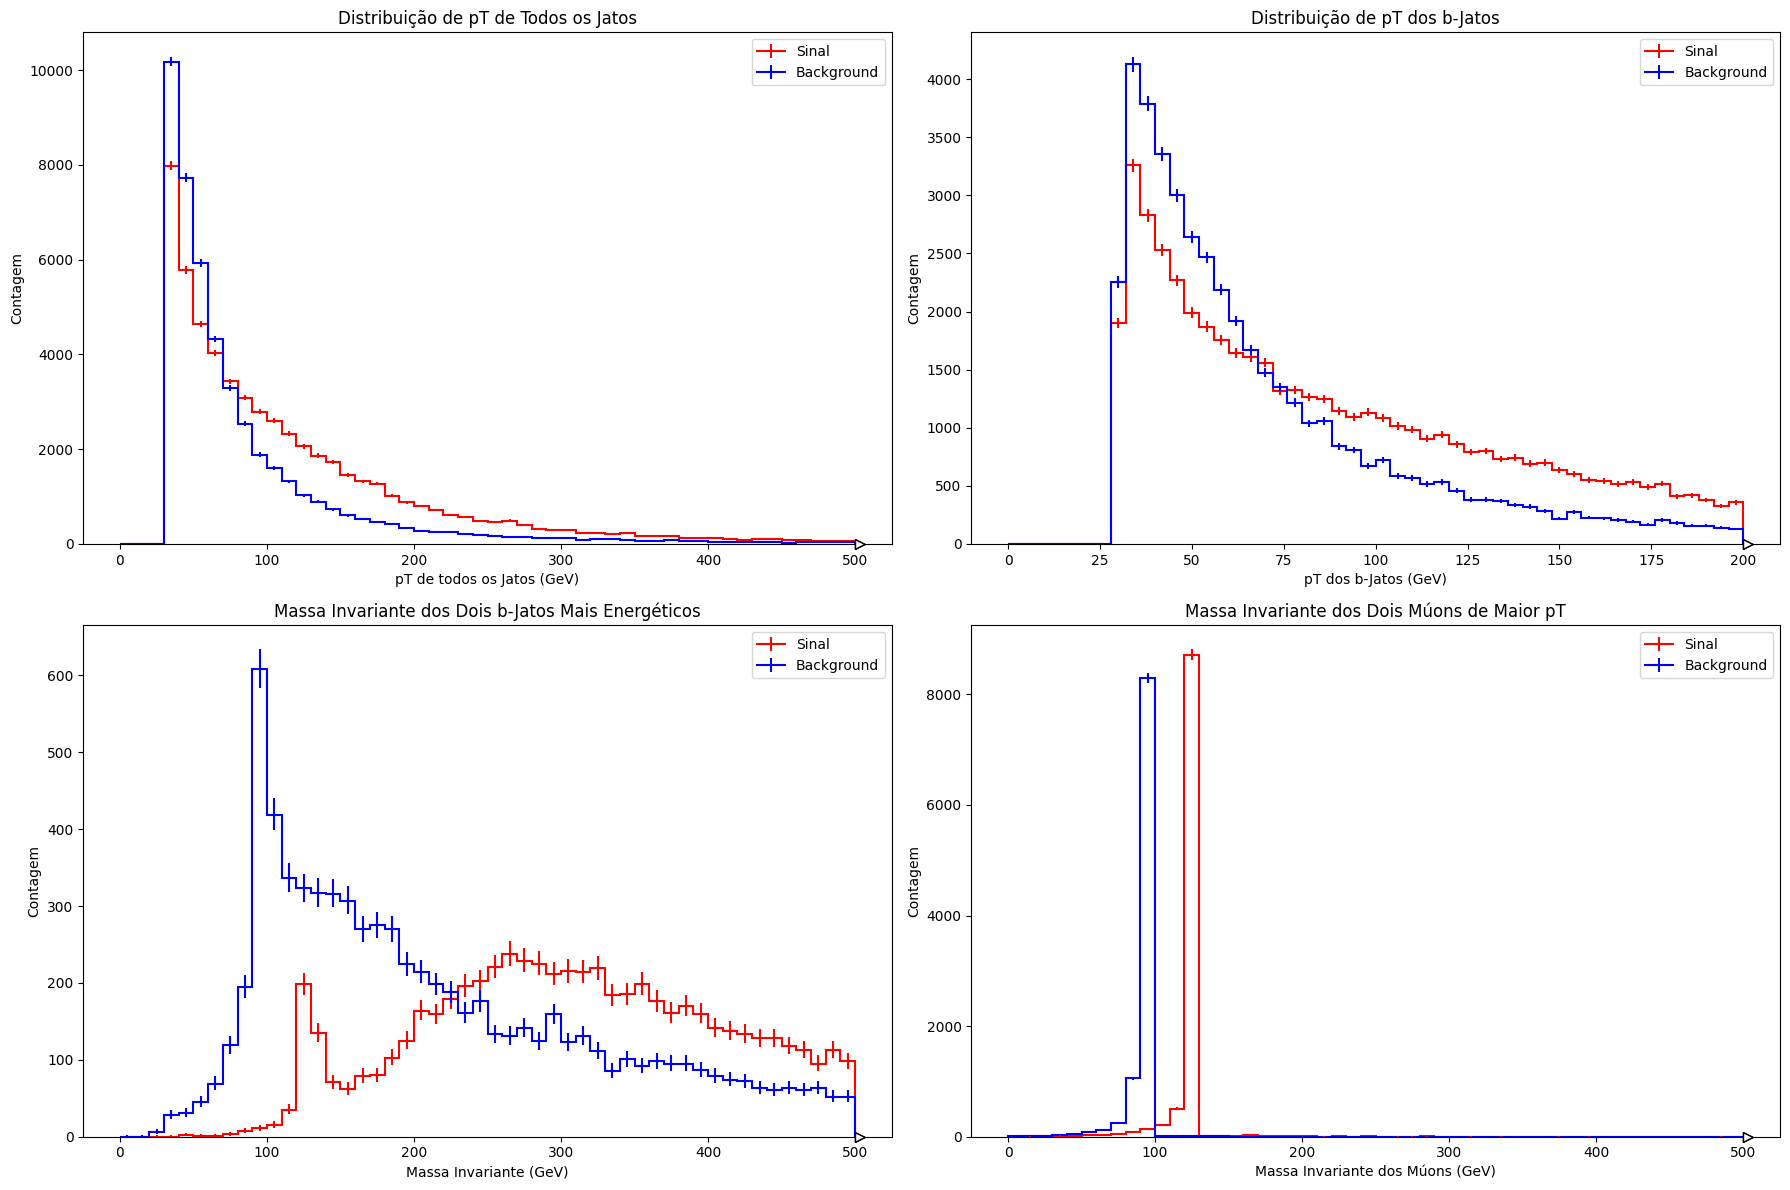

In [3]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj
import psutil
import os
import gc

# Função para verificar o uso de memória
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Limite máximo de eventos
max_events = 10000  # Total de eventos a serem processados
chunk_size = 1000   # Eventos por chunk

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background_file = '/home/levi/Documentos/Sinal_background/pp_zz_background_nobornQCD.hepmc'

# Definir histogramas
histo_jets_pt_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_pt_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_pt_sinal = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt_bg = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_muons_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_muons_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()

# Função para ler eventos HEPMC em chunks
def read_hepmc_file_in_chunks(hepmc_file, max_events=max_events, chunk_size=chunk_size):
    events = []
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            events.append(event)
            if (i + 1) % chunk_size == 0:  # Processar chunk
                yield events
                events = []  # Limpar lista de eventos
                print(f"Eventos lidos: {i + 1}")
                print_memory_usage()
                gc.collect()  # Forçar liberação de memória
        if events:  # Processar eventos restantes
            yield events

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, particles, cone_radius=0.4):
    secondary_vertex_displacement = []
    for p in particles:
        if p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)
    if len(secondary_vertex_displacement) > 0:
        return np.mean(secondary_vertex_displacement) > 1.0
    return False

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para processar eventos e preencher histogramas de jatos
def analyze_events(events, histo_all_jets, histo_bjets_pt, histo_mass):
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis)
        particles = [p for p in event.particles if p.status == 1]
        
        # Converter partículas para objetos PseudoJet do FastJet
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles]
        
        # Definir o algoritmo de clustering (anti-kT, R = 0.4)
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        
        # Clusterizar as partículas em jatos
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        
        # Selecionar jatos com pT > 30 GeV
        jets = clusterer.inclusive_jets(30.0)
        
        # Preencher histograma de pT de todos os jatos
        for jet in jets:
            histo_all_jets.fill(jet.pt())
        
        # Filtrar jatos b-tagged
        b_jets = [jet for jet in jets if is_b_tagged(jet, particles)]
        
        # Preencher histograma de pT dos jatos b-tagged
        for jet in b_jets:
            histo_bjets_pt.fill(jet.pt())
        
        # Selecionar os dois jatos de maior pT
        if len(b_jets) >= 2:
            b_jets_sorted = sorted(b_jets, key=lambda j: j.pt(), reverse=True)
            b_jets_selected = b_jets_sorted[:2]
            
            # Calcular a massa invariante dos dois jatos selecionados
            mass = invariant_mass(b_jets_selected[0], b_jets_selected[1])
            
            # Preencher histograma da massa invariante
            histo_mass.fill(mass)
        
        # Liberar memória após processar o evento
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, fj_particles, jets, b_jets  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Função para identificar múons com cargas opostas e de mesmo sabor
def find_opposite_charge_muons(particles):
    muons = []
    for p in particles:
        if abs(p.pid) == 13:  # Múons têm PID ±13
            muons.append(p)
    
    # Selecionar pares de múons com cargas opostas
    muon_pairs = []
    for i in range(len(muons)):
        for j in range(i + 1, len(muons)):
            if muons[i].pid == -muons[j].pid:  # Cargas opostas
                muon_pairs.append((muons[i], muons[j]))
    
    return muon_pairs

# Função para processar eventos e preencher histograma de múons
def analyze_muons(events, histo_muons_mass):
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis)
        particles = [p for p in event.particles if p.status == 1]
        
        # Identificar pares de múons com cargas opostas
        muon_pairs = find_opposite_charge_muons(particles)
        
        if len(muon_pairs) >= 1:
            # Selecionar o par de múons com maior soma de pT
            selected_pair = max(muon_pairs, key=lambda pair: pair[0].momentum.pt() + pair[1].momentum.pt())
            
            # Criar objetos PseudoJet para os múons
            muon1 = fj.PseudoJet(selected_pair[0].momentum.x, selected_pair[0].momentum.y, selected_pair[0].momentum.z, selected_pair[0].momentum.e)
            muon2 = fj.PseudoJet(selected_pair[1].momentum.x, selected_pair[1].momentum.y, selected_pair[1].momentum.z, selected_pair[1].momentum.e)
            
            # Calcular a massa invariante
            mass = invariant_mass(muon1, muon2)
            
            # Preencher histograma da massa invariante
            histo_muons_mass.fill(mass)
        
        # Liberar memória após processar o evento
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, muon_pairs, selected_pair, muon1, muon2  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Processar eventos de sinal em chunks
print("Processando eventos de sinal...")
for chunk in read_hepmc_file_in_chunks(sinal_file):
    analyze_events(chunk, histo_jets_pt_sinal, histo_bjets_pt_sinal, histo_bjets_mass_sinal)
    analyze_muons(chunk, histo_muons_mass_sinal)

# Processar eventos de background em chunks
print("\nProcessando eventos de background...")
for chunk in read_hepmc_file_in_chunks(background_file):
    analyze_events(chunk, histo_jets_pt_bg, histo_bjets_pt_bg, histo_bjets_mass_bg)
    analyze_muons(chunk, histo_muons_mass_bg)

# Plotar histogramas
fig, ax = plt.subplots(2, 2, figsize=(18, 12))

# Histogramas de pT de todos os jatos
histo_jets_pt_sinal.plot(ax=ax[0, 0], label='Sinal', color='red')
histo_jets_pt_bg.plot(ax=ax[0, 0], label='Background', color='blue')
ax[0, 0].set(xlabel='pT de todos os Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT de Todos os Jatos')
ax[0, 0].legend()

# Histogramas de pT dos jatos b-tagging
histo_bjets_pt_sinal.plot(ax=ax[0, 1], label='Sinal', color='red')
histo_bjets_pt_bg.plot(ax=ax[0, 1], label='Background', color='blue')
ax[0, 1].set(xlabel='pT dos b-Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT dos b-Jatos')
ax[0, 1].legend()

# Histogramas da massa invariante dos dois b-jatos mais energéticos
histo_bjets_mass_sinal.plot(ax=ax[1, 0], label='Sinal', color='red')
histo_bjets_mass_bg.plot(ax=ax[1, 0], label='Background', color='blue')
ax[1, 0].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois b-Jatos Mais Energéticos')
ax[1, 0].legend()

# Histograma da massa invariante dos dois múons de maior pT
histo_muons_mass_sinal.plot(ax=ax[1, 1], label='Sinal', color='red')
histo_muons_mass_bg.plot(ax=ax[1, 1], label='Background', color='blue')
ax[1, 1].set(xlabel='Massa Invariante dos Múons (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois Múons de Maior pT')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

Processando eventos de sinal...
Eventos processados: 1000
Uso de memória: 3327.95 MB
Eventos processados: 1000
Uso de memória: 3327.95 MB
Eventos lidos: 1000
Uso de memória: 3327.95 MB
Eventos processados: 1000
Uso de memória: 3326.41 MB
Eventos processados: 1000
Uso de memória: 3326.41 MB
Eventos lidos: 2000
Uso de memória: 3326.41 MB
Eventos processados: 1000
Uso de memória: 3325.82 MB
Eventos processados: 1000
Uso de memória: 3325.82 MB
Eventos lidos: 3000
Uso de memória: 3325.82 MB
Eventos processados: 1000
Uso de memória: 3325.82 MB
Eventos processados: 1000
Uso de memória: 3325.82 MB
Eventos lidos: 4000
Uso de memória: 3325.82 MB
Eventos processados: 1000
Uso de memória: 3325.82 MB
Eventos processados: 1000
Uso de memória: 3325.82 MB
Eventos lidos: 5000
Uso de memória: 3325.82 MB
Eventos processados: 1000
Uso de memória: 3325.82 MB
Eventos processados: 1000
Uso de memória: 3325.82 MB
Eventos lidos: 6000
Uso de memória: 3325.82 MB
Eventos processados: 1000
Uso de memória: 3325.81 

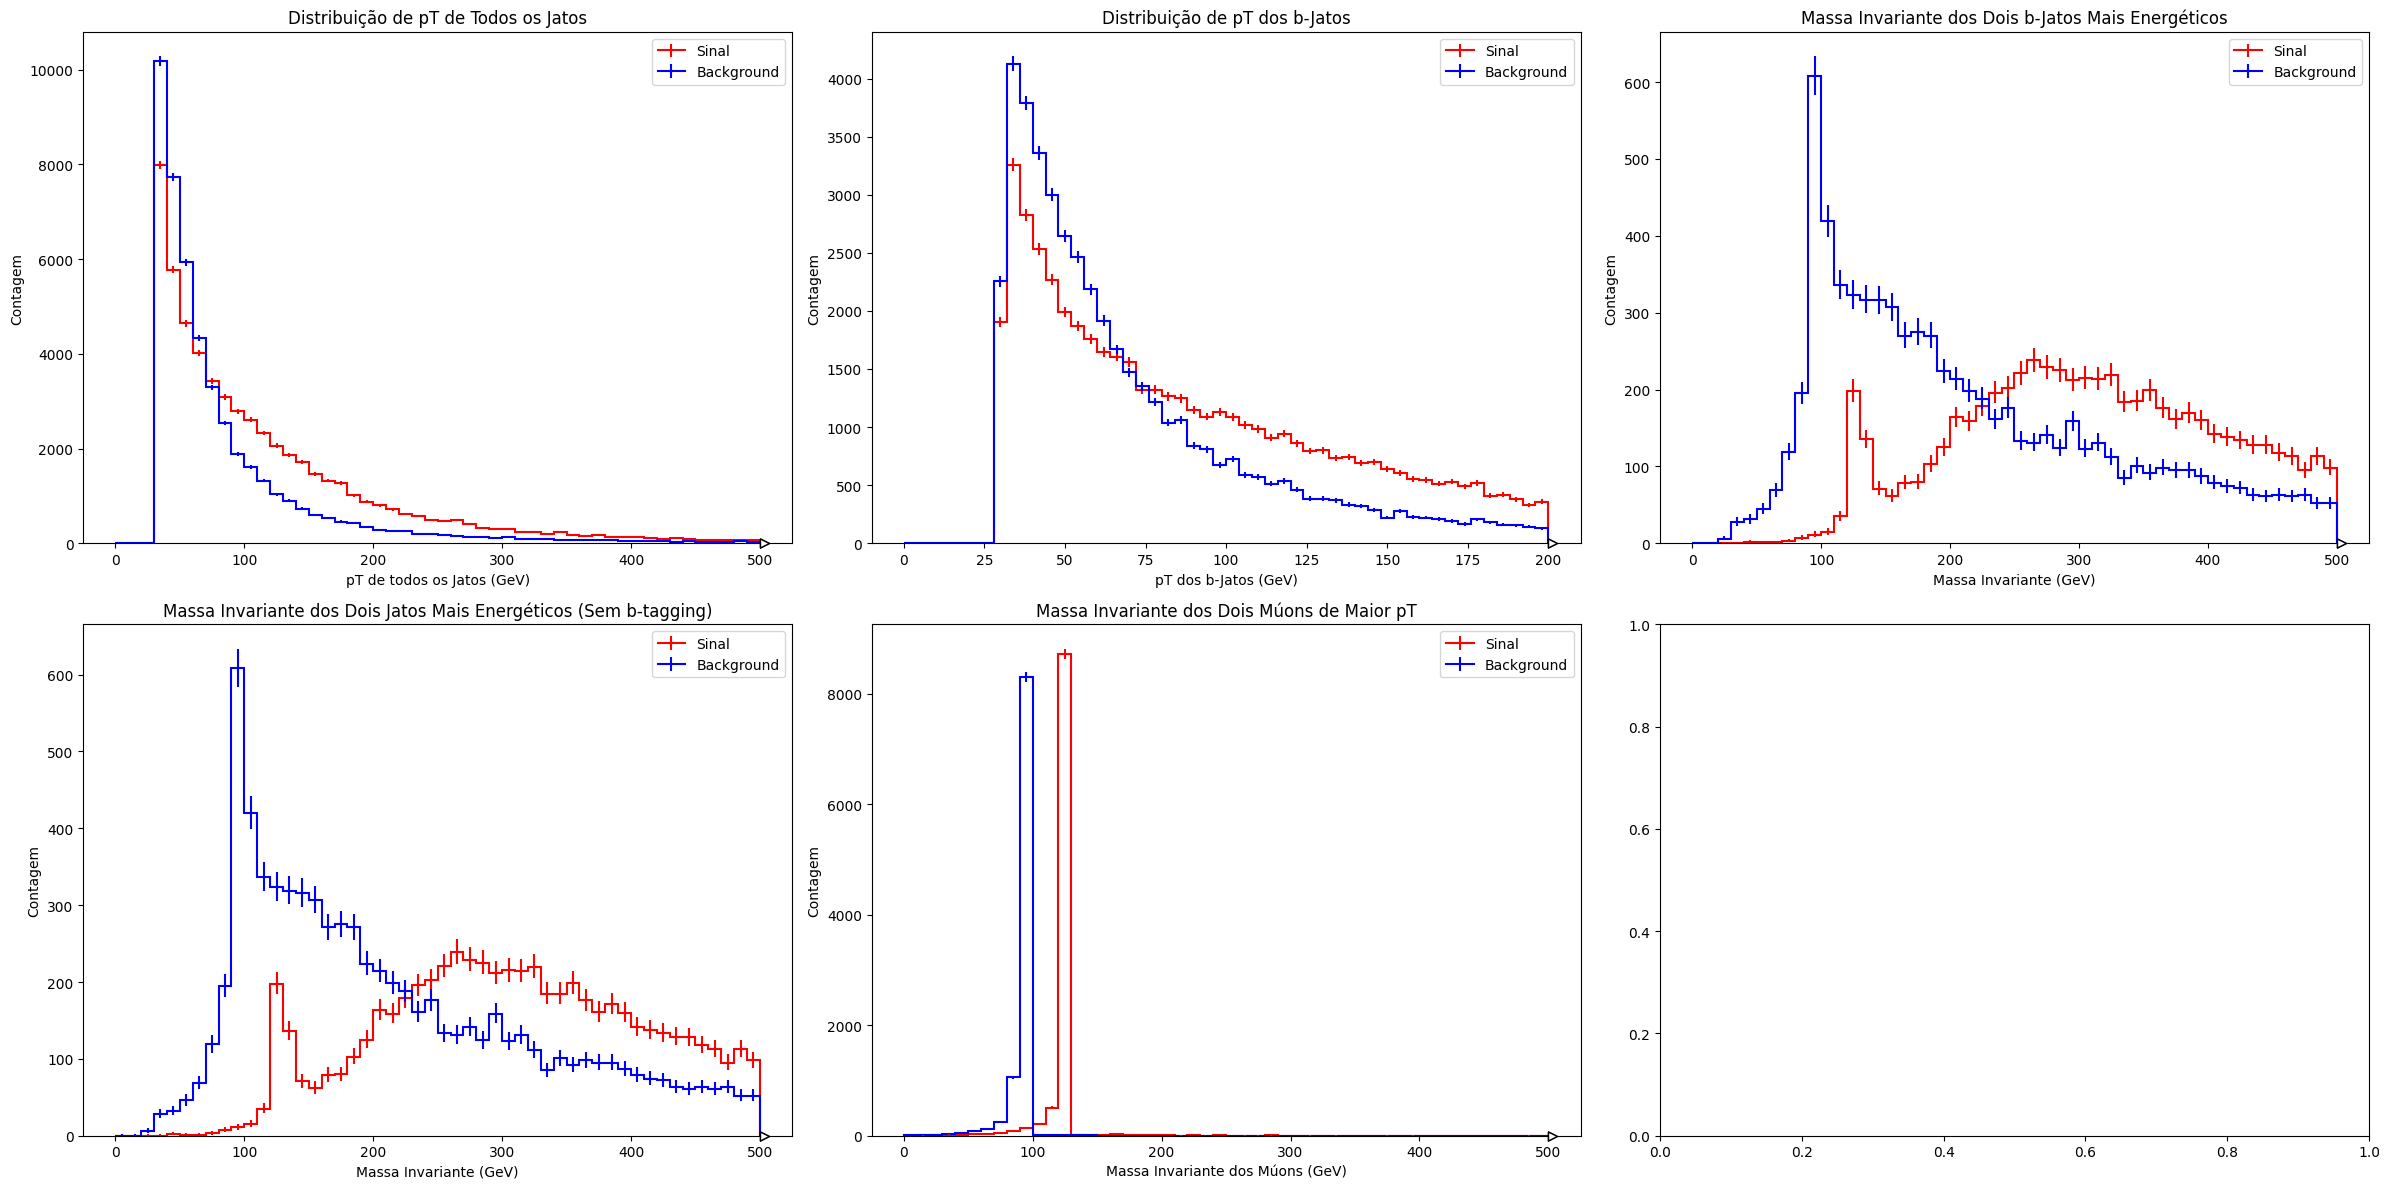

In [4]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj
import psutil
import os
import gc

# Função para verificar o uso de memória
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Limite máximo de eventos
max_events = 10000  # Total de eventos a serem processados
chunk_size = 1000   # Eventos por chunk

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background_file = '/home/levi/Documentos/Sinal_background/pp_zz_background_nobornQCD.hepmc'

# Definir histogramas
histo_jets_pt_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_pt_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_pt_sinal = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt_bg = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()  # Novo histograma
histo_jets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()      # Novo histograma
histo_muons_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_muons_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()

# Função para ler eventos HEPMC em chunks
def read_hepmc_file_in_chunks(hepmc_file, max_events=max_events, chunk_size=chunk_size):
    events = []
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            events.append(event)
            if (i + 1) % chunk_size == 0:  # Processar chunk
                yield events
                events = []  # Limpar lista de eventos
                print(f"Eventos lidos: {i + 1}")
                print_memory_usage()
                gc.collect()  # Forçar liberação de memória
        if events:  # Processar eventos restantes
            yield events

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, particles, cone_radius=0.4):
    secondary_vertex_displacement = []
    for p in particles:
        if p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)
    if len(secondary_vertex_displacement) > 0:
        return np.mean(secondary_vertex_displacement) > 1.0
    return False

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para processar eventos e preencher histogramas de jatos
def analyze_events(events, histo_all_jets, histo_bjets_pt, histo_bjets_mass, histo_jets_mass):
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis)
        particles = [p for p in event.particles if p.status == 1]
        
        # Converter partículas para objetos PseudoJet do FastJet
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles]
        
        # Definir o algoritmo de clustering (anti-kT, R = 0.4)
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        
        # Clusterizar as partículas em jatos
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        
        # Selecionar jatos com pT > 30 GeV
        jets = clusterer.inclusive_jets(30.0)
        
        # Preencher histograma de pT de todos os jatos
        for jet in jets:
            histo_all_jets.fill(jet.pt())
        
        # Filtrar jatos b-tagged
        b_jets = [jet for jet in jets if is_b_tagged(jet, particles)]
        
        # Preencher histograma de pT dos jatos b-tagged
        for jet in b_jets:
            histo_bjets_pt.fill(jet.pt())
        
        # Selecionar os dois jatos de maior pT (b-tagged)
        if len(b_jets) >= 2:
            b_jets_sorted = sorted(b_jets, key=lambda j: j.pt(), reverse=True)
            b_jets_selected = b_jets_sorted[:2]
            
            # Calcular a massa invariante dos dois jatos b-tagged selecionados
            mass = invariant_mass(b_jets_selected[0], b_jets_selected[1])
            
            # Preencher histograma da massa invariante dos jatos b-tagged
            histo_bjets_mass.fill(mass)
        
        # Selecionar os dois jatos de maior pT (sem b-tagging)
        if len(jets) >= 2:
            jets_sorted = sorted(jets, key=lambda j: j.pt(), reverse=True)
            jets_selected = jets_sorted[:2]
            
            # Calcular a massa invariante dos dois jatos selecionados
            mass = invariant_mass(jets_selected[0], jets_selected[1])
            
            # Preencher histograma da massa invariante dos jatos (sem b-tagging)
            histo_jets_mass.fill(mass)
        
        # Liberar memória após processar o evento
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, fj_particles, jets, b_jets  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Função para identificar múons com cargas opostas e de mesmo sabor
def find_opposite_charge_muons(particles):
    muons = []
    for p in particles:
        if abs(p.pid) == 13:  # Múons têm PID ±13
            muons.append(p)
    
    # Selecionar pares de múons com cargas opostas
    muon_pairs = []
    for i in range(len(muons)):
        for j in range(i + 1, len(muons)):
            if muons[i].pid == -muons[j].pid:  # Cargas opostas
                muon_pairs.append((muons[i], muons[j]))
    
    return muon_pairs

# Função para processar eventos e preencher histograma de múons
def analyze_muons(events, histo_muons_mass):
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis)
        particles = [p for p in event.particles if p.status == 1]
        
        # Identificar pares de múons com cargas opostas
        muon_pairs = find_opposite_charge_muons(particles)
        
        if len(muon_pairs) >= 1:
            # Selecionar o par de múons com maior soma de pT
            selected_pair = max(muon_pairs, key=lambda pair: pair[0].momentum.pt() + pair[1].momentum.pt())
            
            # Criar objetos PseudoJet para os múons
            muon1 = fj.PseudoJet(selected_pair[0].momentum.x, selected_pair[0].momentum.y, selected_pair[0].momentum.z, selected_pair[0].momentum.e)
            muon2 = fj.PseudoJet(selected_pair[1].momentum.x, selected_pair[1].momentum.y, selected_pair[1].momentum.z, selected_pair[1].momentum.e)
            
            # Calcular a massa invariante
            mass = invariant_mass(muon1, muon2)
            
            # Preencher histograma da massa invariante
            histo_muons_mass.fill(mass)
        
        # Liberar memória após processar o evento
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, muon_pairs, selected_pair, muon1, muon2  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Processar eventos de sinal em chunks
print("Processando eventos de sinal...")
for chunk in read_hepmc_file_in_chunks(sinal_file):
    analyze_events(chunk, histo_jets_pt_sinal, histo_bjets_pt_sinal, histo_bjets_mass_sinal, histo_jets_mass_sinal)
    analyze_muons(chunk, histo_muons_mass_sinal)

# Processar eventos de background em chunks
print("\nProcessando eventos de background...")
for chunk in read_hepmc_file_in_chunks(background_file):
    analyze_events(chunk, histo_jets_pt_bg, histo_bjets_pt_bg, histo_bjets_mass_bg, histo_jets_mass_bg)
    analyze_muons(chunk, histo_muons_mass_bg)

# Plotar histogramas
fig, ax = plt.subplots(2, 3, figsize=(24, 12))

# Histogramas de pT de todos os jatos
histo_jets_pt_sinal.plot(ax=ax[0, 0], label='Sinal', color='red')
histo_jets_pt_bg.plot(ax=ax[0, 0], label='Background', color='blue')
ax[0, 0].set(xlabel='pT de todos os Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT de Todos os Jatos')
ax[0, 0].legend()

# Histogramas de pT dos jatos b-tagging
histo_bjets_pt_sinal.plot(ax=ax[0, 1], label='Sinal', color='red')
histo_bjets_pt_bg.plot(ax=ax[0, 1], label='Background', color='blue')
ax[0, 1].set(xlabel='pT dos b-Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT dos b-Jatos')
ax[0, 1].legend()

# Histogramas da massa invariante dos dois b-jatos mais energéticos
histo_bjets_mass_sinal.plot(ax=ax[0, 2], label='Sinal', color='red')
histo_bjets_mass_bg.plot(ax=ax[0, 2], label='Background', color='blue')
ax[0, 2].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois b-Jatos Mais Energéticos')
ax[0, 2].legend()

# Histogramas da massa invariante dos dois jatos mais energéticos (sem b-tagging)
histo_jets_mass_sinal.plot(ax=ax[1, 0], label='Sinal', color='red')
histo_jets_mass_bg.plot(ax=ax[1, 0], label='Background', color='blue')
ax[1, 0].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois Jatos Mais Energéticos (Sem b-tagging)')
ax[1, 0].legend()

# Histograma da massa invariante dos dois múons de maior pT
histo_muons_mass_sinal.plot(ax=ax[1, 1], label='Sinal', color='red')
histo_muons_mass_bg.plot(ax=ax[1, 1], label='Background', color='blue')
ax[1, 1].set(xlabel='Massa Invariante dos Múons (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois Múons de Maior pT')
ax[1, 1].legend()

plt.tight_layout()
plt.show()


Processando eventos de sinal...
Eventos processados: 1000
Uso de memória: 3328.76 MB
Eventos processados: 1000
Uso de memória: 3328.76 MB
Eventos lidos: 1000
Uso de memória: 3328.76 MB
Eventos processados: 1000
Uso de memória: 3328.00 MB
Eventos processados: 1000
Uso de memória: 3328.00 MB
Eventos lidos: 2000
Uso de memória: 3328.00 MB
Eventos processados: 1000
Uso de memória: 3327.89 MB
Eventos processados: 1000
Uso de memória: 3327.89 MB
Eventos lidos: 3000
Uso de memória: 3327.89 MB
Eventos processados: 1000
Uso de memória: 3327.89 MB
Eventos processados: 1000
Uso de memória: 3327.89 MB
Eventos lidos: 4000
Uso de memória: 3327.89 MB
Eventos processados: 1000
Uso de memória: 3327.85 MB
Eventos processados: 1000
Uso de memória: 3327.85 MB
Eventos lidos: 5000
Uso de memória: 3327.85 MB
Eventos processados: 1000
Uso de memória: 3327.85 MB
Eventos processados: 1000
Uso de memória: 3327.85 MB
Eventos lidos: 6000
Uso de memória: 3327.85 MB
Eventos processados: 1000
Uso de memória: 3327.85 

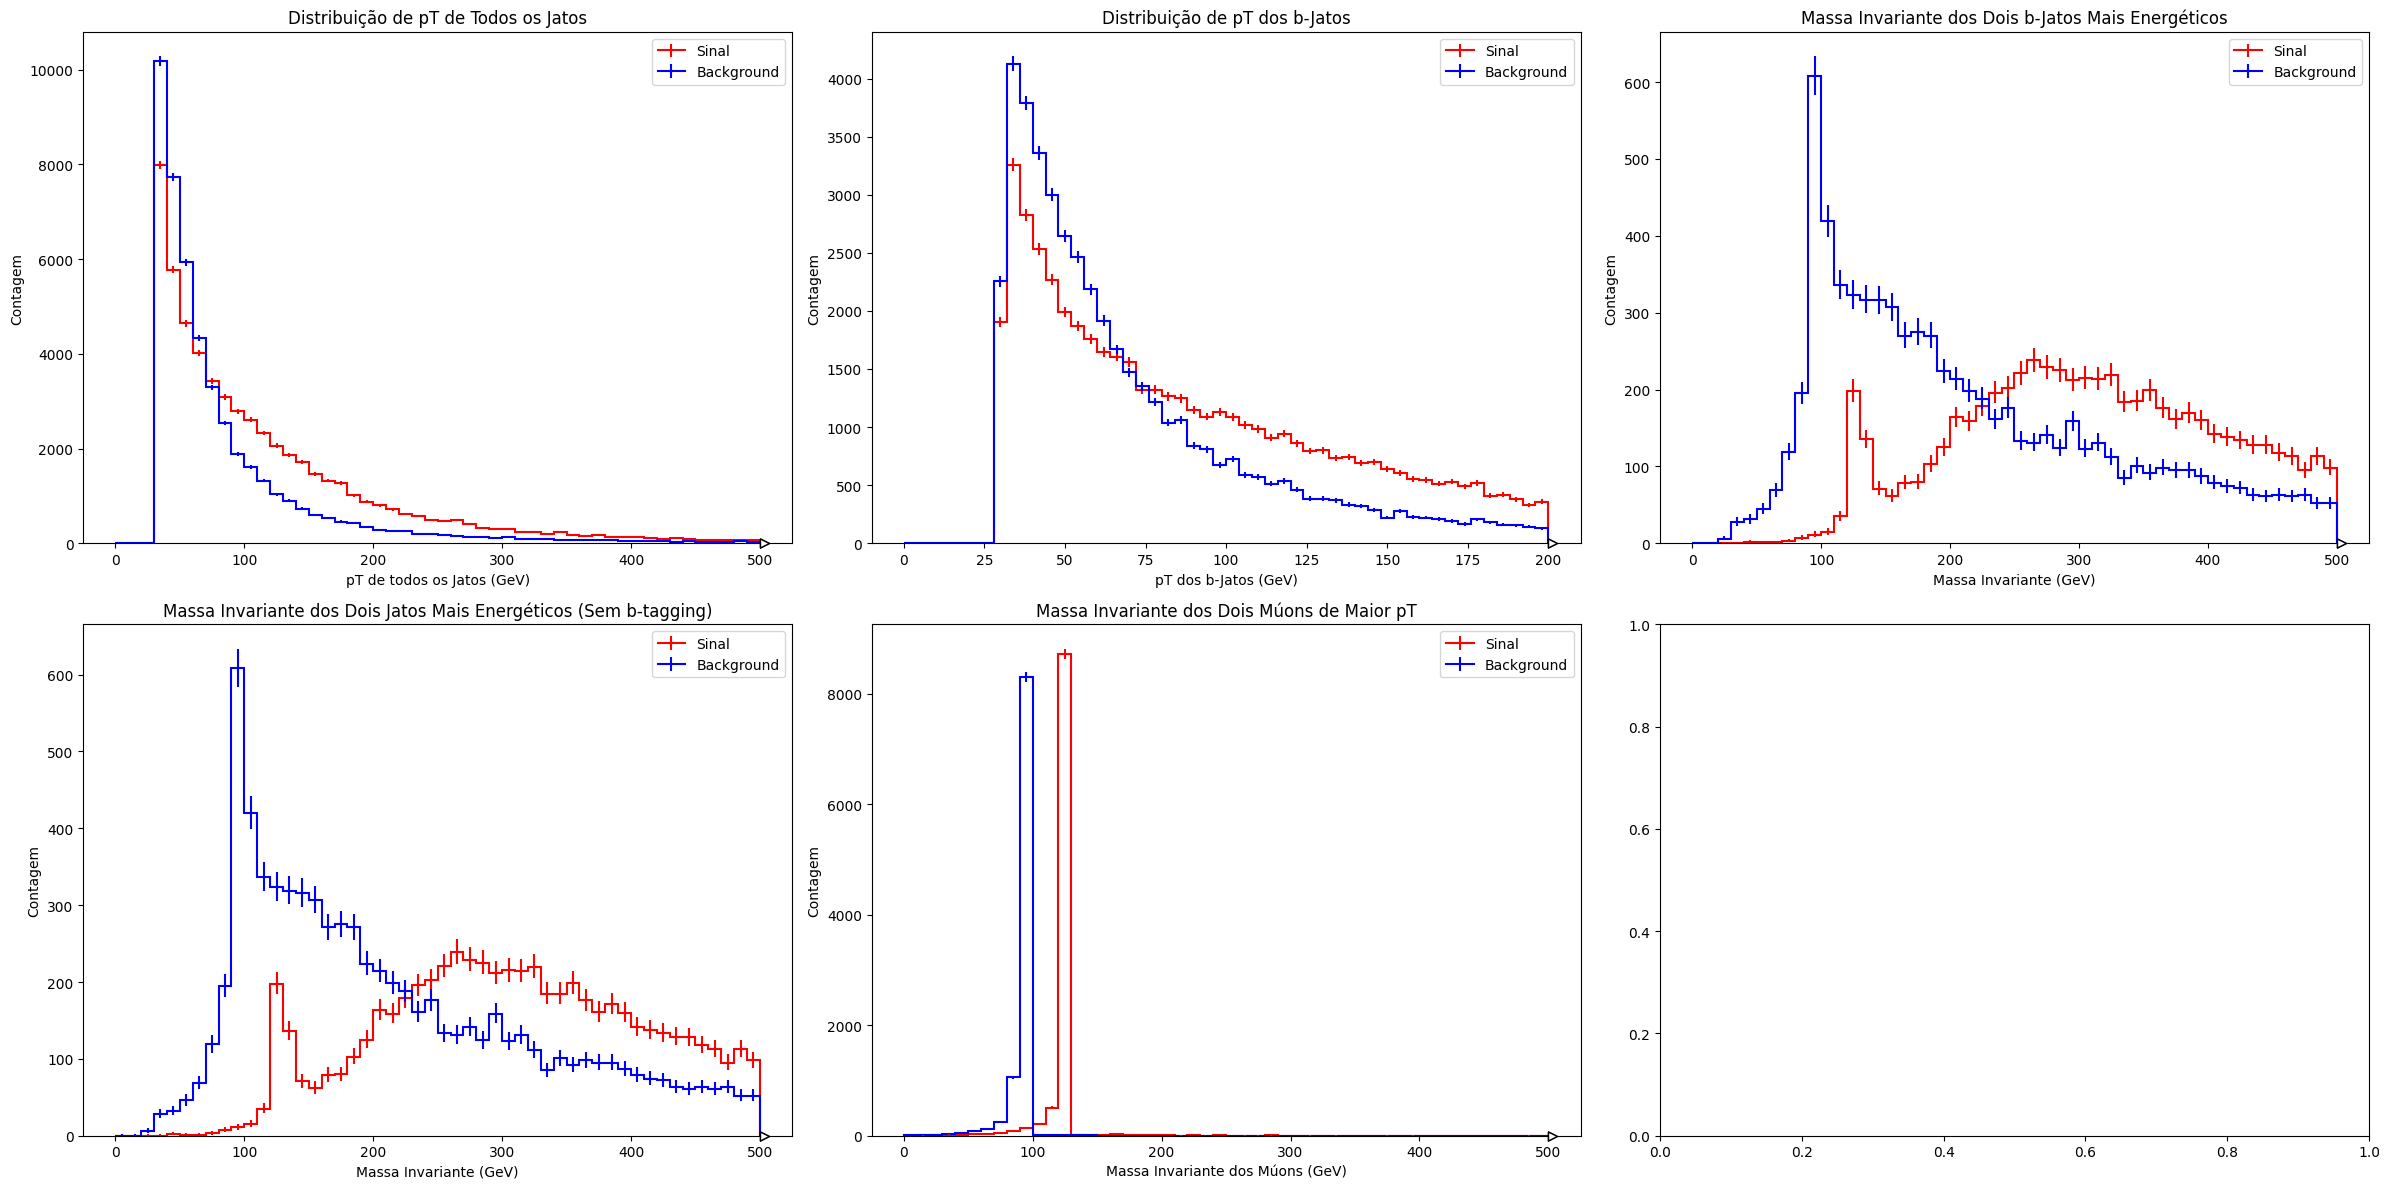

In [5]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj
import psutil
import os
import gc

# Função para verificar o uso de memória
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Limite máximo de eventos
max_events = 10000  # Total de eventos a serem processados
chunk_size = 1000   # Eventos por chunk

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background_file = '/home/levi/Documentos/Sinal_background/pp_zz_background_nobornQCD.hepmc'

# Definir histogramas
histo_jets_pt_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_pt_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_pt_sinal = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt_bg = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()  # Novo histograma
histo_jets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()      # Novo histograma
histo_muons_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_muons_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()

# Função para ler eventos HEPMC em chunks
def read_hepmc_file_in_chunks(hepmc_file, max_events=max_events, chunk_size=chunk_size):
    events = []
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            events.append(event)
            if (i + 1) % chunk_size == 0:  # Processar chunk
                yield events
                events = []  # Limpar lista de eventos
                print(f"Eventos lidos: {i + 1}")
                print_memory_usage()
                gc.collect()  # Forçar liberação de memória
        if events:  # Processar eventos restantes
            yield events

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, particles, cone_radius=0.4):
    secondary_vertex_displacement = []
    for p in particles:
        if p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)
    if len(secondary_vertex_displacement) > 0:
        return np.mean(secondary_vertex_displacement) > 1.0
    return False

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para processar eventos e preencher histogramas de jatos
def analyze_events(events, histo_all_jets, histo_bjets_pt, histo_bjets_mass, histo_jets_mass):
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis)
        particles = [p for p in event.particles if p.status == 1]
        
        # Converter partículas para objetos PseudoJet do FastJet
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles]
        
        # Definir o algoritmo de clustering (anti-kT, R = 0.4)
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        
        # Clusterizar as partículas em jatos
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        
        # Selecionar jatos com pT > 30 GeV
        jets = clusterer.inclusive_jets(30.0)
        
        # Preencher histograma de pT de todos os jatos
        for jet in jets:
            histo_all_jets.fill(jet.pt())
        
        # Filtrar jatos b-tagged
        b_jets = [jet for jet in jets if is_b_tagged(jet, particles)]
        
        # Preencher histograma de pT dos jatos b-tagged
        for jet in b_jets:
            histo_bjets_pt.fill(jet.pt())
        
        # Selecionar os dois jatos de maior pT (b-tagged)
        if len(b_jets) >= 2:
            b_jets_sorted = sorted(b_jets, key=lambda j: j.pt(), reverse=True)
            b_jets_selected = b_jets_sorted[:2]
            
            # Verificar se os jatos selecionados são realmente b-tagged
            if all(is_b_tagged(jet, particles) for jet in b_jets_selected):
                # Calcular a massa invariante dos dois jatos b-tagged selecionados
                mass = invariant_mass(b_jets_selected[0], b_jets_selected[1])
                
                # Preencher histograma da massa invariante dos jatos b-tagged
                histo_bjets_mass.fill(mass)
        
        # Selecionar os dois jatos de maior pT (sem b-tagging)
        if len(jets) >= 2:
            jets_sorted = sorted(jets, key=lambda j: j.pt(), reverse=True)
            jets_selected = jets_sorted[:2]
            
            # Calcular a massa invariante dos dois jatos selecionados
            mass = invariant_mass(jets_selected[0], jets_selected[1])
            
            # Preencher histograma da massa invariante dos jatos (sem b-tagging)
            histo_jets_mass.fill(mass)
        
        # Liberar memória após processar o evento
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, fj_particles, jets, b_jets  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Função para identificar múons com cargas opostas e de mesmo sabor
def find_opposite_charge_muons(particles):
    muons = []
    for p in particles:
        if abs(p.pid) == 13:  # Múons têm PID ±13
            muons.append(p)
    
    # Selecionar pares de múons com cargas opostas
    muon_pairs = []
    for i in range(len(muons)):
        for j in range(i + 1, len(muons)):
            if muons[i].pid == -muons[j].pid:  # Cargas opostas
                muon_pairs.append((muons[i], muons[j]))
    
    return muon_pairs

# Função para processar eventos e preencher histograma de múons
def analyze_muons(events, histo_muons_mass):
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis)
        particles = [p for p in event.particles if p.status == 1]
        
        # Identificar pares de múons com cargas opostas
        muon_pairs = find_opposite_charge_muons(particles)
        
        if len(muon_pairs) >= 1:
            # Selecionar o par de múons com maior soma de pT
            selected_pair = max(muon_pairs, key=lambda pair: pair[0].momentum.pt() + pair[1].momentum.pt())
            
            # Criar objetos PseudoJet para os múons
            muon1 = fj.PseudoJet(selected_pair[0].momentum.x, selected_pair[0].momentum.y, selected_pair[0].momentum.z, selected_pair[0].momentum.e)
            muon2 = fj.PseudoJet(selected_pair[1].momentum.x, selected_pair[1].momentum.y, selected_pair[1].momentum.z, selected_pair[1].momentum.e)
            
            # Calcular a massa invariante
            mass = invariant_mass(muon1, muon2)
            
            # Preencher histograma da massa invariante
            histo_muons_mass.fill(mass)
        
        # Liberar memória após processar o evento
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, muon_pairs, selected_pair, muon1, muon2  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Processar eventos de sinal em chunks
print("Processando eventos de sinal...")
for chunk in read_hepmc_file_in_chunks(sinal_file):
    analyze_events(chunk, histo_jets_pt_sinal, histo_bjets_pt_sinal, histo_bjets_mass_sinal, histo_jets_mass_sinal)
    analyze_muons(chunk, histo_muons_mass_sinal)

# Processar eventos de background em chunks
print("\nProcessando eventos de background...")
for chunk in read_hepmc_file_in_chunks(background_file):
    analyze_events(chunk, histo_jets_pt_bg, histo_bjets_pt_bg, histo_bjets_mass_bg, histo_jets_mass_bg)
    analyze_muons(chunk, histo_muons_mass_bg)

# Plotar histogramas
fig, ax = plt.subplots(2, 3, figsize=(24, 12))

# Histogramas de pT de todos os jatos
histo_jets_pt_sinal.plot(ax=ax[0, 0], label='Sinal', color='red')
histo_jets_pt_bg.plot(ax=ax[0, 0], label='Background', color='blue')
ax[0, 0].set(xlabel='pT de todos os Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT de Todos os Jatos')
ax[0, 0].legend()

# Histogramas de pT dos jatos b-tagging
histo_bjets_pt_sinal.plot(ax=ax[0, 1], label='Sinal', color='red')
histo_bjets_pt_bg.plot(ax=ax[0, 1], label='Background', color='blue')
ax[0, 1].set(xlabel='pT dos b-Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT dos b-Jatos')
ax[0, 1].legend()

# Histogramas da massa invariante dos dois b-jatos mais energéticos
histo_bjets_mass_sinal.plot(ax=ax[0, 2], label='Sinal', color='red')
histo_bjets_mass_bg.plot(ax=ax[0, 2], label='Background', color='blue')
ax[0, 2].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois b-Jatos Mais Energéticos')
ax[0, 2].legend()

# Histogramas da massa invariante dos dois jatos mais energéticos (sem b-tagging)
histo_jets_mass_sinal.plot(ax=ax[1, 0], label='Sinal', color='red')
histo_jets_mass_bg.plot(ax=ax[1, 0], label='Background', color='blue')
ax[1, 0].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois Jatos Mais Energéticos (Sem b-tagging)')
ax[1, 0].legend()

# Histograma da massa invariante dos dois múons de maior pT
histo_muons_mass_sinal.plot(ax=ax[1, 1], label='Sinal', color='red')
histo_muons_mass_bg.plot(ax=ax[1, 1], label='Background', color='blue')
ax[1, 1].set(xlabel='Massa Invariante dos Múons (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois Múons de Maior pT')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

Processando eventos de sinal...
Eventos processados: 1000
Uso de memória: 1745.70 MB
Eventos processados: 1000
Uso de memória: 1745.70 MB
Eventos lidos: 1000
Uso de memória: 1745.70 MB
Eventos processados: 1000
Uso de memória: 3123.02 MB
Eventos processados: 1000
Uso de memória: 3123.02 MB
Eventos lidos: 2000
Uso de memória: 3123.02 MB
Eventos processados: 1000
Uso de memória: 3247.51 MB
Eventos processados: 1000
Uso de memória: 3247.51 MB
Eventos lidos: 3000
Uso de memória: 3247.51 MB
Eventos processados: 1000
Uso de memória: 3407.58 MB
Eventos processados: 1000
Uso de memória: 3407.58 MB
Eventos lidos: 4000
Uso de memória: 3407.58 MB
Eventos processados: 1000
Uso de memória: 3428.89 MB
Eventos processados: 1000
Uso de memória: 3428.89 MB
Eventos lidos: 5000
Uso de memória: 3428.89 MB
Eventos processados: 1000
Uso de memória: 3468.94 MB
Eventos processados: 1000
Uso de memória: 3468.94 MB
Eventos lidos: 6000
Uso de memória: 3468.94 MB
Eventos processados: 1000
Uso de memória: 3491.39 

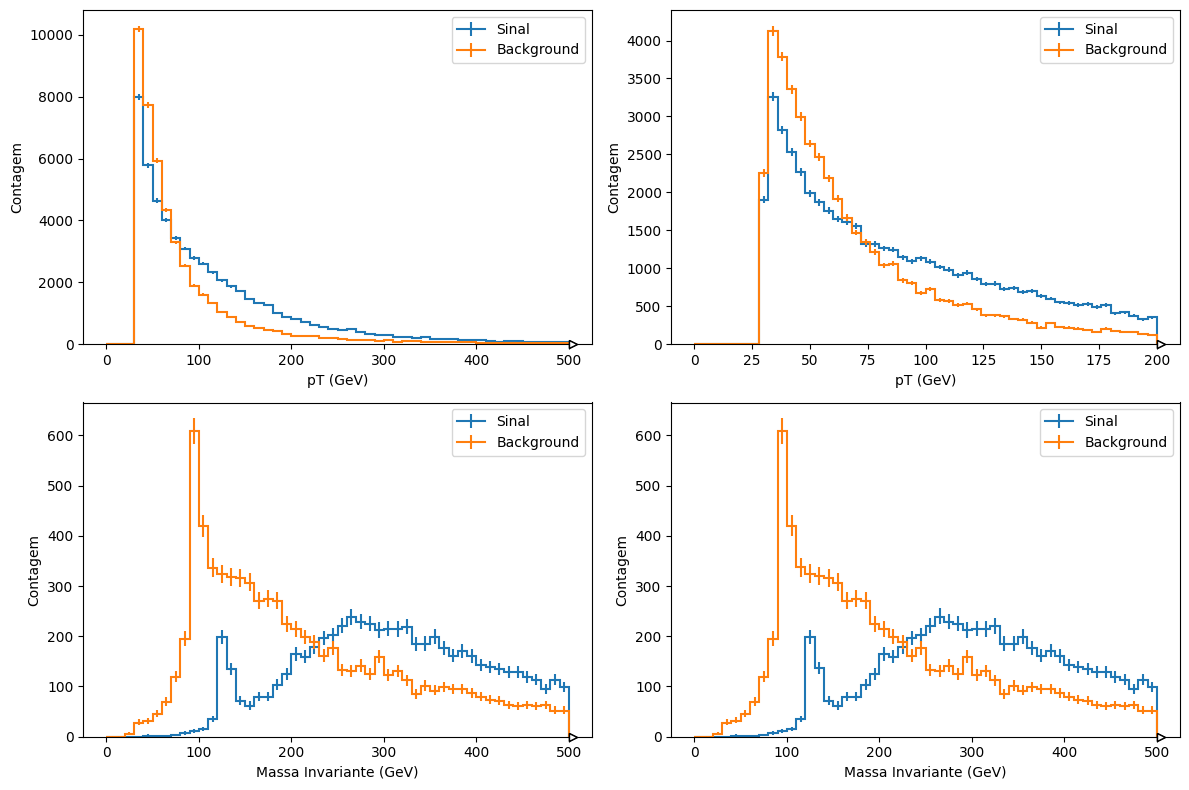

In [16]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj
import psutil
import os
import gc

# Função para verificar o uso de memória
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Limite máximo de eventos
max_events = 10000  # Total de eventos a serem processados
chunk_size = 1000   # Eventos por chunk

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background_file = '/home/levi/Documentos/Sinal_background/pp_zz_background_nobornQCD.hepmc'

# Definir histogramas
histo_jets_pt_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_pt_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_pt_sinal = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt_bg = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()  # Novo histograma
histo_jets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()      # Novo histograma
histo_muons_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_muons_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()

# Função para ler eventos HEPMC em chunks
def read_hepmc_file_in_chunks(hepmc_file, max_events=max_events, chunk_size=chunk_size):
    events = []
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            events.append(event)
            if (i + 1) % chunk_size == 0:  # Processar chunk
                yield events
                events = []  # Limpar lista de eventos
                print(f"Eventos lidos: {i + 1}")
                print_memory_usage()
                gc.collect()  # Forçar liberação de memória
        if events:  # Processar eventos restantes
            yield events

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, particles, cone_radius=0.4):
    secondary_vertex_displacement = []
    for p in particles:
        if p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)
    if len(secondary_vertex_displacement) > 0:
        return np.mean(secondary_vertex_displacement) > 1.0
    return False

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para processar eventos e preencher histogramas de jatos
def analyze_events(events, histo_all_jets, histo_bjets_pt, histo_bjets_mass, histo_jets_mass):
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis)
        particles = [p for p in event.particles if p.status == 1]
        
        # Converter partículas para objetos PseudoJet do FastJet
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles]
        
        # Definir o algoritmo de clustering (anti-kT, R = 0.4)
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        
        # Clusterizar as partículas em jatos
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        
        # Selecionar jatos com pT > 30 GeV
        jets = clusterer.inclusive_jets(30.0)
        
        # Preencher histograma de pT de todos os jatos
        for jet in jets:
            histo_all_jets.fill(jet.pt())
        
        # Filtrar jatos b-tagged
        b_jets = [jet for jet in jets if is_b_tagged(jet, particles)]
        
        # Preencher histograma de pT dos jatos b-tagged
        for jet in b_jets:
            histo_bjets_pt.fill(jet.pt())
        
        # Selecionar os dois jatos de maior pT (b-tagged)
        if len(b_jets) >= 2:
            b_jets_sorted = sorted(b_jets, key=lambda j: j.pt(), reverse=True)  # Ordenar por pT
            b_jets_selected = b_jets_sorted[:2]
            
            # Verificar se os jatos selecionados são realmente b-tagged
            if all(is_b_tagged(jet, particles) for jet in b_jets_selected):
                # Calcular a massa invariante dos dois jatos b-tagged selecionados
                mass = invariant_mass(b_jets_selected[0], b_jets_selected[1])
                
                # Preencher histograma da massa invariante dos jatos b-tagged
                histo_bjets_mass.fill(mass)
        
        # Selecionar os dois jatos de maior pT (sem b-tagging)
        if len(jets) >= 2:
            jets_sorted = sorted(jets, key=lambda j: j.pt(), reverse=True)  # Ordenar por pT
            jets_selected = jets_sorted[:2]
            
            # Calcular a massa invariante dos dois jatos selecionados
            mass = invariant_mass(jets_selected[0], jets_selected[1])
            
            # Preencher histograma da massa invariante dos jatos (sem b-tagging)
            histo_jets_mass.fill(mass)
        
        # Liberar memória após processar o evento
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, fj_particles, jets, b_jets  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Função para identificar múons com cargas opostas e de mesmo sabor
def find_opposite_charge_muons(particles):
    muons = []
    for p in particles:
        if abs(p.pid) == 13:  # Múons têm PID ±13
            muons.append(p)
    
    # Selecionar pares de múons com cargas opostas
    muon_pairs = []
    for i in range(len(muons)):
        for j in range(i + 1, len(muons)):
            if muons[i].pid == -muons[j].pid:  # Cargas opostas
                muon_pairs.append((muons[i], muons[j]))
    
    return muon_pairs

# Função para processar eventos e preencher histograma de múons
def analyze_muons(events, histo_muons_mass):
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis)
        particles = [p for p in event.particles if p.status == 1]
        
        # Identificar pares de múons com cargas opostas
        muon_pairs = find_opposite_charge_muons(particles)
        
        if len(muon_pairs) >= 1:
            # Selecionar o par de múons com maior soma de pT
            selected_pair = max(muon_pairs, key=lambda pair: pair[0].momentum.pt() + pair[1].momentum.pt())
            
            # Criar objetos PseudoJet para os múons
            muon1 = fj.PseudoJet(selected_pair[0].momentum.x, selected_pair[0].momentum.y, selected_pair[0].momentum.z, selected_pair[0].momentum.e)
            muon2 = fj.PseudoJet(selected_pair[1].momentum.x, selected_pair[1].momentum.y, selected_pair[1].momentum.z, selected_pair[1].momentum.e)
            
            # Calcular a massa invariante
            mass = invariant_mass(muon1, muon2)
            
            # Preencher histograma da massa invariante
            histo_muons_mass.fill(mass)
        
        # Liberar memória após processar o evento
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, muon_pairs, selected_pair, muon1, muon2  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Processar eventos de sinal
print("Processando eventos de sinal...")
for events in read_hepmc_file_in_chunks(sinal_file):
    analyze_events(events, histo_jets_pt_sinal, histo_bjets_pt_sinal, histo_bjets_mass_sinal, histo_jets_mass_sinal)
    analyze_muons(events, histo_muons_mass_sinal)

# Processar eventos de background
print("Processando eventos de background...")
for events in read_hepmc_file_in_chunks(background_file):
    analyze_events(events, histo_jets_pt_bg, histo_bjets_pt_bg, histo_bjets_mass_bg, histo_jets_mass_bg)
    analyze_muons(events, histo_muons_mass_bg)

# Plotando os resultados
plt.figure(figsize=(12, 8))

# Plotando os histogramas de pT de todos os jatos
plt.subplot(2, 2, 1)
histo_jets_pt_sinal.plot(label="Sinal")
histo_jets_pt_bg.plot(label="Background")
plt.xlabel('pT (GeV)')
plt.ylabel('Contagem')
plt.legend()

# Plotando os histogramas de pT de jatos b-tagged
plt.subplot(2, 2, 2)
histo_bjets_pt_sinal.plot(label="Sinal")
histo_bjets_pt_bg.plot(label="Background")
plt.xlabel('pT (GeV)')
plt.ylabel('Contagem')
plt.legend()

# Plotando os histogramas de massa invariante dos jatos b-tagged
plt.subplot(2, 2, 3)
histo_bjets_mass_sinal.plot(label="Sinal")
histo_bjets_mass_bg.plot(label="Background")
plt.xlabel('Massa Invariante (GeV)')
plt.ylabel('Contagem')
plt.legend()

# Plotando os histogramas de massa invariante dos jatos
plt.subplot(2, 2, 4)
histo_jets_mass_sinal.plot(label="Sinal")
histo_jets_mass_bg.plot(label="Background")
plt.xlabel('Massa Invariante (GeV)')
plt.ylabel('Contagem')
plt.legend()

plt.tight_layout()
plt.show()


# background_pp>zz

Processando eventos de sinal...
Eventos processados: 1000
Uso de memória: 3333.48 MB
Eventos processados: 1000
Uso de memória: 3333.48 MB
Eventos lidos: 1000
Uso de memória: 3333.48 MB
Eventos processados: 1000
Uso de memória: 3332.62 MB
Eventos processados: 1000
Uso de memória: 3332.62 MB
Eventos lidos: 2000
Uso de memória: 3332.62 MB
Eventos processados: 1000
Uso de memória: 3332.49 MB
Eventos processados: 1000
Uso de memória: 3332.49 MB
Eventos lidos: 3000
Uso de memória: 3332.49 MB
Eventos processados: 1000
Uso de memória: 3332.49 MB
Eventos processados: 1000
Uso de memória: 3332.49 MB
Eventos lidos: 4000
Uso de memória: 3332.49 MB
Eventos processados: 1000
Uso de memória: 3332.49 MB
Eventos processados: 1000
Uso de memória: 3332.49 MB
Eventos lidos: 5000
Uso de memória: 3332.49 MB
Eventos processados: 1000
Uso de memória: 3332.49 MB
Eventos processados: 1000
Uso de memória: 3332.49 MB
Eventos lidos: 6000
Uso de memória: 3332.49 MB
Eventos processados: 1000
Uso de memória: 3332.49 

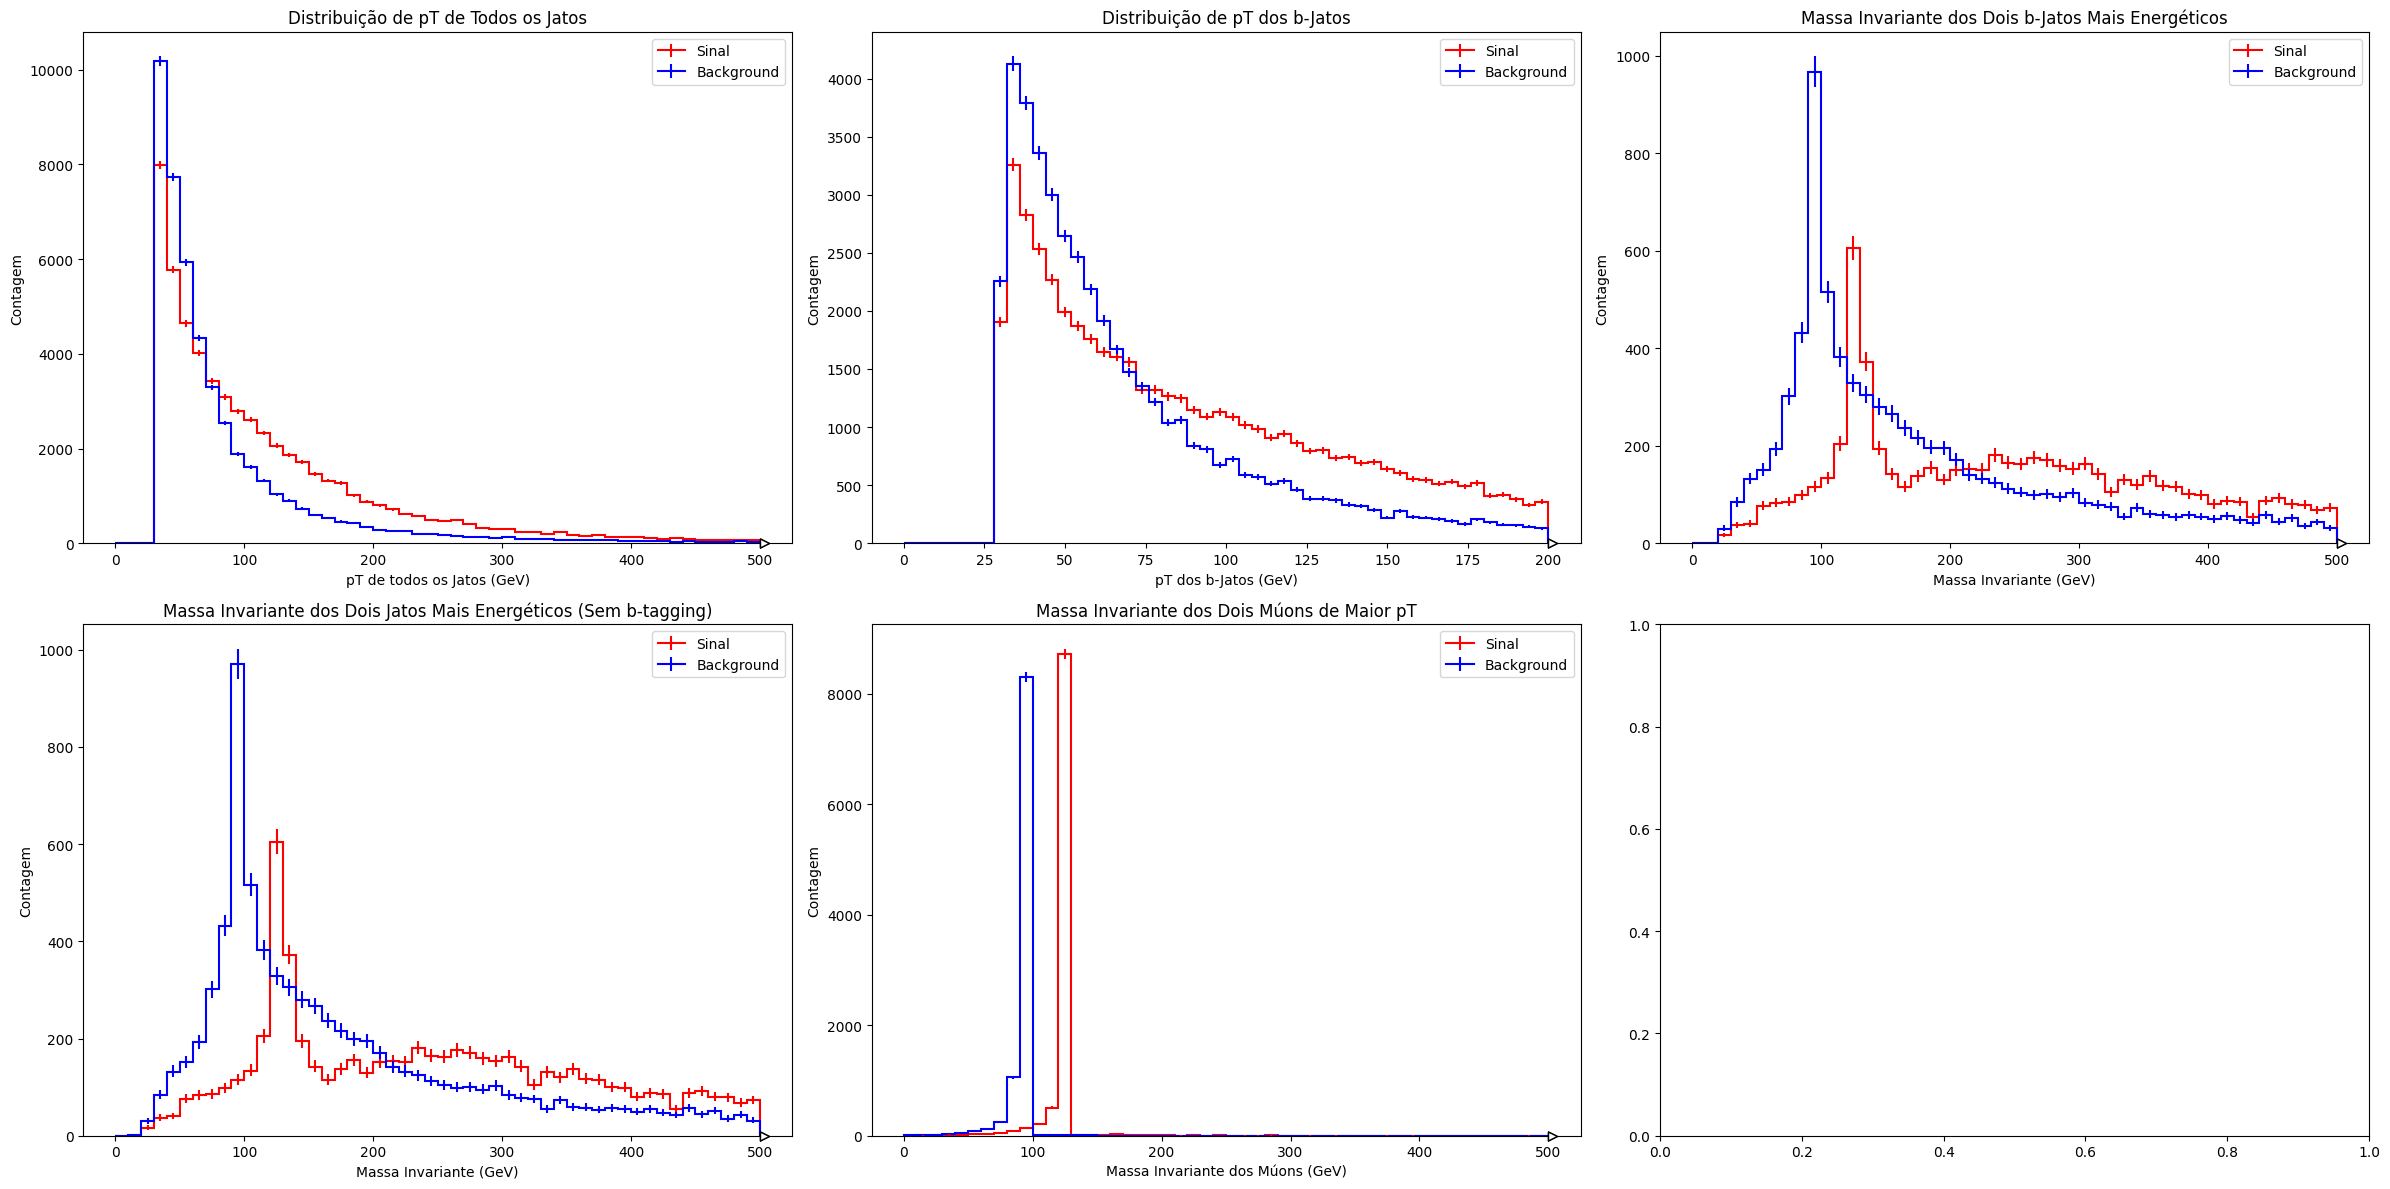

In [6]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj
import psutil
import os
import gc

# Função para verificar o uso de memória
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Limite máximo de eventos
max_events = 10000  # Total de eventos a serem processados
chunk_size = 1000   # Eventos por chunk

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background_file = '/home/levi/Documentos/Sinal_background/pp_zz_background_nobornQCD.hepmc'

# Definir histogramas
histo_jets_pt_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_pt_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_pt_sinal = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt_bg = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()  # Novo histograma
histo_jets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()      # Novo histograma
histo_muons_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_muons_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()

# Função para ler eventos HEPMC em chunks
def read_hepmc_file_in_chunks(hepmc_file, max_events=max_events, chunk_size=chunk_size):
    events = []
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            events.append(event)
            if (i + 1) % chunk_size == 0:  # Processar chunk
                yield events
                events = []  # Limpar lista de eventos
                print(f"Eventos lidos: {i + 1}")
                print_memory_usage()
                gc.collect()  # Forçar liberação de memória
        if events:  # Processar eventos restantes
            yield events

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, particles, cone_radius=0.4):
    secondary_vertex_displacement = []
    for p in particles:
        if p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)
    if len(secondary_vertex_displacement) > 0:
        return np.mean(secondary_vertex_displacement) > 1.0
    return False

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para processar eventos e preencher histogramas de jatos
def analyze_events(events, histo_all_jets, histo_bjets_pt, histo_bjets_mass, histo_jets_mass):
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis)
        particles = [p for p in event.particles if p.status == 1]
        
        # Converter partículas para objetos PseudoJet do FastJet
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles]
        
        # Definir o algoritmo de clustering (anti-kT, R = 0.4)
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        
        # Clusterizar as partículas em jatos
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        
        # Selecionar jatos com pT > 30 GeV
        jets = clusterer.inclusive_jets(30.0)
        
        # Preencher histograma de pT de todos os jatos
        for jet in jets:
            histo_all_jets.fill(jet.pt())
        
        # Filtrar jatos b-tagged
        b_jets = [jet for jet in jets if is_b_tagged(jet, particles)]
        
        # Preencher histograma de pT dos jatos b-tagged
        for jet in b_jets:
            histo_bjets_pt.fill(jet.pt())
        
        # Selecionar os dois jatos de maior energia (b-tagged)
        if len(b_jets) >= 2:
            b_jets_sorted = sorted(b_jets, key=lambda j: j.e(), reverse=True)  # Ordenar por energia
            b_jets_selected = b_jets_sorted[:2]
            
            # Verificar se os jatos selecionados são realmente b-tagged
            if all(is_b_tagged(jet, particles) for jet in b_jets_selected):
                # Calcular a massa invariante dos dois jatos b-tagged selecionados
                mass = invariant_mass(b_jets_selected[0], b_jets_selected[1])
                
                # Preencher histograma da massa invariante dos jatos b-tagged
                histo_bjets_mass.fill(mass)
        
        # Selecionar os dois jatos de maior energia (sem b-tagging)
        if len(jets) >= 2:
            jets_sorted = sorted(jets, key=lambda j: j.e(), reverse=True)  # Ordenar por energia
            jets_selected = jets_sorted[:2]
            
            # Calcular a massa invariante dos dois jatos selecionados
            mass = invariant_mass(jets_selected[0], jets_selected[1])
            
            # Preencher histograma da massa invariante dos jatos (sem b-tagging)
            histo_jets_mass.fill(mass)
        
        # Liberar memória após processar o evento
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, fj_particles, jets, b_jets  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Função para identificar múons com cargas opostas e de mesmo sabor
def find_opposite_charge_muons(particles):
    muons = []
    for p in particles:
        if abs(p.pid) == 13:  # Múons têm PID ±13
            muons.append(p)
    
    # Selecionar pares de múons com cargas opostas
    muon_pairs = []
    for i in range(len(muons)):
        for j in range(i + 1, len(muons)):
            if muons[i].pid == -muons[j].pid:  # Cargas opostas
                muon_pairs.append((muons[i], muons[j]))
    
    return muon_pairs

# Função para processar eventos e preencher histograma de múons
def analyze_muons(events, histo_muons_mass):
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis)
        particles = [p for p in event.particles if p.status == 1]
        
        # Identificar pares de múons com cargas opostas
        muon_pairs = find_opposite_charge_muons(particles)
        
        if len(muon_pairs) >= 1:
            # Selecionar o par de múons com maior soma de pT
            selected_pair = max(muon_pairs, key=lambda pair: pair[0].momentum.pt() + pair[1].momentum.pt())
            
            # Criar objetos PseudoJet para os múons
            muon1 = fj.PseudoJet(selected_pair[0].momentum.x, selected_pair[0].momentum.y, selected_pair[0].momentum.z, selected_pair[0].momentum.e)
            muon2 = fj.PseudoJet(selected_pair[1].momentum.x, selected_pair[1].momentum.y, selected_pair[1].momentum.z, selected_pair[1].momentum.e)
            
            # Calcular a massa invariante
            mass = invariant_mass(muon1, muon2)
            
            # Preencher histograma da massa invariante
            histo_muons_mass.fill(mass)
        
        # Liberar memória após processar o evento
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, muon_pairs, selected_pair, muon1, muon2  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Processar eventos de sinal em chunks
print("Processando eventos de sinal...")
for chunk in read_hepmc_file_in_chunks(sinal_file):
    analyze_events(chunk, histo_jets_pt_sinal, histo_bjets_pt_sinal, histo_bjets_mass_sinal, histo_jets_mass_sinal)
    analyze_muons(chunk, histo_muons_mass_sinal)

# Processar eventos de background em chunks
print("\nProcessando eventos de background...")
for chunk in read_hepmc_file_in_chunks(background_file):
    analyze_events(chunk, histo_jets_pt_bg, histo_bjets_pt_bg, histo_bjets_mass_bg, histo_jets_mass_bg)
    analyze_muons(chunk, histo_muons_mass_bg)

# Plotar histogramas
fig, ax = plt.subplots(2, 3, figsize=(24, 12))

# Histogramas de pT de todos os jatos
histo_jets_pt_sinal.plot(ax=ax[0, 0], label='Sinal', color='red')
histo_jets_pt_bg.plot(ax=ax[0, 0], label='Background', color='blue')
ax[0, 0].set(xlabel='pT de todos os Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT de Todos os Jatos')
ax[0, 0].legend()

# Histogramas de pT dos jatos b-tagging
histo_bjets_pt_sinal.plot(ax=ax[0, 1], label='Sinal', color='red')
histo_bjets_pt_bg.plot(ax=ax[0, 1], label='Background', color='blue')
ax[0, 1].set(xlabel='pT dos b-Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT dos b-Jatos')
ax[0, 1].legend()

# Histogramas da massa invariante dos dois b-jatos mais energéticos
histo_bjets_mass_sinal.plot(ax=ax[0, 2], label='Sinal', color='red')
histo_bjets_mass_bg.plot(ax=ax[0, 2], label='Background', color='blue')
ax[0, 2].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois b-Jatos Mais Energéticos')
ax[0, 2].legend()

# Histogramas da massa invariante dos dois jatos mais energéticos (sem b-tagging)
histo_jets_mass_sinal.plot(ax=ax[1, 0], label='Sinal', color='red')
histo_jets_mass_bg.plot(ax=ax[1, 0], label='Background', color='blue')
ax[1, 0].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois Jatos Mais Energéticos (Sem b-tagging)')
ax[1, 0].legend()

# Histograma da massa invariante dos dois múons de maior pT
histo_muons_mass_sinal.plot(ax=ax[1, 1], label='Sinal', color='red')
histo_muons_mass_bg.plot(ax=ax[1, 1], label='Background', color='blue')
ax[1, 1].set(xlabel='Massa Invariante dos Múons (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois Múons de Maior pT')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

Processando eventos de sinal...
#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
Eventos lidos: 500
Uso de memória: 824.

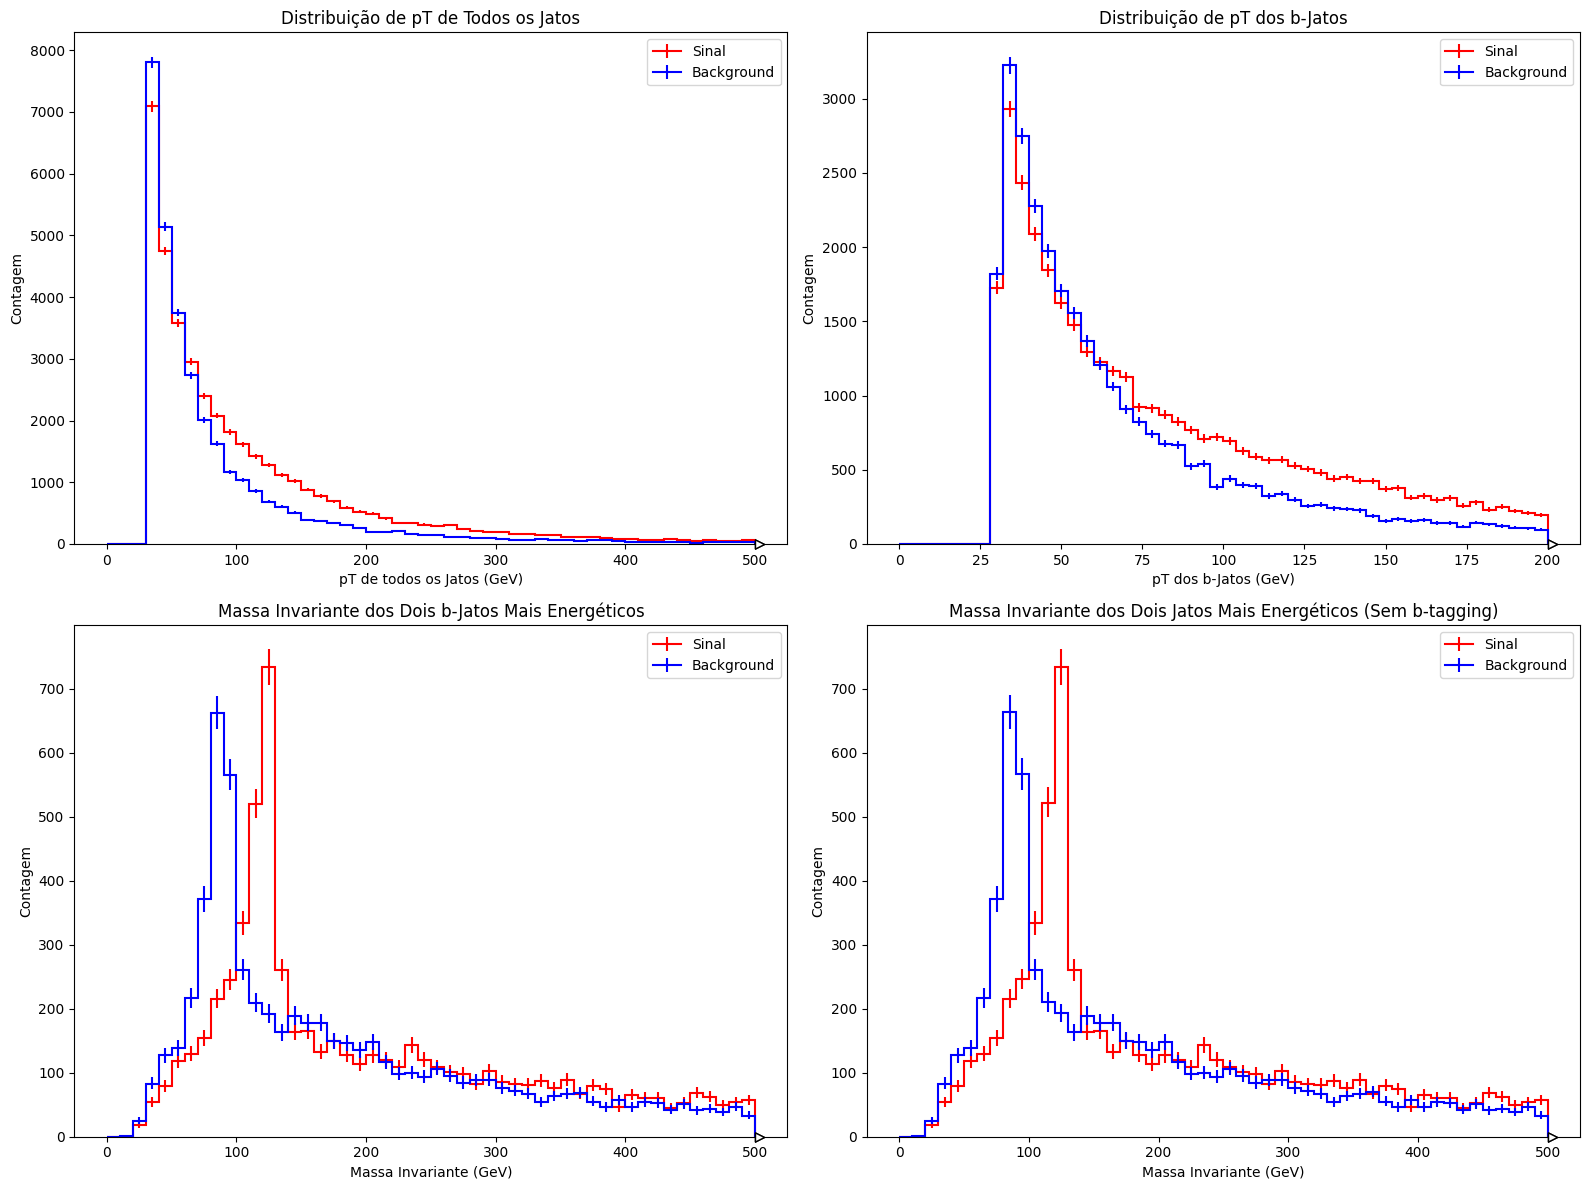

In [1]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj
import psutil
import os
import gc

# Função para verificar o uso de memória
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Limite máximo de eventos
max_events = 10000  # Total de eventos a serem processados
chunk_size = 500   # Eventos por chunk

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background_file = '/home/levi/Documentos/Sinal_background/pp_zz_background_nobornQCD.hepmc'

# Definir histogramas
histo_jets_pt_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_pt_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_pt_sinal = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt_bg = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()

# Função para ler eventos HEPMC em chunks
def read_hepmc_file_in_chunks(hepmc_file, max_events=max_events, chunk_size=chunk_size):
    events = []
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            events.append(event)
            if (i + 1) % chunk_size == 0:  # Processar chunk
                yield events
                events = []  # Limpar lista de eventos
                print(f"Eventos lidos: {i + 1}")
                print_memory_usage()
                gc.collect()  # Forçar liberação de memória
        if events:  # Processar eventos restantes
            yield events

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, particles, cone_radius=0.4):
    secondary_vertex_displacement = []
    for p in particles:
        if p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)
    if len(secondary_vertex_displacement) > 0:
        return np.mean(secondary_vertex_displacement) > 1.0
    return False

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para remover múons das partículas
def remove_muons(particles):
    return [p for p in particles if abs(p.pid) != 13]  # Múons têm PID ±13

# Função para processar eventos e preencher histogramas de jatos
def analyze_events(events, histo_all_jets, histo_bjets_pt, histo_bjets_mass, histo_jets_mass):
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis)
        particles = [p for p in event.particles if p.status == 1]
        
        # Remover múons das partículas
        particles_no_muons = remove_muons(particles)
        
        # Converter partículas para objetos PseudoJet do FastJet
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles_no_muons]
        
        # Definir o algoritmo de clustering (anti-kT, R = 0.4)
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        
        # Clusterizar as partículas em jatos
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        
        # Selecionar jatos com pT > 30 GeV
        jets = clusterer.inclusive_jets(30.0)
        
        # Preencher histograma de pT de todos os jatos
        for jet in jets:
            histo_all_jets.fill(jet.pt())
        
        # Filtrar jatos b-tagged
        b_jets = [jet for jet in jets if is_b_tagged(jet, particles_no_muons)]
        
        # Preencher histograma de pT dos jatos b-tagged
        for jet in b_jets:
            histo_bjets_pt.fill(jet.pt())
        
        # Selecionar os dois jatos de maior energia (b-tagged)
        if len(b_jets) >= 2:
            b_jets_sorted = sorted(b_jets, key=lambda j: j.e(), reverse=True)  # Ordenar por energia
            b_jets_selected = b_jets_sorted[:2]
            
            # Verificar se os jatos selecionados são realmente b-tagged
            if all(is_b_tagged(jet, particles_no_muons) for jet in b_jets_selected):
                # Calcular a massa invariante dos dois jatos b-tagged selecionados
                mass = invariant_mass(b_jets_selected[0], b_jets_selected[1])
                
                # Preencher histograma da massa invariante dos jatos b-tagged
                histo_bjets_mass.fill(mass)
        
        # Selecionar os dois jatos de maior energia (sem b-tagging)
        if len(jets) >= 2:
            jets_sorted = sorted(jets, key=lambda j: j.e(), reverse=True)  # Ordenar por energia
            jets_selected = jets_sorted[:2]
            
            # Calcular a massa invariante dos dois jatos selecionados
            mass = invariant_mass(jets_selected[0], jets_selected[1])
            
            # Preencher histograma da massa invariante dos jatos (sem b-tagging)
            histo_jets_mass.fill(mass)
        
        # Liberar memória após processar o evento
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, fj_particles, jets, b_jets  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Processar eventos de sinal em chunks
print("Processando eventos de sinal...")
for chunk in read_hepmc_file_in_chunks(sinal_file):
    analyze_events(chunk, histo_jets_pt_sinal, histo_bjets_pt_sinal, histo_bjets_mass_sinal, histo_jets_mass_sinal)

# Processar eventos de background em chunks
print("\nProcessando eventos de background...")
for chunk in read_hepmc_file_in_chunks(background_file):
    analyze_events(chunk, histo_jets_pt_bg, histo_bjets_pt_bg, histo_bjets_mass_bg, histo_jets_mass_bg)

# Plotar histogramas
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

# Histogramas de pT de todos os jatos
histo_jets_pt_sinal.plot(ax=ax[0, 0], label='Sinal', color='red')
histo_jets_pt_bg.plot(ax=ax[0, 0], label='Background', color='blue')
ax[0, 0].set(xlabel='pT de todos os Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT de Todos os Jatos')
ax[0, 0].legend()

# Histogramas de pT dos jatos b-tagging
histo_bjets_pt_sinal.plot(ax=ax[0, 1], label='Sinal', color='red')
histo_bjets_pt_bg.plot(ax=ax[0, 1], label='Background', color='blue')
ax[0, 1].set(xlabel='pT dos b-Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT dos b-Jatos')
ax[0, 1].legend()

# Histogramas da massa invariante dos dois b-jatos mais energéticos
histo_bjets_mass_sinal.plot(ax=ax[1, 0], label='Sinal', color='red')
histo_bjets_mass_bg.plot(ax=ax[1, 0], label='Background', color='blue')
ax[1, 0].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois b-Jatos Mais Energéticos')
ax[1, 0].legend()

# Histogramas da massa invariante dos dois jatos mais energéticos (sem b-tagging)
histo_jets_mass_sinal.plot(ax=ax[1, 1], label='Sinal', color='red')
histo_jets_mass_bg.plot(ax=ax[1, 1], label='Background', color='blue')
ax[1, 1].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois Jatos Mais Energéticos (Sem b-tagging)')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

Processando eventos de sinal...
#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
Eventos lidos: 500
Uso de memória: 806.

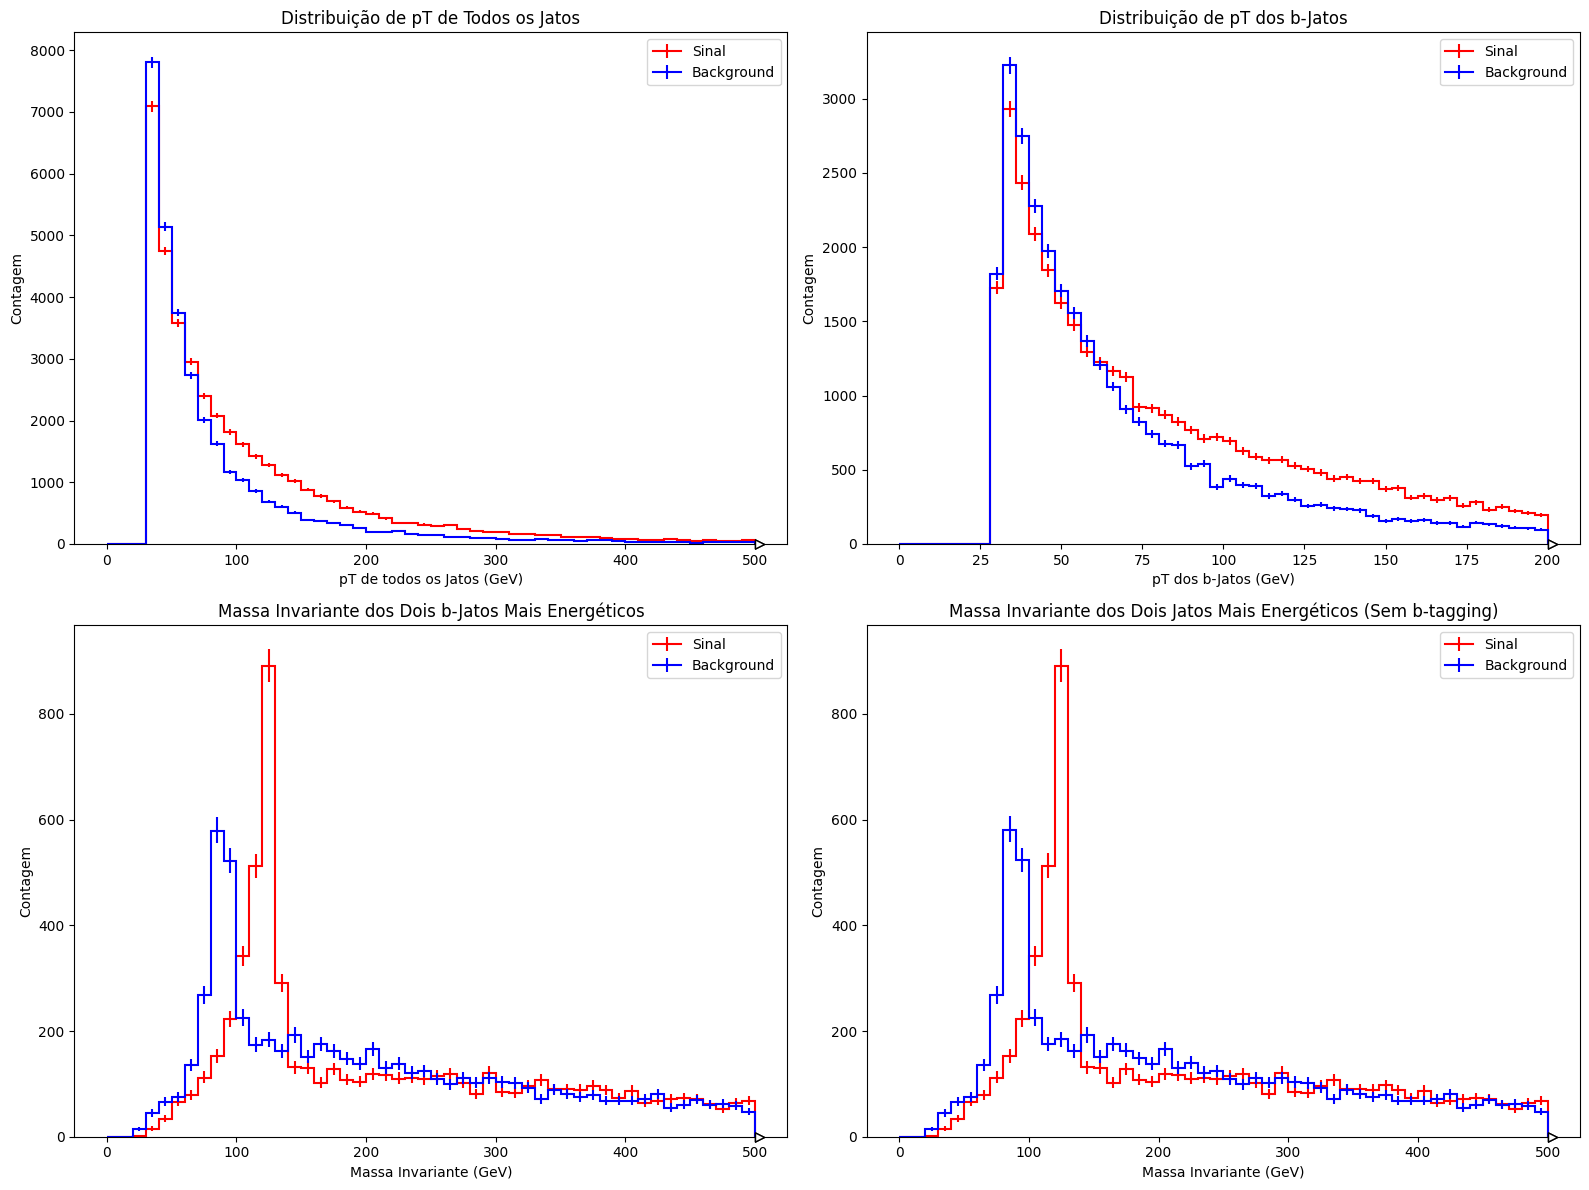

In [1]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj
import psutil
import os
import gc

# Função para verificar o uso de memória
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Limite máximo de eventos
max_events = 10000  # Total de eventos a serem processados
chunk_size = 500   # Eventos por chunk

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background_file = '/home/levi/Documentos/Sinal_background/pp_zz_background_nobornQCD.hepmc'

# Definir histogramas
histo_jets_pt_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_pt_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_pt_sinal = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt_bg = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()

# Função para ler eventos HEPMC em chunks
def read_hepmc_file_in_chunks(hepmc_file, max_events=max_events, chunk_size=chunk_size):
    events = []
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            events.append(event)
            if (i + 1) % chunk_size == 0:  # Processar chunk
                yield events
                events = []  # Limpar lista de eventos
                print(f"Eventos lidos: {i + 1}")
                print_memory_usage()
                gc.collect()  # Forçar liberação de memória
        if events:  # Processar eventos restantes
            yield events

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, particles, cone_radius=0.4):
    secondary_vertex_displacement = []
    for p in particles:
        if p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)
    if len(secondary_vertex_displacement) > 0:
        return np.mean(secondary_vertex_displacement) > 1.0
    return False

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para remover múons das partículas
def remove_muons(particles):
    return [p for p in particles if abs(p.pid) != 13]  # Múons têm PID ±13

# Função para processar eventos e preencher histogramas de jatos
def analyze_events(events, histo_all_jets, histo_bjets_pt, histo_bjets_mass, histo_jets_mass):
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis)
        particles = [p for p in event.particles if p.status == 1]
        
        # Remover múons das partículas
        particles_no_muons = remove_muons(particles)
        
        # Converter partículas para objetos PseudoJet do FastJet
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles_no_muons]
        
        # Definir o algoritmo de clustering (anti-kT, R = 0.4)
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        
        # Clusterizar as partículas em jatos
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        
        # Selecionar jatos com pT > 30 GeV
        jets = clusterer.inclusive_jets(30.0)
        
        # Preencher histograma de pT de todos os jatos
        for jet in jets:
            histo_all_jets.fill(jet.pt())
        
        # Filtrar jatos b-tagged
        b_jets = [jet for jet in jets if is_b_tagged(jet, particles_no_muons)]
        
        # Preencher histograma de pT dos jatos b-tagged
        for jet in b_jets:
            histo_bjets_pt.fill(jet.pt())
        
        # Selecionar os dois jatos de maior pT (b-tagged)
        if len(b_jets) >= 2:
            b_jets_sorted = sorted(b_jets, key=lambda j: j.pt(), reverse=True)  # Ordenar por pT
            b_jets_selected = b_jets_sorted[:2]
            
            # Verificar se os jatos selecionados são realmente b-tagged
            if all(is_b_tagged(jet, particles_no_muons) for jet in b_jets_selected):
                # Calcular a massa invariante dos dois jatos b-tagged selecionados
                mass = invariant_mass(b_jets_selected[0], b_jets_selected[1])
                
                # Preencher histograma da massa invariante dos jatos b-tagged
                histo_bjets_mass.fill(mass)
        
        # Selecionar os dois jatos de maior pT (sem b-tagging)
        if len(jets) >= 2:
            jets_sorted = sorted(jets, key=lambda j: j.pt(), reverse=True)  # Ordenar por pT
            jets_selected = jets_sorted[:2]
            
            # Calcular a massa invariante dos dois jatos selecionados
            mass = invariant_mass(jets_selected[0], jets_selected[1])
            
            # Preencher histograma da massa invariante dos jatos (sem b-tagging)
            histo_jets_mass.fill(mass)
        
        # Liberar memória após processar o evento
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, fj_particles, jets, b_jets  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Processar eventos de sinal em chunks
print("Processando eventos de sinal...")
for chunk in read_hepmc_file_in_chunks(sinal_file):
    analyze_events(chunk, histo_jets_pt_sinal, histo_bjets_pt_sinal, histo_bjets_mass_sinal, histo_jets_mass_sinal)

# Processar eventos de background em chunks
print("\nProcessando eventos de background...")
for chunk in read_hepmc_file_in_chunks(background_file):
    analyze_events(chunk, histo_jets_pt_bg, histo_bjets_pt_bg, histo_bjets_mass_bg, histo_jets_mass_bg)

# Plotar histogramas
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

# Histogramas de pT de todos os jatos
histo_jets_pt_sinal.plot(ax=ax[0, 0], label='Sinal', color='red')
histo_jets_pt_bg.plot(ax=ax[0, 0], label='Background', color='blue')
ax[0, 0].set(xlabel='pT de todos os Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT de Todos os Jatos')
ax[0, 0].legend()

# Histogramas de pT dos jatos b-tagging
histo_bjets_pt_sinal.plot(ax=ax[0, 1], label='Sinal', color='red')
histo_bjets_pt_bg.plot(ax=ax[0, 1], label='Background', color='blue')
ax[0, 1].set(xlabel='pT dos b-Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT dos b-Jatos')
ax[0, 1].legend()

# Histogramas da massa invariante dos dois b-jatos mais energéticos
histo_bjets_mass_sinal.plot(ax=ax[1, 0], label='Sinal', color='red')
histo_bjets_mass_bg.plot(ax=ax[1, 0], label='Background', color='blue')
ax[1, 0].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois b-Jatos Mais Energéticos')
ax[1, 0].legend()

# Histogramas da massa invariante dos dois jatos mais energéticos (sem b-tagging)
histo_jets_mass_sinal.plot(ax=ax[1, 1], label='Sinal', color='red')
histo_jets_mass_bg.plot(ax=ax[1, 1], label='Background', color='blue')
ax[1, 1].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois Jatos Mais Energéticos (Sem b-tagging)')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

Processando eventos de sinal...
Eventos lidos: 500
Uso de memória: 1794.18 MB
Eventos lidos: 1000
Uso de memória: 2413.82 MB
Eventos lidos: 1500
Uso de memória: 2415.88 MB
Eventos lidos: 2000
Uso de memória: 2477.46 MB
Eventos lidos: 2500
Uso de memória: 2481.43 MB
Eventos lidos: 3000
Uso de memória: 2491.93 MB
Eventos lidos: 3500
Uso de memória: 2492.73 MB
Eventos lidos: 4000
Uso de memória: 2494.54 MB
Eventos lidos: 4500
Uso de memória: 2496.24 MB
Eventos lidos: 5000
Uso de memória: 2499.33 MB
Eventos lidos: 5500
Uso de memória: 2506.03 MB
Eventos lidos: 6000
Uso de memória: 2506.80 MB
Eventos lidos: 6500
Uso de memória: 2511.69 MB
Eventos lidos: 7000
Uso de memória: 2527.65 MB
Eventos lidos: 7500
Uso de memória: 2528.21 MB
Eventos lidos: 8000
Uso de memória: 2529.00 MB
Eventos lidos: 8500
Uso de memória: 2530.03 MB
Eventos lidos: 9000
Uso de memória: 2530.03 MB
Eventos lidos: 9500
Uso de memória: 2531.32 MB
Eventos lidos: 10000
Uso de memória: 2531.32 MB

Processando eventos de back

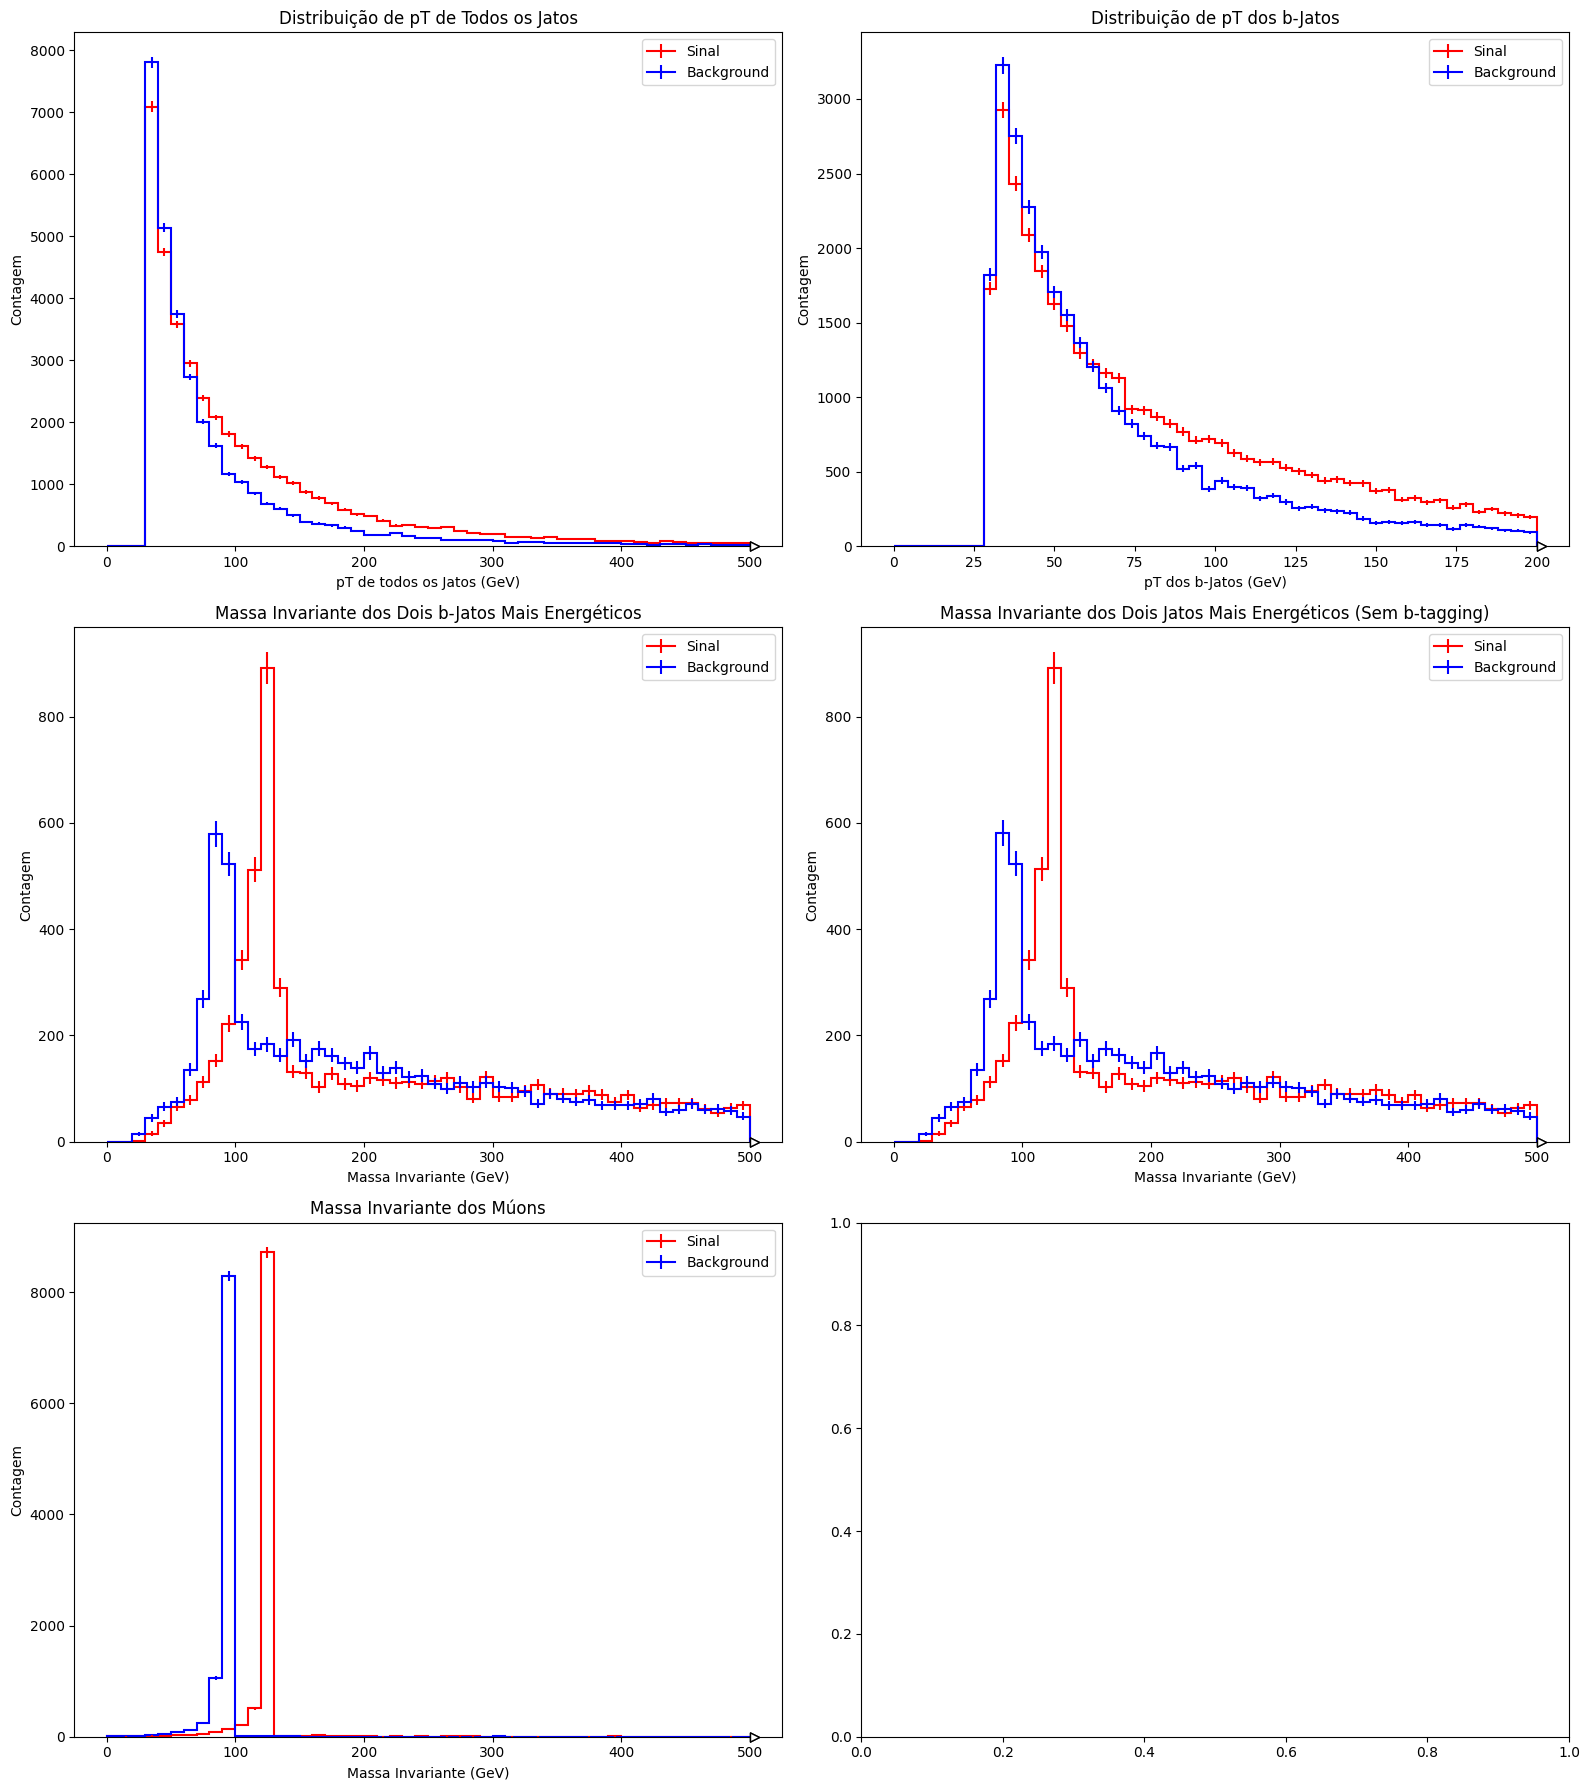

In [4]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj
import psutil
import os
import gc

# Função para verificar o uso de memória
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Limite máximo de eventos
max_events = 10000  # Total de eventos a serem processados
chunk_size = 500   # Eventos por chunk

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background_file = '/home/levi/Documentos/Sinal_background/pp_zz_background_nobornQCD.hepmc'

# Definir histogramas
histo_jets_pt_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_pt_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_pt_sinal = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt_bg = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_muons_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_muons_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()

# Função para ler eventos HEPMC em chunks
def read_hepmc_file_in_chunks(hepmc_file, max_events=max_events, chunk_size=chunk_size):
    events = []
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            events.append(event)
            if (i + 1) % chunk_size == 0:  # Processar chunk
                yield events
                events = []  # Limpar lista de eventos
                print(f"Eventos lidos: {i + 1}")
                print_memory_usage()
                gc.collect()  # Forçar liberação de memória
        if events:  # Processar eventos restantes
            yield events

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, particles, cone_radius=0.4):
    secondary_vertex_displacement = []
    for p in particles:
        if p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)
    if len(secondary_vertex_displacement) > 0:
        return np.mean(secondary_vertex_displacement) > 1.0
    return False

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para remover múons das partículas
def remove_muons(particles):
    return [p for p in particles if abs(p.pid) != 13]  # Múons têm PID ±13

# Função para identificar múons com cargas opostas e de mesmo sabor
def find_opposite_charge_muons(particles):
    muons = []
    for p in particles:
        if abs(p.pid) == 13:  # Múons têm PID ±13
            muons.append(p)
    
    # Selecionar pares de múons com cargas opostas
    muon_pairs = []
    for i in range(len(muons)):
        for j in range(i + 1, len(muons)):
            if muons[i].pid == -muons[j].pid:  # Cargas opostas
                muon_pairs.append((muons[i], muons[j]))
    
    return muon_pairs

# Função para processar eventos e preencher histograma de múons
def analyze_muons(events, histo_muons_mass):
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis)
        particles = [p for p in event.particles if p.status == 1]
        
        # Identificar pares de múons com cargas opostas
        muon_pairs = find_opposite_charge_muons(particles)
        
        if len(muon_pairs) >= 1:
            # Selecionar o par de múons com maior soma de pT
            selected_pair = max(muon_pairs, key=lambda pair: pair[0].momentum.pt() + pair[1].momentum.pt())
            
            # Criar objetos PseudoJet para os múons
            muon1 = fj.PseudoJet(selected_pair[0].momentum.x, selected_pair[0].momentum.y, selected_pair[0].momentum.z, selected_pair[0].momentum.e)
            muon2 = fj.PseudoJet(selected_pair[1].momentum.x, selected_pair[1].momentum.y, selected_pair[1].momentum.z, selected_pair[1].momentum.e)
            
            # Calcular a massa invariante
            mass = invariant_mass(muon1, muon2)
            
            # Preencher histograma da massa invariante
            histo_muons_mass.fill(mass)

# Função para processar eventos e preencher histogramas de jatos
def analyze_events(events, histo_all_jets, histo_bjets_pt, histo_bjets_mass, histo_jets_mass):
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis)
        particles = [p for p in event.particles if p.status == 1]
        
        # Remover múons das partículas
        particles_no_muons = remove_muons(particles)
        
        # Converter partículas para objetos PseudoJet do FastJet
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles_no_muons]
        
        # Definir o algoritmo de clustering (anti-kT, R = 0.4)
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        
        # Clusterizar as partículas em jatos
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        
        # Selecionar jatos com pT > 30 GeV
        jets = clusterer.inclusive_jets(30.0)
        
        # Preencher histograma de pT de todos os jatos
        for jet in jets:
            histo_all_jets.fill(jet.pt())
        
        # Filtrar jatos b-tagged
        b_jets = [jet for jet in jets if is_b_tagged(jet, particles_no_muons)]
        
        # Preencher histograma de pT dos jatos b-tagged
        for jet in b_jets:
            histo_bjets_pt.fill(jet.pt())
        
        # Selecionar os dois jatos de maior pT (b-tagged)
        if len(b_jets) >= 2:
            b_jets_sorted = sorted(b_jets, key=lambda j: j.pt(), reverse=True)  # Ordenar por pT
            b_jets_selected = b_jets_sorted[:2]
            
            # Verificar se os jatos selecionados são realmente b-tagged
            if all(is_b_tagged(jet, particles_no_muons) for jet in b_jets_selected):
                # Calcular a massa invariante dos dois jatos b-tagged selecionados
                mass = invariant_mass(b_jets_selected[0], b_jets_selected[1])
                
                # Preencher histograma da massa invariante dos jatos b-tagged
                histo_bjets_mass.fill(mass)
        
        # Selecionar os dois jatos de maior pT (sem b-tagging)
        if len(jets) >= 2:
            jets_sorted = sorted(jets, key=lambda j: j.pt(), reverse=True)  # Ordenar por pT
            jets_selected = jets_sorted[:2]
            
            # Calcular a massa invariante dos dois jatos selecionados
            mass = invariant_mass(jets_selected[0], jets_selected[1])
            
            # Preencher histograma da massa invariante dos jatos (sem b-tagging)
            histo_jets_mass.fill(mass)
        
        # Liberar memória após processar o evento
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, fj_particles, jets, b_jets  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Processar eventos de sinal em chunks
print("Processando eventos de sinal...")
for chunk in read_hepmc_file_in_chunks(sinal_file):
    analyze_events(chunk, histo_jets_pt_sinal, histo_bjets_pt_sinal, histo_bjets_mass_sinal, histo_jets_mass_sinal)
    analyze_muons(chunk, histo_muons_mass_sinal)

# Processar eventos de background em chunks
print("\nProcessando eventos de background...")
for chunk in read_hepmc_file_in_chunks(background_file):
    analyze_events(chunk, histo_jets_pt_bg, histo_bjets_pt_bg, histo_bjets_mass_bg, histo_jets_mass_bg)
    analyze_muons(chunk, histo_muons_mass_bg)

# Plotar histogramas
fig, ax = plt.subplots(3, 2, figsize=(16, 18))

# Histogramas de pT de todos os jatos
histo_jets_pt_sinal.plot(ax=ax[0, 0], label='Sinal', color='red')
histo_jets_pt_bg.plot(ax=ax[0, 0], label='Background', color='blue')
ax[0, 0].set(xlabel='pT de todos os Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT de Todos os Jatos')
ax[0, 0].legend()

# Histogramas de pT dos jatos b-tagging
histo_bjets_pt_sinal.plot(ax=ax[0, 1], label='Sinal', color='red')
histo_bjets_pt_bg.plot(ax=ax[0, 1], label='Background', color='blue')
ax[0, 1].set(xlabel='pT dos b-Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT dos b-Jatos')
ax[0, 1].legend()

# Histogramas da massa invariante dos dois b-jatos mais energéticos
histo_bjets_mass_sinal.plot(ax=ax[1, 0], label='Sinal', color='red')
histo_bjets_mass_bg.plot(ax=ax[1, 0], label='Background', color='blue')
ax[1, 0].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois b-Jatos Mais Energéticos')
ax[1, 0].legend()

# Histogramas da massa invariante dos dois jatos mais energéticos (sem b-tagging)
histo_jets_mass_sinal.plot(ax=ax[1, 1], label='Sinal', color='red')
histo_jets_mass_bg.plot(ax=ax[1, 1], label='Background', color='blue')
ax[1, 1].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois Jatos Mais Energéticos (Sem b-tagging)')
ax[1, 1].legend()

# Histogramas da massa invariante dos múons
histo_muons_mass_sinal.plot(ax=ax[2, 0], label='Sinal', color='red')
histo_muons_mass_bg.plot(ax=ax[2, 0], label='Background', color='blue')
ax[2, 0].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Múons')
ax[2, 0].legend()

plt.tight_layout()
plt.show()

Processando eventos de sinal...
Eventos lidos: 500
Uso de memória: 2535.71 MB
Eventos lidos: 1000
Uso de memória: 2535.55 MB
Eventos lidos: 1500
Uso de memória: 2535.55 MB
Eventos lidos: 2000
Uso de memória: 2535.32 MB
Eventos lidos: 2500
Uso de memória: 2533.17 MB
Eventos lidos: 3000
Uso de memória: 2532.97 MB
Eventos lidos: 3500
Uso de memória: 2532.73 MB
Eventos lidos: 4000
Uso de memória: 2532.73 MB
Eventos lidos: 4500
Uso de memória: 2532.70 MB
Eventos lidos: 5000
Uso de memória: 2536.04 MB
Eventos lidos: 5500
Uso de memória: 2536.19 MB
Eventos lidos: 6000
Uso de memória: 2536.62 MB
Eventos lidos: 6500
Uso de memória: 2536.88 MB
Eventos lidos: 7000
Uso de memória: 2541.28 MB
Eventos lidos: 7500
Uso de memória: 2540.92 MB
Eventos lidos: 8000
Uso de memória: 2541.18 MB
Eventos lidos: 8500
Uso de memória: 2541.43 MB
Eventos lidos: 9000
Uso de memória: 2541.41 MB
Eventos lidos: 9500
Uso de memória: 2541.41 MB
Eventos lidos: 10000
Uso de memória: 2541.41 MB

Processando eventos de back

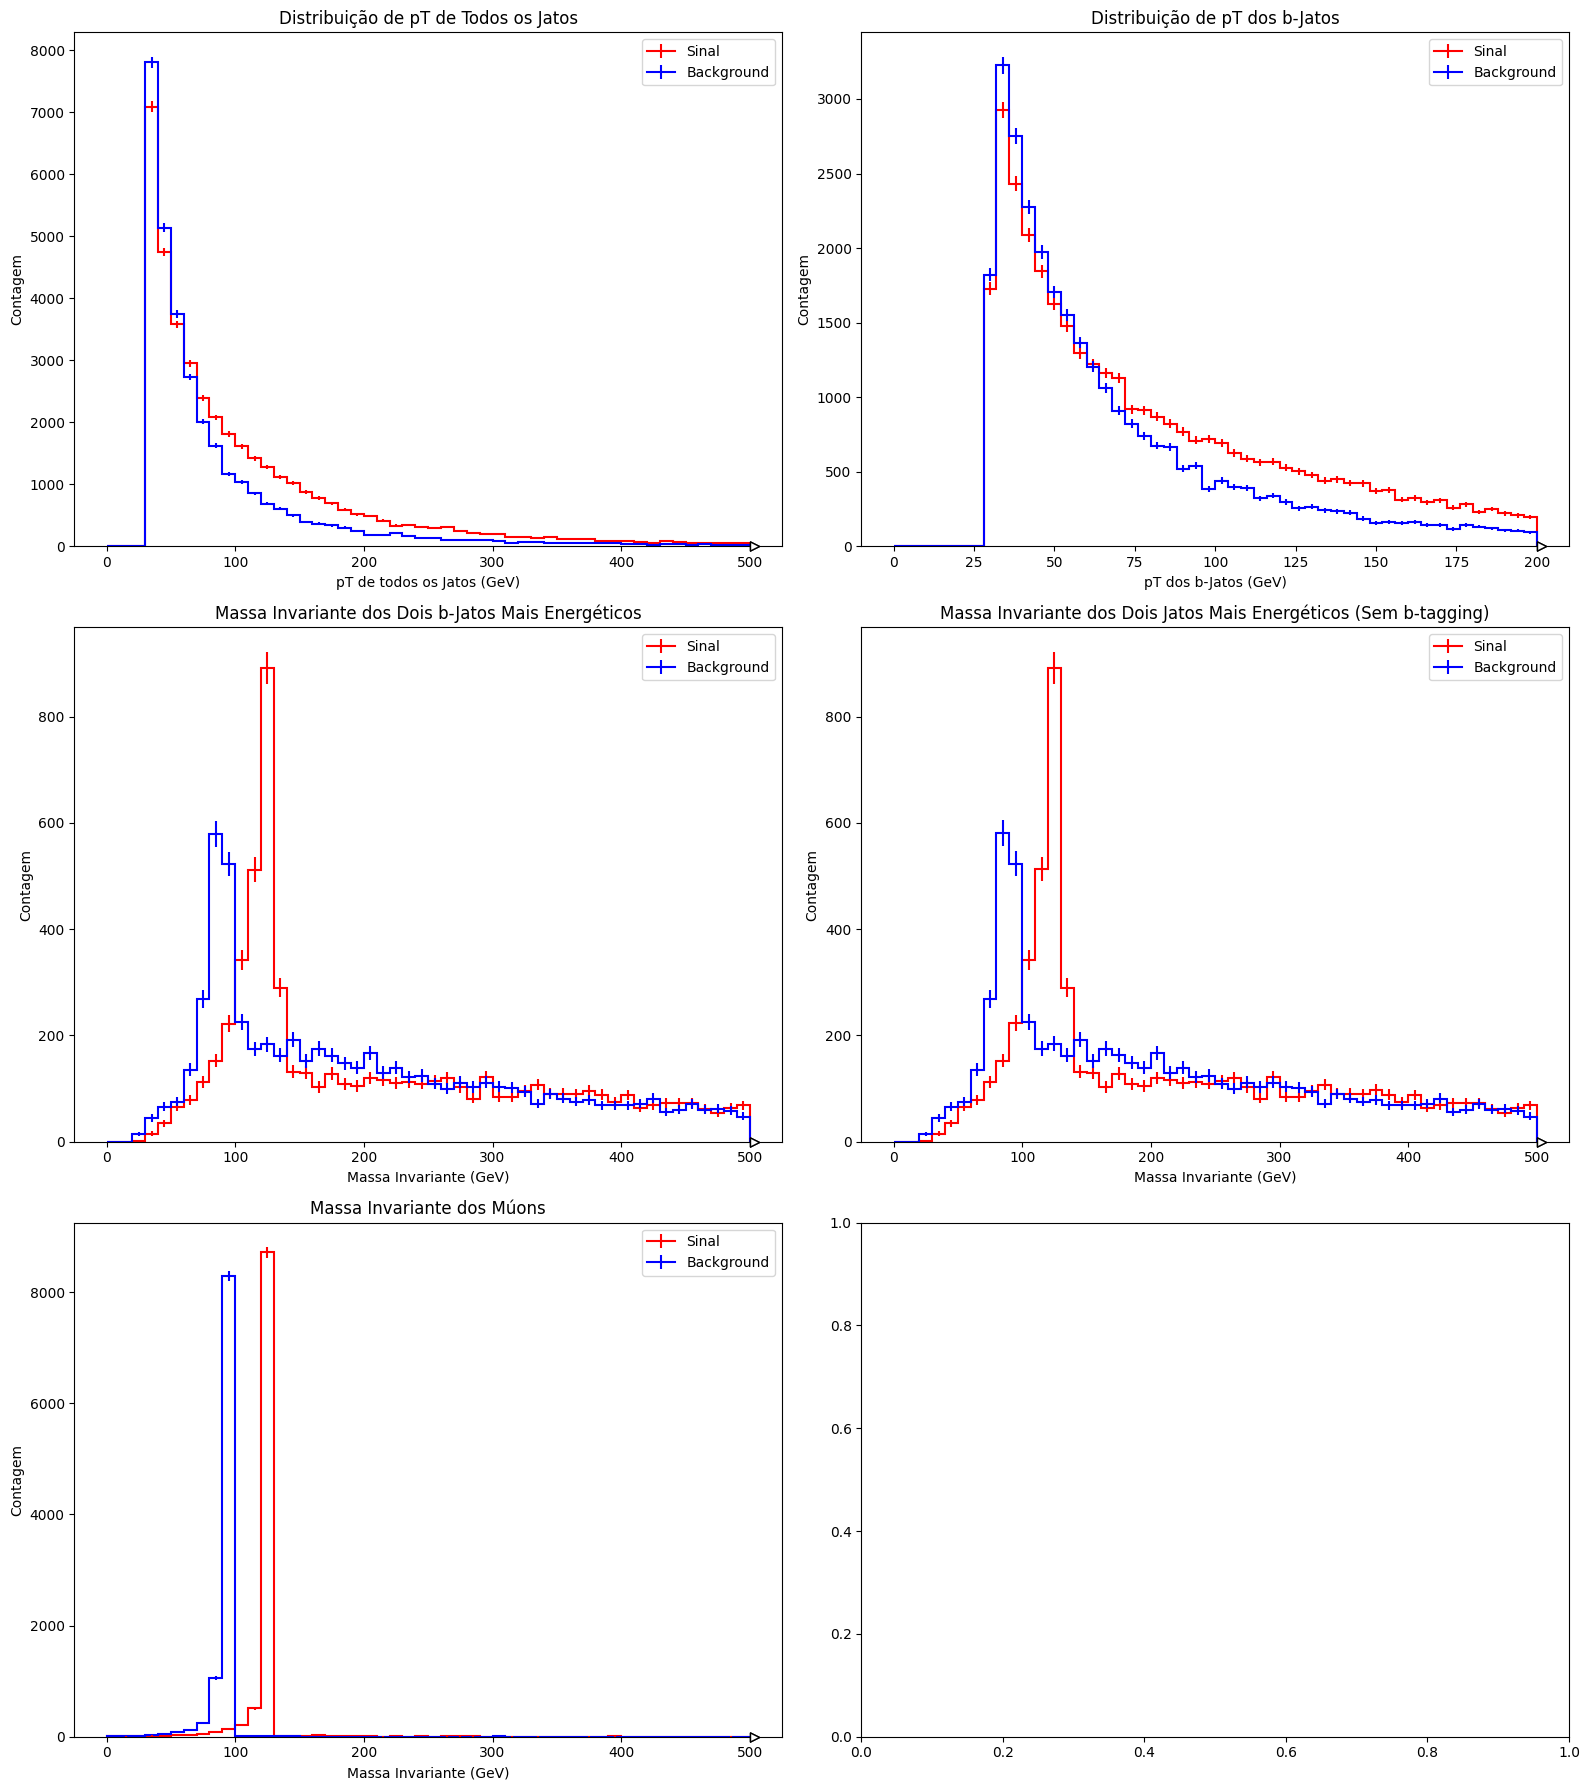

In [5]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj
import psutil
import os
import gc

# Função para verificar o uso de memória
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Limite máximo de eventos
max_events = 10000  # Total de eventos a serem processados
chunk_size = 500   # Eventos por chunk

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background_file = '/home/levi/Documentos/Sinal_background/pp_zz_background_nobornQCD.hepmc'

# Definir histogramas
histo_jets_pt_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_pt_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_pt_sinal = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt_bg = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_muons_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_muons_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()

# Função para ler eventos HEPMC em chunks
def read_hepmc_file_in_chunks(hepmc_file, max_events=max_events, chunk_size=chunk_size):
    events = []
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            events.append(event)
            if (i + 1) % chunk_size == 0:  # Processar chunk
                yield events
                events = []  # Limpar lista de eventos
                print(f"Eventos lidos: {i + 1}")
                print_memory_usage()
                gc.collect()  # Forçar liberação de memória
        if events:  # Processar eventos restantes
            yield events

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, particles, cone_radius=0.4):
    secondary_vertex_displacement = []
    for p in particles:
        if p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)
    if len(secondary_vertex_displacement) > 0:
        return np.mean(secondary_vertex_displacement) > 1.0
    return False

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para remover múons das partículas
def remove_muons(particles):
    return [p for p in particles if abs(p.pid) != 13]  # Múons têm PID ±13

# Função para identificar múons com cargas opostas e de mesmo sabor
def find_opposite_charge_muons(particles):
    muons = []
    for p in particles:
        if abs(p.pid) == 13:  # Múons têm PID ±13
            muons.append(p)
    
    # Selecionar pares de múons com cargas opostas
    muon_pairs = []
    for i in range(len(muons)):
        for j in range(i + 1, len(muons)):
            if muons[i].pid == -muons[j].pid:  # Cargas opostas
                muon_pairs.append((muons[i], muons[j]))
    
    return muon_pairs

# Função para processar eventos e preencher histograma de múons
def analyze_muons(events, histo_muons_mass):
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis)
        particles = [p for p in event.particles if p.status == 1]
        
        # Identificar pares de múons com cargas opostas
        muon_pairs = find_opposite_charge_muons(particles)
        
        if len(muon_pairs) >= 1:
            # Selecionar o par de múons com maior soma de pT
            selected_pair = max(muon_pairs, key=lambda pair: pair[0].momentum.pt() + pair[1].momentum.pt())
            
            # Criar objetos PseudoJet para os múons
            muon1 = fj.PseudoJet(selected_pair[0].momentum.x, selected_pair[0].momentum.y, selected_pair[0].momentum.z, selected_pair[0].momentum.e)
            muon2 = fj.PseudoJet(selected_pair[1].momentum.x, selected_pair[1].momentum.y, selected_pair[1].momentum.z, selected_pair[1].momentum.e)
            
            # Calcular a massa invariante
            mass = invariant_mass(muon1, muon2)
            
            # Preencher histograma da massa invariante
            histo_muons_mass.fill(mass)

# Função para processar eventos e preencher histogramas de jatos
def analyze_events(events, histo_all_jets, histo_bjets_pt, histo_bjets_mass, histo_jets_mass):
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis)
        particles = [p for p in event.particles if p.status == 1]
        
        # Remover múons das partículas
        particles_no_muons = remove_muons(particles)
        
        # Identificar pares de múons com cargas opostas e de maior pT
        muon_pairs = find_opposite_charge_muons(particles)
        if muon_pairs:
            # Selecionar o par de múons com maior soma de pT
            selected_pair = max(muon_pairs, key=lambda pair: pair[0].momentum.pt() + pair[1].momentum.pt())
            
            # Remover esses múons da lista de partículas
            particles_no_muons = [p for p in particles_no_muons if p not in selected_pair]
        
        # Converter partículas para objetos PseudoJet do FastJet
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles_no_muons]
        
        # Definir o algoritmo de clustering (anti-kT, R = 0.4)
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        
        # Clusterizar as partículas em jatos
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        
        # Selecionar jatos com pT > 30 GeV
        jets = clusterer.inclusive_jets(30.0)
        
        # Preencher histograma de pT de todos os jatos
        for jet in jets:
            histo_all_jets.fill(jet.pt())
        
        # Filtrar jatos b-tagged
        b_jets = [jet for jet in jets if is_b_tagged(jet, particles_no_muons)]
        
        # Preencher histograma de pT dos jatos b-tagged
        for jet in b_jets:
            histo_bjets_pt.fill(jet.pt())
        
        # Selecionar os dois jatos de maior pT (b-tagged)
        if len(b_jets) >= 2:
            b_jets_sorted = sorted(b_jets, key=lambda j: j.pt(), reverse=True)  # Ordenar por pT
            b_jets_selected = b_jets_sorted[:2]
            
            # Verificar se os jatos selecionados são realmente b-tagged
            if all(is_b_tagged(jet, particles_no_muons) for jet in b_jets_selected):
                # Calcular a massa invariante dos dois jatos b-tagged selecionados
                mass = invariant_mass(b_jets_selected[0], b_jets_selected[1])
                
                # Preencher histograma da massa invariante dos jatos b-tagged
                histo_bjets_mass.fill(mass)
        
        # Selecionar os dois jatos de maior pT (sem b-tagging)
        if len(jets) >= 2:
            jets_sorted = sorted(jets, key=lambda j: j.pt(), reverse=True)  # Ordenar por pT
            jets_selected = jets_sorted[:2]
            
            # Calcular a massa invariante dos dois jatos selecionados
            mass = invariant_mass(jets_selected[0], jets_selected[1])
            
            # Preencher histograma da massa invariante dos jatos (sem b-tagging)
            histo_jets_mass.fill(mass)
        
        # Liberar memória após processar o evento
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, fj_particles, jets, b_jets  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Processar eventos de sinal em chunks
print("Processando eventos de sinal...")
for chunk in read_hepmc_file_in_chunks(sinal_file):
    analyze_events(chunk, histo_jets_pt_sinal, histo_bjets_pt_sinal, histo_bjets_mass_sinal, histo_jets_mass_sinal)
    analyze_muons(chunk, histo_muons_mass_sinal)

# Processar eventos de background em chunks
print("\nProcessando eventos de background...")
for chunk in read_hepmc_file_in_chunks(background_file):
    analyze_events(chunk, histo_jets_pt_bg, histo_bjets_pt_bg, histo_bjets_mass_bg, histo_jets_mass_bg)
    analyze_muons(chunk, histo_muons_mass_bg)

# Plotar histogramas
fig, ax = plt.subplots(3, 2, figsize=(16, 18))

# Histogramas de pT de todos os jatos
histo_jets_pt_sinal.plot(ax=ax[0, 0], label='Sinal', color='red')
histo_jets_pt_bg.plot(ax=ax[0, 0], label='Background', color='blue')
ax[0, 0].set(xlabel='pT de todos os Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT de Todos os Jatos')
ax[0, 0].legend()

# Histogramas de pT dos jatos b-tagging
histo_bjets_pt_sinal.plot(ax=ax[0, 1], label='Sinal', color='red')
histo_bjets_pt_bg.plot(ax=ax[0, 1], label='Background', color='blue')
ax[0, 1].set(xlabel='pT dos b-Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT dos b-Jatos')
ax[0, 1].legend()

# Histogramas da massa invariante dos dois b-jatos mais energéticos
histo_bjets_mass_sinal.plot(ax=ax[1, 0], label='Sinal', color='red')
histo_bjets_mass_bg.plot(ax=ax[1, 0], label='Background', color='blue')
ax[1, 0].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois b-Jatos Mais Energéticos')
ax[1, 0].legend()

# Histogramas da massa invariante dos dois jatos mais energéticos (sem b-tagging)
histo_jets_mass_sinal.plot(ax=ax[1, 1], label='Sinal', color='red')
histo_jets_mass_bg.plot(ax=ax[1, 1], label='Background', color='blue')
ax[1, 1].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois Jatos Mais Energéticos (Sem b-tagging)')
ax[1, 1].legend()

# Histogramas da massa invariante dos múons
histo_muons_mass_sinal.plot(ax=ax[2, 0], label='Sinal', color='red')
histo_muons_mass_bg.plot(ax=ax[2, 0], label='Background', color='blue')
ax[2, 0].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Múons')
ax[2, 0].legend()

plt.tight_layout()
plt.show()

# background_pp>jjmumu

Processando eventos de sinal...
Eventos processados: 1000
Uso de memória: 2399.27 MB
Eventos processados: 1000
Uso de memória: 2399.27 MB
Eventos lidos: 1000
Uso de memória: 2399.27 MB
Eventos processados: 1000
Uso de memória: 3125.94 MB
Eventos processados: 1000
Uso de memória: 3125.94 MB
Eventos lidos: 2000
Uso de memória: 3125.94 MB
Eventos processados: 1000
Uso de memória: 3185.90 MB
Eventos processados: 1000
Uso de memória: 3185.90 MB
Eventos lidos: 3000
Uso de memória: 3185.90 MB
Eventos processados: 1000
Uso de memória: 3266.93 MB
Eventos processados: 1000
Uso de memória: 3266.93 MB
Eventos lidos: 4000
Uso de memória: 3266.93 MB
Eventos processados: 1000
Uso de memória: 3280.75 MB
Eventos processados: 1000
Uso de memória: 3280.75 MB
Eventos lidos: 5000
Uso de memória: 3280.75 MB
Eventos processados: 1000
Uso de memória: 3313.39 MB
Eventos processados: 1000
Uso de memória: 3313.39 MB
Eventos lidos: 6000
Uso de memória: 3313.39 MB
Eventos processados: 1000
Uso de memória: 3334.67 

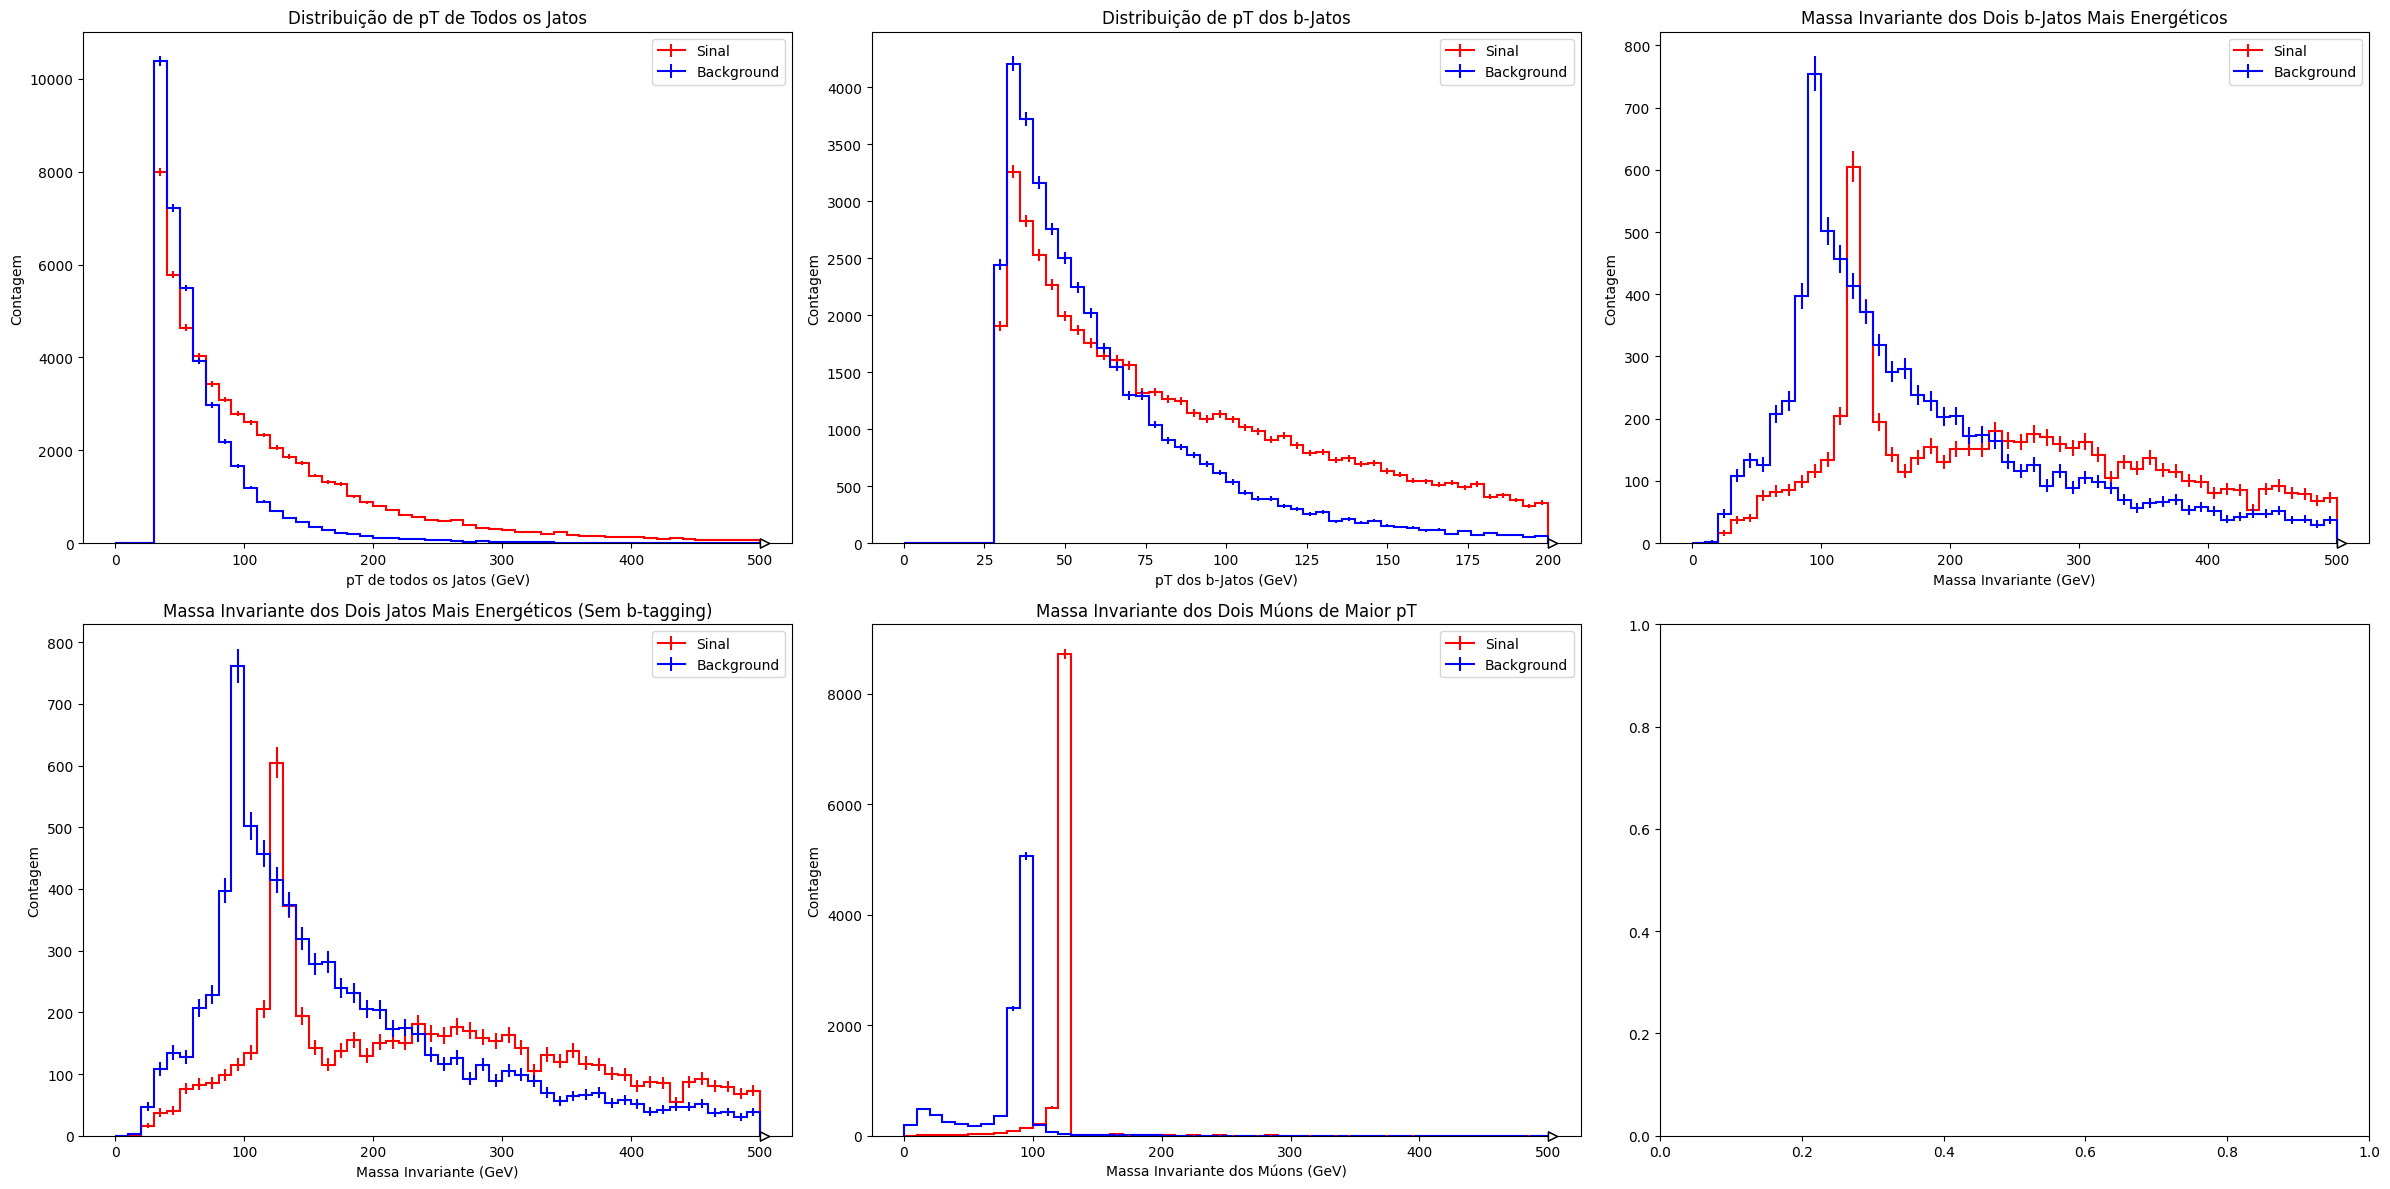

In [2]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj
import psutil
import os
import gc

# Função para verificar o uso de memória
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Limite máximo de eventos
max_events = 10000  # Total de eventos a serem processados
chunk_size = 1000   # Eventos por chunk

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background_file = '/home/levi/Documentos/Sinal_background/background_pp_jjmumu.hepmc'

# Definir histogramas
histo_jets_pt_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_pt_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_pt_sinal = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt_bg = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()  # Novo histograma
histo_jets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()      # Novo histograma
histo_muons_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_muons_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()

# Função para ler eventos HEPMC em chunks
def read_hepmc_file_in_chunks(hepmc_file, max_events=max_events, chunk_size=chunk_size):
    events = []
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            events.append(event)
            if (i + 1) % chunk_size == 0:  # Processar chunk
                yield events
                events = []  # Limpar lista de eventos
                print(f"Eventos lidos: {i + 1}")
                print_memory_usage()
                gc.collect()  # Forçar liberação de memória
        if events:  # Processar eventos restantes
            yield events

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, particles, cone_radius=0.4):
    secondary_vertex_displacement = []
    for p in particles:
        if p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)
    if len(secondary_vertex_displacement) > 0:
        return np.mean(secondary_vertex_displacement) > 1.0
    return False

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para processar eventos e preencher histogramas de jatos
def analyze_events(events, histo_all_jets, histo_bjets_pt, histo_bjets_mass, histo_jets_mass):
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis)
        particles = [p for p in event.particles if p.status == 1]
        
        # Converter partículas para objetos PseudoJet do FastJet
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles]
        
        # Definir o algoritmo de clustering (anti-kT, R = 0.4)
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        
        # Clusterizar as partículas em jatos
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        
        # Selecionar jatos com pT > 30 GeV
        jets = clusterer.inclusive_jets(30.0)
        
        # Preencher histograma de pT de todos os jatos
        for jet in jets:
            histo_all_jets.fill(jet.pt())
        
        # Filtrar jatos b-tagged
        b_jets = [jet for jet in jets if is_b_tagged(jet, particles)]
        
        # Preencher histograma de pT dos jatos b-tagged
        for jet in b_jets:
            histo_bjets_pt.fill(jet.pt())
        
        # Selecionar os dois jatos de maior energia (b-tagged)
        if len(b_jets) >= 2:
            b_jets_sorted = sorted(b_jets, key=lambda j: j.e(), reverse=True)  # Ordenar por energia
            b_jets_selected = b_jets_sorted[:2]
            
            # Verificar se os jatos selecionados são realmente b-tagged
            if all(is_b_tagged(jet, particles) for jet in b_jets_selected):
                # Calcular a massa invariante dos dois jatos b-tagged selecionados
                mass = invariant_mass(b_jets_selected[0], b_jets_selected[1])
                
                # Preencher histograma da massa invariante dos jatos b-tagged
                histo_bjets_mass.fill(mass)
        
        # Selecionar os dois jatos de maior energia (sem b-tagging)
        if len(jets) >= 2:
            jets_sorted = sorted(jets, key=lambda j: j.e(), reverse=True)  # Ordenar por energia
            jets_selected = jets_sorted[:2]
            
            # Calcular a massa invariante dos dois jatos selecionados
            mass = invariant_mass(jets_selected[0], jets_selected[1])
            
            # Preencher histograma da massa invariante dos jatos (sem b-tagging)
            histo_jets_mass.fill(mass)
        
        # Liberar memória após processar o evento
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, fj_particles, jets, b_jets  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Função para identificar múons com cargas opostas e de mesmo sabor
def find_opposite_charge_muons(particles):
    muons = []
    for p in particles:
        if abs(p.pid) == 13:  # Múons têm PID ±13
            muons.append(p)
    
    # Selecionar pares de múons com cargas opostas
    muon_pairs = []
    for i in range(len(muons)):
        for j in range(i + 1, len(muons)):
            if muons[i].pid == -muons[j].pid:  # Cargas opostas
                muon_pairs.append((muons[i], muons[j]))
    
    return muon_pairs

# Função para processar eventos e preencher histograma de múons
def analyze_muons(events, histo_muons_mass):
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis)
        particles = [p for p in event.particles if p.status == 1]
        
        # Identificar pares de múons com cargas opostas
        muon_pairs = find_opposite_charge_muons(particles)
        
        if len(muon_pairs) >= 1:
            # Selecionar o par de múons com maior soma de pT
            selected_pair = max(muon_pairs, key=lambda pair: pair[0].momentum.pt() + pair[1].momentum.pt())
            
            # Criar objetos PseudoJet para os múons
            muon1 = fj.PseudoJet(selected_pair[0].momentum.x, selected_pair[0].momentum.y, selected_pair[0].momentum.z, selected_pair[0].momentum.e)
            muon2 = fj.PseudoJet(selected_pair[1].momentum.x, selected_pair[1].momentum.y, selected_pair[1].momentum.z, selected_pair[1].momentum.e)
            
            # Calcular a massa invariante
            mass = invariant_mass(muon1, muon2)
            
            # Preencher histograma da massa invariante
            histo_muons_mass.fill(mass)
        
        # Liberar memória após processar o evento
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, muon_pairs, selected_pair, muon1, muon2  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Processar eventos de sinal em chunks
print("Processando eventos de sinal...")
for chunk in read_hepmc_file_in_chunks(sinal_file):
    analyze_events(chunk, histo_jets_pt_sinal, histo_bjets_pt_sinal, histo_bjets_mass_sinal, histo_jets_mass_sinal)
    analyze_muons(chunk, histo_muons_mass_sinal)

# Processar eventos de background em chunks
print("\nProcessando eventos de background...")
for chunk in read_hepmc_file_in_chunks(background_file):
    analyze_events(chunk, histo_jets_pt_bg, histo_bjets_pt_bg, histo_bjets_mass_bg, histo_jets_mass_bg)
    analyze_muons(chunk, histo_muons_mass_bg)

# Plotar histogramas
fig, ax = plt.subplots(2, 3, figsize=(24, 12))

# Histogramas de pT de todos os jatos
histo_jets_pt_sinal.plot(ax=ax[0, 0], label='Sinal', color='red')
histo_jets_pt_bg.plot(ax=ax[0, 0], label='Background', color='blue')
ax[0, 0].set(xlabel='pT de todos os Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT de Todos os Jatos')
ax[0, 0].legend()

# Histogramas de pT dos jatos b-tagging
histo_bjets_pt_sinal.plot(ax=ax[0, 1], label='Sinal', color='red')
histo_bjets_pt_bg.plot(ax=ax[0, 1], label='Background', color='blue')
ax[0, 1].set(xlabel='pT dos b-Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT dos b-Jatos')
ax[0, 1].legend()

# Histogramas da massa invariante dos dois b-jatos mais energéticos
histo_bjets_mass_sinal.plot(ax=ax[0, 2], label='Sinal', color='red')
histo_bjets_mass_bg.plot(ax=ax[0, 2], label='Background', color='blue')
ax[0, 2].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois b-Jatos Mais Energéticos')
ax[0, 2].legend()

# Histogramas da massa invariante dos dois jatos mais energéticos (sem b-tagging)
histo_jets_mass_sinal.plot(ax=ax[1, 0], label='Sinal', color='red')
histo_jets_mass_bg.plot(ax=ax[1, 0], label='Background', color='blue')
ax[1, 0].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois Jatos Mais Energéticos (Sem b-tagging)')
ax[1, 0].legend()

# Histograma da massa invariante dos dois múons de maior pT
histo_muons_mass_sinal.plot(ax=ax[1, 1], label='Sinal', color='red')
histo_muons_mass_bg.plot(ax=ax[1, 1], label='Background', color='blue')
ax[1, 1].set(xlabel='Massa Invariante dos Múons (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois Múons de Maior pT')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

Processando eventos de sinal...
Eventos lidos: 500
Uso de memória: 3342.46 MB
Eventos lidos: 1000
Uso de memória: 3338.68 MB
Eventos lidos: 1500
Uso de memória: 3334.29 MB
Eventos lidos: 2000
Uso de memória: 3326.86 MB
Eventos lidos: 2500
Uso de memória: 3326.86 MB
Eventos lidos: 3000
Uso de memória: 3326.86 MB
Eventos lidos: 3500
Uso de memória: 3326.73 MB
Eventos lidos: 4000
Uso de memória: 3326.73 MB
Eventos lidos: 4500
Uso de memória: 3326.73 MB
Eventos lidos: 5000
Uso de memória: 3326.73 MB
Eventos lidos: 5500
Uso de memória: 3326.73 MB
Eventos lidos: 6000
Uso de memória: 3326.70 MB
Eventos lidos: 6500
Uso de memória: 3326.68 MB
Eventos lidos: 7000
Uso de memória: 3326.66 MB
Eventos lidos: 7500
Uso de memória: 3326.66 MB
Eventos lidos: 8000
Uso de memória: 3326.66 MB
Eventos lidos: 8500
Uso de memória: 3326.66 MB
Eventos lidos: 9000
Uso de memória: 3326.66 MB
Eventos lidos: 9500
Uso de memória: 3326.66 MB
Eventos lidos: 10000
Uso de memória: 3326.66 MB

Processando eventos de back

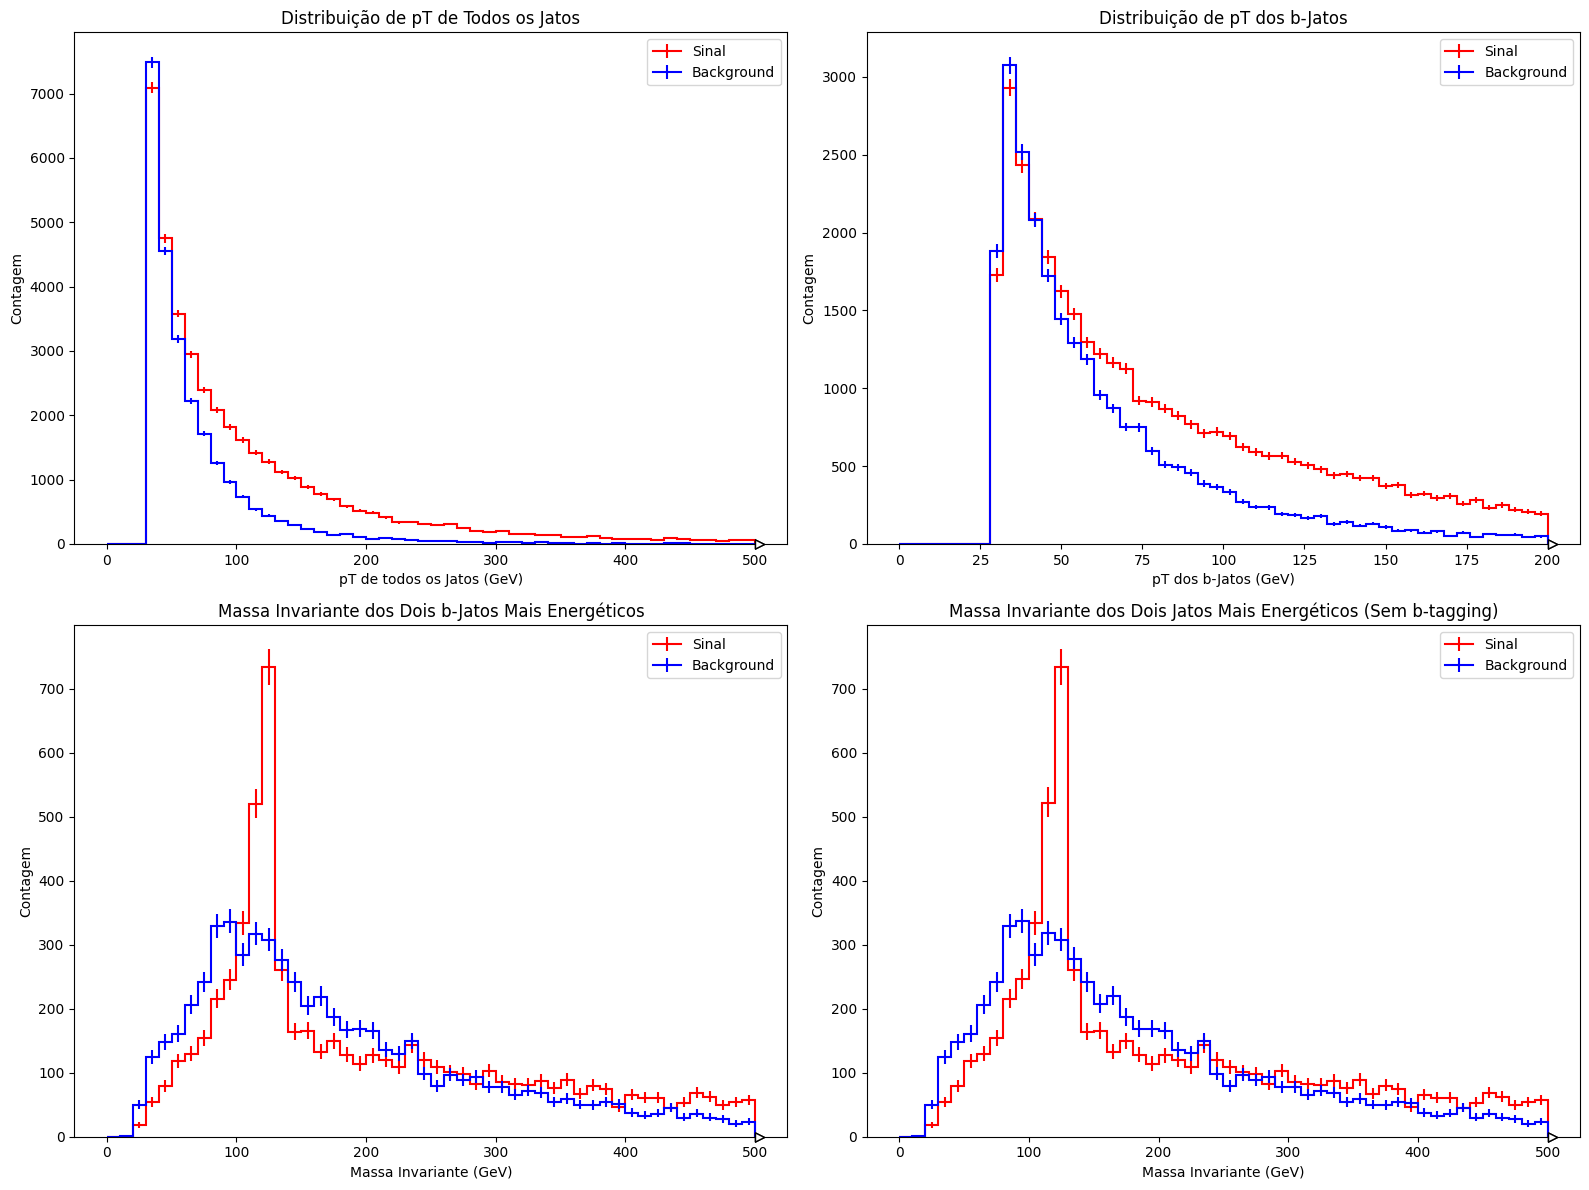

In [3]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj
import psutil
import os
import gc

# Função para verificar o uso de memória
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Limite máximo de eventos
max_events = 10000  # Total de eventos a serem processados
chunk_size = 500   # Eventos por chunk

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background_file = '/home/levi/Documentos/Sinal_background/background_pp_jjmumu.hepmc'

# Definir histogramas
histo_jets_pt_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_pt_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_pt_sinal = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt_bg = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()

# Função para ler eventos HEPMC em chunks
def read_hepmc_file_in_chunks(hepmc_file, max_events=max_events, chunk_size=chunk_size):
    events = []
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            events.append(event)
            if (i + 1) % chunk_size == 0:  # Processar chunk
                yield events
                events = []  # Limpar lista de eventos
                print(f"Eventos lidos: {i + 1}")
                print_memory_usage()
                gc.collect()  # Forçar liberação de memória
        if events:  # Processar eventos restantes
            yield events

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, particles, cone_radius=0.4):
    secondary_vertex_displacement = []
    for p in particles:
        if p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)
    if len(secondary_vertex_displacement) > 0:
        return np.mean(secondary_vertex_displacement) > 1.0
    return False

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para remover múons das partículas
def remove_muons(particles):
    return [p for p in particles if abs(p.pid) != 13]  # Múons têm PID ±13

# Função para processar eventos e preencher histogramas de jatos
def analyze_events(events, histo_all_jets, histo_bjets_pt, histo_bjets_mass, histo_jets_mass):
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis)
        particles = [p for p in event.particles if p.status == 1]
        
        # Remover múons das partículas
        particles_no_muons = remove_muons(particles)
        
        # Converter partículas para objetos PseudoJet do FastJet
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles_no_muons]
        
        # Definir o algoritmo de clustering (anti-kT, R = 0.4)
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        
        # Clusterizar as partículas em jatos
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        
        # Selecionar jatos com pT > 30 GeV
        jets = clusterer.inclusive_jets(30.0)
        
        # Preencher histograma de pT de todos os jatos
        for jet in jets:
            histo_all_jets.fill(jet.pt())
        
        # Filtrar jatos b-tagged
        b_jets = [jet for jet in jets if is_b_tagged(jet, particles_no_muons)]
        
        # Preencher histograma de pT dos jatos b-tagged
        for jet in b_jets:
            histo_bjets_pt.fill(jet.pt())
        
        # Selecionar os dois jatos de maior energia (b-tagged)
        if len(b_jets) >= 2:
            b_jets_sorted = sorted(b_jets, key=lambda j: j.e(), reverse=True)  # Ordenar por energia
            b_jets_selected = b_jets_sorted[:2]
            
            # Verificar se os jatos selecionados são realmente b-tagged
            if all(is_b_tagged(jet, particles_no_muons) for jet in b_jets_selected):
                # Calcular a massa invariante dos dois jatos b-tagged selecionados
                mass = invariant_mass(b_jets_selected[0], b_jets_selected[1])
                
                # Preencher histograma da massa invariante dos jatos b-tagged
                histo_bjets_mass.fill(mass)
        
        # Selecionar os dois jatos de maior energia (sem b-tagging)
        if len(jets) >= 2:
            jets_sorted = sorted(jets, key=lambda j: j.e(), reverse=True)  # Ordenar por energia
            jets_selected = jets_sorted[:2]
            
            # Calcular a massa invariante dos dois jatos selecionados
            mass = invariant_mass(jets_selected[0], jets_selected[1])
            
            # Preencher histograma da massa invariante dos jatos (sem b-tagging)
            histo_jets_mass.fill(mass)
        
        # Liberar memória após processar o evento
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, fj_particles, jets, b_jets  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Processar eventos de sinal em chunks
print("Processando eventos de sinal...")
for chunk in read_hepmc_file_in_chunks(sinal_file):
    analyze_events(chunk, histo_jets_pt_sinal, histo_bjets_pt_sinal, histo_bjets_mass_sinal, histo_jets_mass_sinal)

# Processar eventos de background em chunks
print("\nProcessando eventos de background...")
for chunk in read_hepmc_file_in_chunks(background_file):
    analyze_events(chunk, histo_jets_pt_bg, histo_bjets_pt_bg, histo_bjets_mass_bg, histo_jets_mass_bg)

# Plotar histogramas
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

# Histogramas de pT de todos os jatos
histo_jets_pt_sinal.plot(ax=ax[0, 0], label='Sinal', color='red')
histo_jets_pt_bg.plot(ax=ax[0, 0], label='Background', color='blue')
ax[0, 0].set(xlabel='pT de todos os Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT de Todos os Jatos')
ax[0, 0].legend()

# Histogramas de pT dos jatos b-tagging
histo_bjets_pt_sinal.plot(ax=ax[0, 1], label='Sinal', color='red')
histo_bjets_pt_bg.plot(ax=ax[0, 1], label='Background', color='blue')
ax[0, 1].set(xlabel='pT dos b-Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT dos b-Jatos')
ax[0, 1].legend()

# Histogramas da massa invariante dos dois b-jatos mais energéticos
histo_bjets_mass_sinal.plot(ax=ax[1, 0], label='Sinal', color='red')
histo_bjets_mass_bg.plot(ax=ax[1, 0], label='Background', color='blue')
ax[1, 0].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois b-Jatos Mais Energéticos')
ax[1, 0].legend()

# Histogramas da massa invariante dos dois jatos mais energéticos (sem b-tagging)
histo_jets_mass_sinal.plot(ax=ax[1, 1], label='Sinal', color='red')
histo_jets_mass_bg.plot(ax=ax[1, 1], label='Background', color='blue')
ax[1, 1].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois Jatos Mais Energéticos (Sem b-tagging)')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

Processando eventos de sinal...
Eventos lidos: 500
Uso de memória: 1759.80 MB
Eventos lidos: 1000
Uso de memória: 1759.80 MB
Eventos lidos: 1500
Uso de memória: 1759.76 MB
Eventos lidos: 2000
Uso de memória: 1759.76 MB
Eventos lidos: 2500
Uso de memória: 1759.76 MB
Eventos lidos: 3000
Uso de memória: 1759.76 MB
Eventos lidos: 3500
Uso de memória: 1759.76 MB
Eventos lidos: 4000
Uso de memória: 1759.76 MB
Eventos lidos: 4500
Uso de memória: 1759.76 MB
Eventos lidos: 5000
Uso de memória: 1760.02 MB
Eventos lidos: 5500
Uso de memória: 1757.88 MB
Eventos lidos: 6000
Uso de memória: 1756.68 MB
Eventos lidos: 6500
Uso de memória: 1757.20 MB
Eventos lidos: 7000
Uso de memória: 1772.92 MB
Eventos lidos: 7500
Uso de memória: 1772.92 MB
Eventos lidos: 8000
Uso de memória: 1773.95 MB
Eventos lidos: 8500
Uso de memória: 1773.95 MB
Eventos lidos: 9000
Uso de memória: 1774.21 MB
Eventos lidos: 9500
Uso de memória: 1774.21 MB
Eventos lidos: 10000
Uso de memória: 1774.21 MB

Processando eventos de back

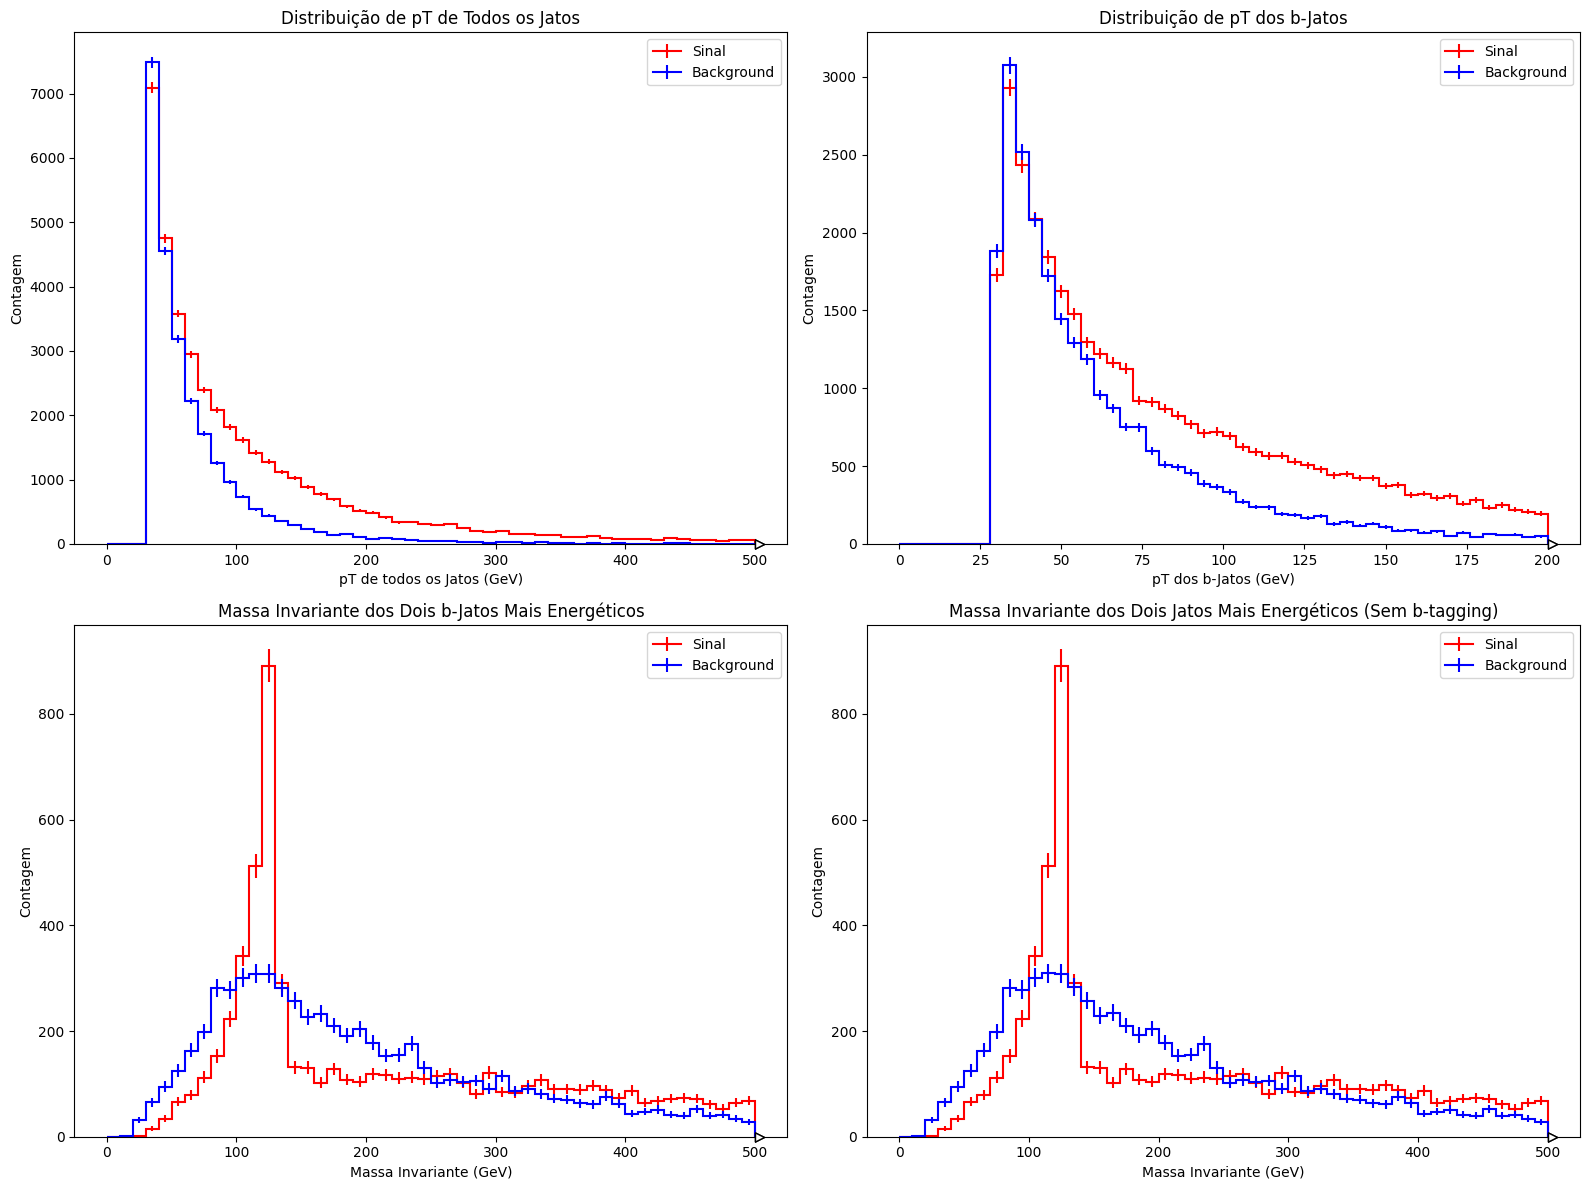

In [2]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj
import psutil
import os
import gc

# Função para verificar o uso de memória
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Limite máximo de eventos
max_events = 10000  # Total de eventos a serem processados
chunk_size = 500   # Eventos por chunk

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background_file = '/home/levi/Documentos/Sinal_background/background_pp_jjmumu.hepmc'

# Definir histogramas
histo_jets_pt_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_pt_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_pt_sinal = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt_bg = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()

# Função para ler eventos HEPMC em chunks
def read_hepmc_file_in_chunks(hepmc_file, max_events=max_events, chunk_size=chunk_size):
    events = []
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            events.append(event)
            if (i + 1) % chunk_size == 0:  # Processar chunk
                yield events
                events = []  # Limpar lista de eventos
                print(f"Eventos lidos: {i + 1}")
                print_memory_usage()
                gc.collect()  # Forçar liberação de memória
        if events:  # Processar eventos restantes
            yield events

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, particles, cone_radius=0.4):
    secondary_vertex_displacement = []
    for p in particles:
        if p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)
    if len(secondary_vertex_displacement) > 0:
        return np.mean(secondary_vertex_displacement) > 1.0
    return False

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para remover múons das partículas
def remove_muons(particles):
    return [p for p in particles if abs(p.pid) != 13]  # Múons têm PID ±13

# Função para processar eventos e preencher histogramas de jatos
def analyze_events(events, histo_all_jets, histo_bjets_pt, histo_bjets_mass, histo_jets_mass):
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis)
        particles = [p for p in event.particles if p.status == 1]
        
        # Remover múons das partículas
        particles_no_muons = remove_muons(particles)
        
        # Converter partículas para objetos PseudoJet do FastJet
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles_no_muons]
        
        # Definir o algoritmo de clustering (anti-kT, R = 0.4)
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        
        # Clusterizar as partículas em jatos
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        
        # Selecionar jatos com pT > 30 GeV
        jets = clusterer.inclusive_jets(30.0)
        
        # Preencher histograma de pT de todos os jatos
        for jet in jets:
            histo_all_jets.fill(jet.pt())
        
        # Filtrar jatos b-tagged
        b_jets = [jet for jet in jets if is_b_tagged(jet, particles_no_muons)]
        
        # Preencher histograma de pT dos jatos b-tagged
        for jet in b_jets:
            histo_bjets_pt.fill(jet.pt())
        
        # Selecionar os dois jatos de maior pT (b-tagged)
        if len(b_jets) >= 2:
            b_jets_sorted = sorted(b_jets, key=lambda j: j.pt(), reverse=True)  # Ordenar por pT
            b_jets_selected = b_jets_sorted[:2]
            
            # Verificar se os jatos selecionados são realmente b-tagged
            if all(is_b_tagged(jet, particles_no_muons) for jet in b_jets_selected):
                # Calcular a massa invariante dos dois jatos b-tagged selecionados
                mass = invariant_mass(b_jets_selected[0], b_jets_selected[1])
                
                # Preencher histograma da massa invariante dos jatos b-tagged
                histo_bjets_mass.fill(mass)
        
        # Selecionar os dois jatos de maior pT (sem b-tagging)
        if len(jets) >= 2:
            jets_sorted = sorted(jets, key=lambda j: j.pt(), reverse=True)  # Ordenar por pT
            jets_selected = jets_sorted[:2]
            
            # Calcular a massa invariante dos dois jatos selecionados
            mass = invariant_mass(jets_selected[0], jets_selected[1])
            
            # Preencher histograma da massa invariante dos jatos (sem b-tagging)
            histo_jets_mass.fill(mass)
        
        # Liberar memória após processar o evento
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, fj_particles, jets, b_jets  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Processar eventos de sinal em chunks
print("Processando eventos de sinal...")
for chunk in read_hepmc_file_in_chunks(sinal_file):
    analyze_events(chunk, histo_jets_pt_sinal, histo_bjets_pt_sinal, histo_bjets_mass_sinal, histo_jets_mass_sinal)

# Processar eventos de background em chunks
print("\nProcessando eventos de background...")
for chunk in read_hepmc_file_in_chunks(background_file):
    analyze_events(chunk, histo_jets_pt_bg, histo_bjets_pt_bg, histo_bjets_mass_bg, histo_jets_mass_bg)

# Plotar histogramas
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

# Histogramas de pT de todos os jatos
histo_jets_pt_sinal.plot(ax=ax[0, 0], label='Sinal', color='red')
histo_jets_pt_bg.plot(ax=ax[0, 0], label='Background', color='blue')
ax[0, 0].set(xlabel='pT de todos os Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT de Todos os Jatos')
ax[0, 0].legend()

# Histogramas de pT dos jatos b-tagging
histo_bjets_pt_sinal.plot(ax=ax[0, 1], label='Sinal', color='red')
histo_bjets_pt_bg.plot(ax=ax[0, 1], label='Background', color='blue')
ax[0, 1].set(xlabel='pT dos b-Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT dos b-Jatos')
ax[0, 1].legend()

# Histogramas da massa invariante dos dois b-jatos mais energéticos
histo_bjets_mass_sinal.plot(ax=ax[1, 0], label='Sinal', color='red')
histo_bjets_mass_bg.plot(ax=ax[1, 0], label='Background', color='blue')
ax[1, 0].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois b-Jatos Mais Energéticos')
ax[1, 0].legend()

# Histogramas da massa invariante dos dois jatos mais energéticos (sem b-tagging)
histo_jets_mass_sinal.plot(ax=ax[1, 1], label='Sinal', color='red')
histo_jets_mass_bg.plot(ax=ax[1, 1], label='Background', color='blue')
ax[1, 1].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois Jatos Mais Energéticos (Sem b-tagging)')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

# background_pp>tt

Processando eventos de sinal...
Eventos processados: 1000
Uso de memória: 3326.71 MB
Eventos processados: 1000
Uso de memória: 3326.71 MB
Eventos lidos: 1000
Uso de memória: 3326.71 MB
Eventos processados: 1000
Uso de memória: 3325.80 MB
Eventos processados: 1000
Uso de memória: 3325.80 MB
Eventos lidos: 2000
Uso de memória: 3325.80 MB
Eventos processados: 1000
Uso de memória: 3324.24 MB
Eventos processados: 1000
Uso de memória: 3324.18 MB
Eventos lidos: 3000
Uso de memória: 3324.18 MB
Eventos processados: 1000
Uso de memória: 3323.77 MB
Eventos processados: 1000
Uso de memória: 3323.77 MB
Eventos lidos: 4000
Uso de memória: 3323.77 MB
Eventos processados: 1000
Uso de memória: 3323.73 MB
Eventos processados: 1000
Uso de memória: 3323.73 MB
Eventos lidos: 5000
Uso de memória: 3323.73 MB
Eventos processados: 1000
Uso de memória: 3323.20 MB
Eventos processados: 1000
Uso de memória: 3323.20 MB
Eventos lidos: 6000
Uso de memória: 3323.20 MB
Eventos processados: 1000
Uso de memória: 3323.20 

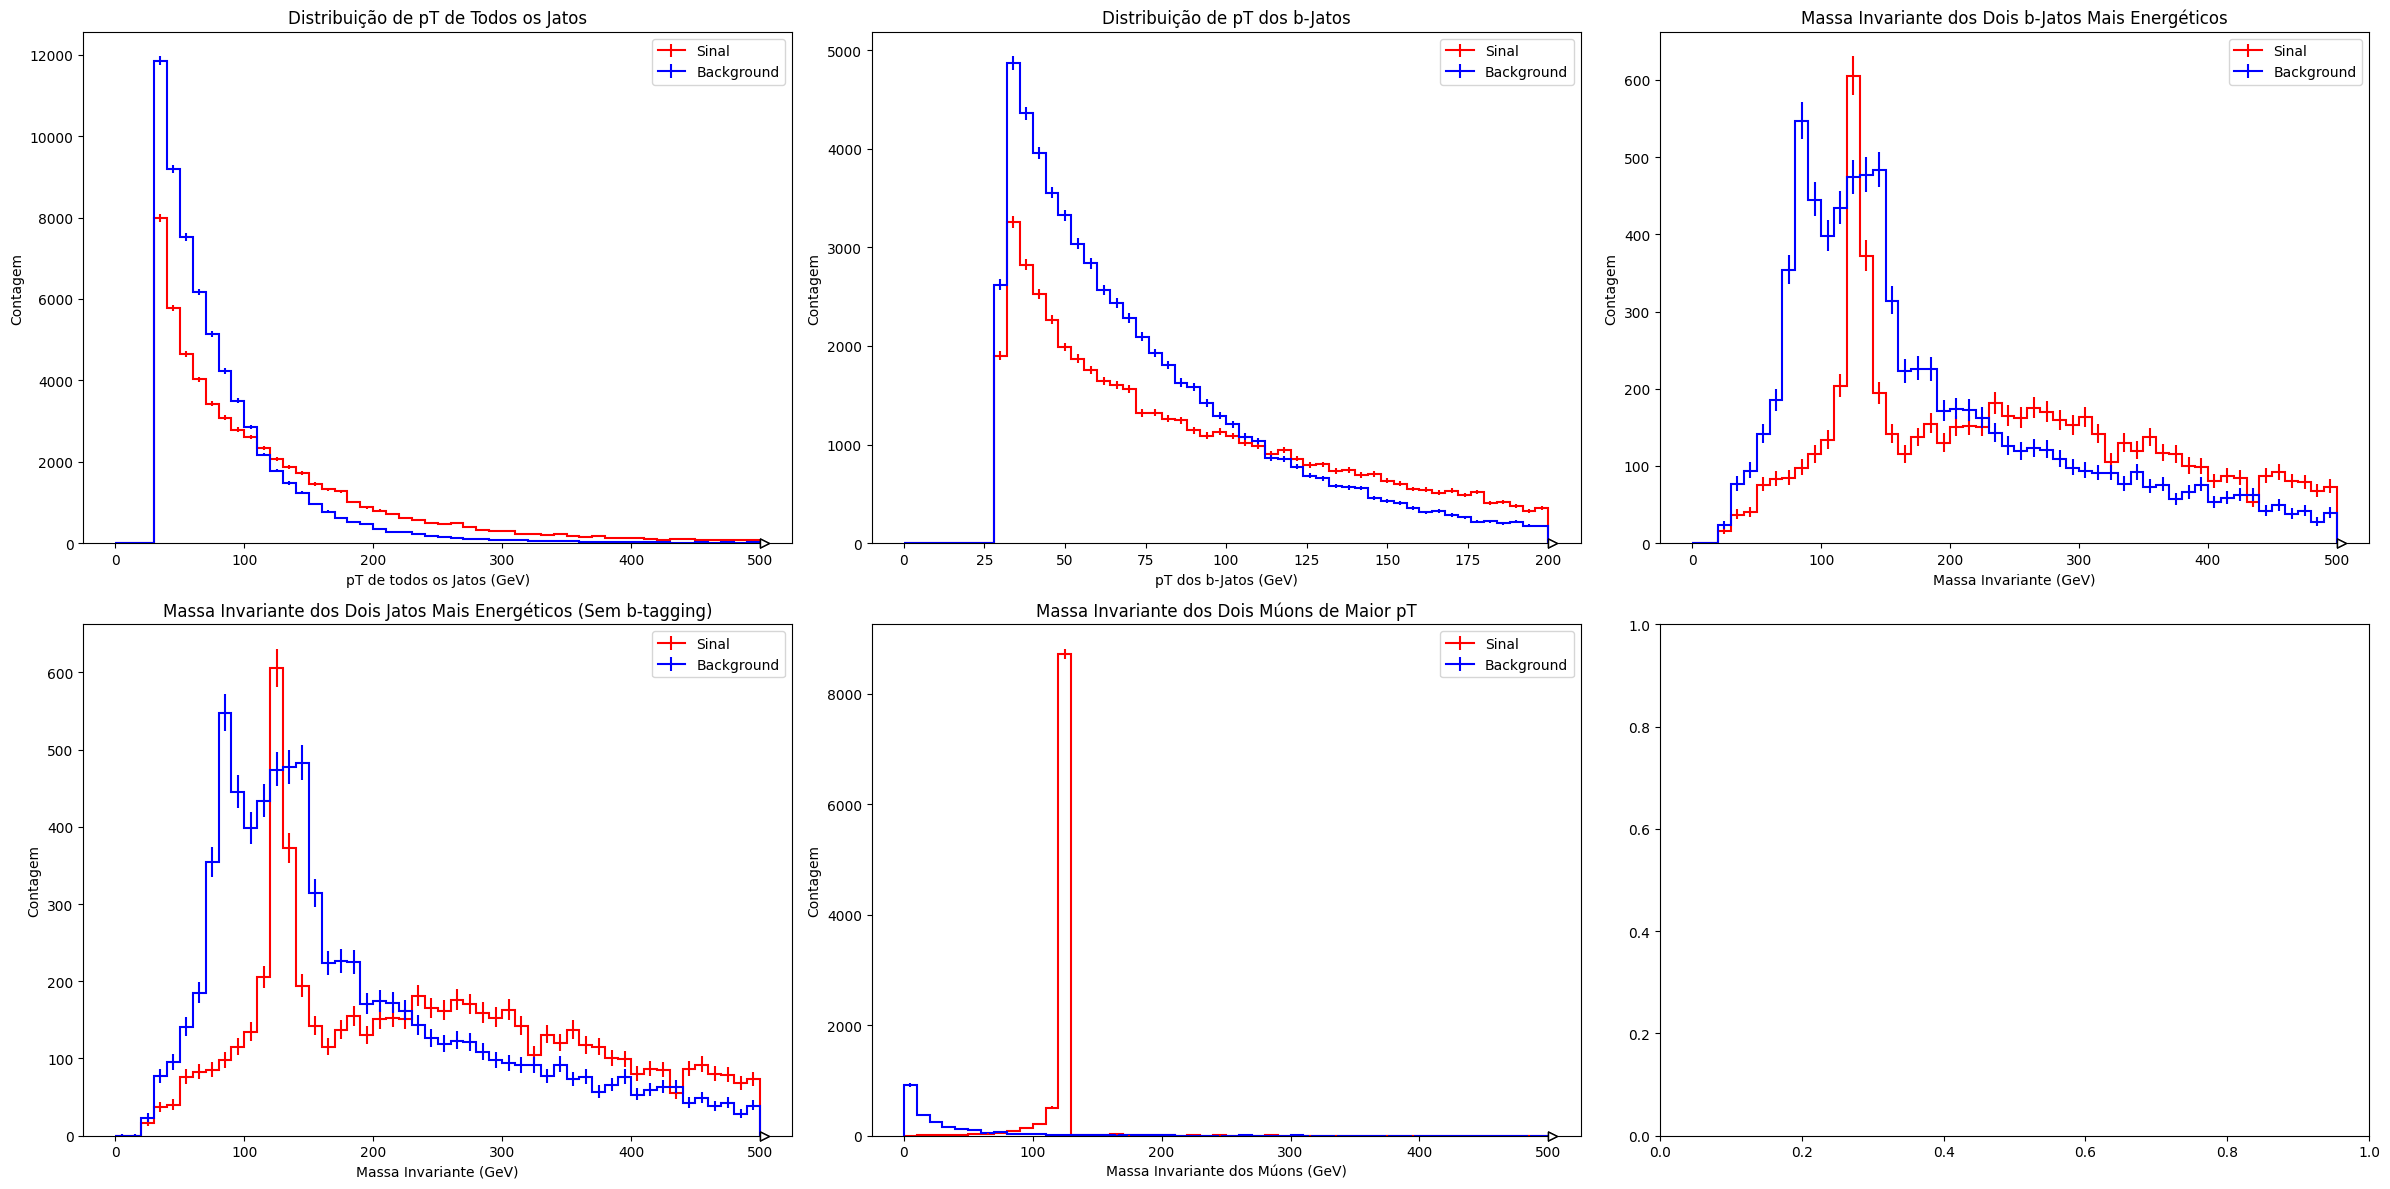

In [4]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj
import psutil
import os
import gc

# Função para verificar o uso de memória
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Limite máximo de eventos
max_events = 10000  # Total de eventos a serem processados
chunk_size = 1000   # Eventos por chunk

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background_file = '/home/levi/Documentos/Sinal_background/pp_tt_100TeV_background.hepmc'

# Definir histogramas
histo_jets_pt_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_pt_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_pt_sinal = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt_bg = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()  # Novo histograma
histo_jets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()      # Novo histograma
histo_muons_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_muons_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()

# Função para ler eventos HEPMC em chunks
def read_hepmc_file_in_chunks(hepmc_file, max_events=max_events, chunk_size=chunk_size):
    events = []
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            events.append(event)
            if (i + 1) % chunk_size == 0:  # Processar chunk
                yield events
                events = []  # Limpar lista de eventos
                print(f"Eventos lidos: {i + 1}")
                print_memory_usage()
                gc.collect()  # Forçar liberação de memória
        if events:  # Processar eventos restantes
            yield events

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, particles, cone_radius=0.4):
    secondary_vertex_displacement = []
    for p in particles:
        if p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)
    if len(secondary_vertex_displacement) > 0:
        return np.mean(secondary_vertex_displacement) > 1.0
    return False

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para processar eventos e preencher histogramas de jatos
def analyze_events(events, histo_all_jets, histo_bjets_pt, histo_bjets_mass, histo_jets_mass):
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis)
        particles = [p for p in event.particles if p.status == 1]
        
        # Converter partículas para objetos PseudoJet do FastJet
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles]
        
        # Definir o algoritmo de clustering (anti-kT, R = 0.4)
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        
        # Clusterizar as partículas em jatos
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        
        # Selecionar jatos com pT > 30 GeV
        jets = clusterer.inclusive_jets(30.0)
        
        # Preencher histograma de pT de todos os jatos
        for jet in jets:
            histo_all_jets.fill(jet.pt())
        
        # Filtrar jatos b-tagged
        b_jets = [jet for jet in jets if is_b_tagged(jet, particles)]
        
        # Preencher histograma de pT dos jatos b-tagged
        for jet in b_jets:
            histo_bjets_pt.fill(jet.pt())
        
        # Selecionar os dois jatos de maior energia (b-tagged)
        if len(b_jets) >= 2:
            b_jets_sorted = sorted(b_jets, key=lambda j: j.e(), reverse=True)  # Ordenar por energia
            b_jets_selected = b_jets_sorted[:2]
            
            # Verificar se os jatos selecionados são realmente b-tagged
            if all(is_b_tagged(jet, particles) for jet in b_jets_selected):
                # Calcular a massa invariante dos dois jatos b-tagged selecionados
                mass = invariant_mass(b_jets_selected[0], b_jets_selected[1])
                
                # Preencher histograma da massa invariante dos jatos b-tagged
                histo_bjets_mass.fill(mass)
        
        # Selecionar os dois jatos de maior energia (sem b-tagging)
        if len(jets) >= 2:
            jets_sorted = sorted(jets, key=lambda j: j.e(), reverse=True)  # Ordenar por energia
            jets_selected = jets_sorted[:2]
            
            # Calcular a massa invariante dos dois jatos selecionados
            mass = invariant_mass(jets_selected[0], jets_selected[1])
            
            # Preencher histograma da massa invariante dos jatos (sem b-tagging)
            histo_jets_mass.fill(mass)
        
        # Liberar memória após processar o evento
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, fj_particles, jets, b_jets  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Função para identificar múons com cargas opostas e de mesmo sabor
def find_opposite_charge_muons(particles):
    muons = []
    for p in particles:
        if abs(p.pid) == 13:  # Múons têm PID ±13
            muons.append(p)
    
    # Selecionar pares de múons com cargas opostas
    muon_pairs = []
    for i in range(len(muons)):
        for j in range(i + 1, len(muons)):
            if muons[i].pid == -muons[j].pid:  # Cargas opostas
                muon_pairs.append((muons[i], muons[j]))
    
    return muon_pairs

# Função para processar eventos e preencher histograma de múons
def analyze_muons(events, histo_muons_mass):
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis)
        particles = [p for p in event.particles if p.status == 1]
        
        # Identificar pares de múons com cargas opostas
        muon_pairs = find_opposite_charge_muons(particles)
        
        if len(muon_pairs) >= 1:
            # Selecionar o par de múons com maior soma de pT
            selected_pair = max(muon_pairs, key=lambda pair: pair[0].momentum.pt() + pair[1].momentum.pt())
            
            # Criar objetos PseudoJet para os múons
            muon1 = fj.PseudoJet(selected_pair[0].momentum.x, selected_pair[0].momentum.y, selected_pair[0].momentum.z, selected_pair[0].momentum.e)
            muon2 = fj.PseudoJet(selected_pair[1].momentum.x, selected_pair[1].momentum.y, selected_pair[1].momentum.z, selected_pair[1].momentum.e)
            
            # Calcular a massa invariante
            mass = invariant_mass(muon1, muon2)
            
            # Preencher histograma da massa invariante
            histo_muons_mass.fill(mass)
        
        # Liberar memória após processar o evento
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, muon_pairs, selected_pair, muon1, muon2  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Processar eventos de sinal em chunks
print("Processando eventos de sinal...")
for chunk in read_hepmc_file_in_chunks(sinal_file):
    analyze_events(chunk, histo_jets_pt_sinal, histo_bjets_pt_sinal, histo_bjets_mass_sinal, histo_jets_mass_sinal)
    analyze_muons(chunk, histo_muons_mass_sinal)

# Processar eventos de background em chunks
print("\nProcessando eventos de background...")
for chunk in read_hepmc_file_in_chunks(background_file):
    analyze_events(chunk, histo_jets_pt_bg, histo_bjets_pt_bg, histo_bjets_mass_bg, histo_jets_mass_bg)
    analyze_muons(chunk, histo_muons_mass_bg)

# Plotar histogramas
fig, ax = plt.subplots(2, 3, figsize=(24, 12))

# Histogramas de pT de todos os jatos
histo_jets_pt_sinal.plot(ax=ax[0, 0], label='Sinal', color='red')
histo_jets_pt_bg.plot(ax=ax[0, 0], label='Background', color='blue')
ax[0, 0].set(xlabel='pT de todos os Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT de Todos os Jatos')
ax[0, 0].legend()

# Histogramas de pT dos jatos b-tagging
histo_bjets_pt_sinal.plot(ax=ax[0, 1], label='Sinal', color='red')
histo_bjets_pt_bg.plot(ax=ax[0, 1], label='Background', color='blue')
ax[0, 1].set(xlabel='pT dos b-Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT dos b-Jatos')
ax[0, 1].legend()

# Histogramas da massa invariante dos dois b-jatos mais energéticos
histo_bjets_mass_sinal.plot(ax=ax[0, 2], label='Sinal', color='red')
histo_bjets_mass_bg.plot(ax=ax[0, 2], label='Background', color='blue')
ax[0, 2].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois b-Jatos Mais Energéticos')
ax[0, 2].legend()

# Histogramas da massa invariante dos dois jatos mais energéticos (sem b-tagging)
histo_jets_mass_sinal.plot(ax=ax[1, 0], label='Sinal', color='red')
histo_jets_mass_bg.plot(ax=ax[1, 0], label='Background', color='blue')
ax[1, 0].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois Jatos Mais Energéticos (Sem b-tagging)')
ax[1, 0].legend()

# Histograma da massa invariante dos dois múons de maior pT
histo_muons_mass_sinal.plot(ax=ax[1, 1], label='Sinal', color='red')
histo_muons_mass_bg.plot(ax=ax[1, 1], label='Background', color='blue')
ax[1, 1].set(xlabel='Massa Invariante dos Múons (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois Múons de Maior pT')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

Processando eventos de sinal...
Eventos lidos: 500
Uso de memória: 3439.48 MB
Eventos lidos: 1000
Uso de memória: 3438.79 MB
Eventos lidos: 1500
Uso de memória: 3437.75 MB
Eventos lidos: 2000
Uso de memória: 3437.57 MB
Eventos lidos: 2500
Uso de memória: 3438.01 MB
Eventos lidos: 3000
Uso de memória: 3437.96 MB
Eventos lidos: 3500
Uso de memória: 3437.96 MB
Eventos lidos: 4000
Uso de memória: 3437.96 MB
Eventos lidos: 4500
Uso de memória: 3438.22 MB
Eventos lidos: 5000
Uso de memória: 3438.22 MB
Eventos lidos: 5500
Uso de memória: 3438.22 MB
Eventos lidos: 6000
Uso de memória: 3438.22 MB
Eventos lidos: 6500
Uso de memória: 3438.42 MB
Eventos lidos: 7000
Uso de memória: 3432.58 MB
Eventos lidos: 7500
Uso de memória: 3432.50 MB
Eventos lidos: 8000
Uso de memória: 3432.50 MB
Eventos lidos: 8500
Uso de memória: 3432.48 MB
Eventos lidos: 9000
Uso de memória: 3432.33 MB
Eventos lidos: 9500
Uso de memória: 3432.04 MB
Eventos lidos: 10000
Uso de memória: 3432.81 MB

Processando eventos de back

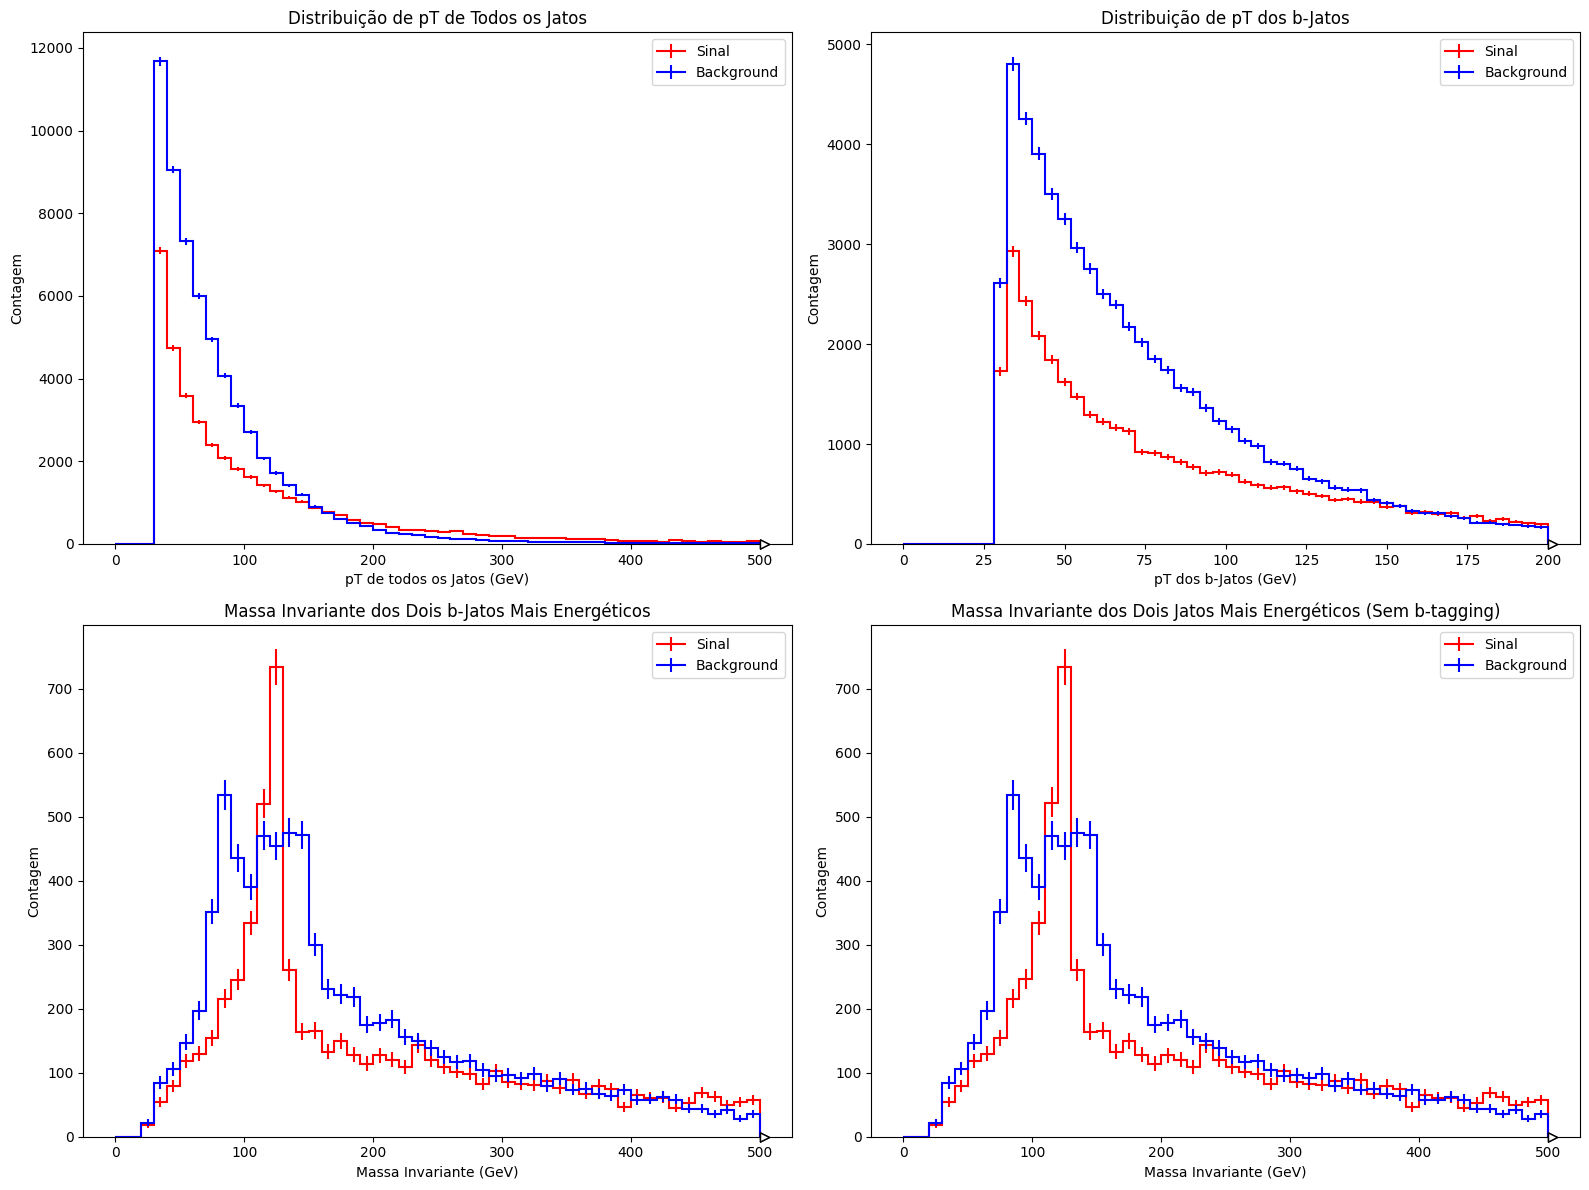

In [5]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj
import psutil
import os
import gc

# Função para verificar o uso de memória
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Limite máximo de eventos
max_events = 10000  # Total de eventos a serem processados
chunk_size = 500   # Eventos por chunk

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background_file = '/home/levi/Documentos/Sinal_background/pp_tt_100TeV_background.hepmc'

# Definir histogramas
histo_jets_pt_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_pt_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_pt_sinal = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt_bg = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()

# Função para ler eventos HEPMC em chunks
def read_hepmc_file_in_chunks(hepmc_file, max_events=max_events, chunk_size=chunk_size):
    events = []
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            events.append(event)
            if (i + 1) % chunk_size == 0:  # Processar chunk
                yield events
                events = []  # Limpar lista de eventos
                print(f"Eventos lidos: {i + 1}")
                print_memory_usage()
                gc.collect()  # Forçar liberação de memória
        if events:  # Processar eventos restantes
            yield events

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, particles, cone_radius=0.4):
    secondary_vertex_displacement = []
    for p in particles:
        if p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)
    if len(secondary_vertex_displacement) > 0:
        return np.mean(secondary_vertex_displacement) > 1.0
    return False

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para remover múons das partículas
def remove_muons(particles):
    return [p for p in particles if abs(p.pid) != 13]  # Múons têm PID ±13

# Função para processar eventos e preencher histogramas de jatos
def analyze_events(events, histo_all_jets, histo_bjets_pt, histo_bjets_mass, histo_jets_mass):
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis)
        particles = [p for p in event.particles if p.status == 1]
        
        # Remover múons das partículas
        particles_no_muons = remove_muons(particles)
        
        # Converter partículas para objetos PseudoJet do FastJet
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles_no_muons]
        
        # Definir o algoritmo de clustering (anti-kT, R = 0.4)
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        
        # Clusterizar as partículas em jatos
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        
        # Selecionar jatos com pT > 30 GeV
        jets = clusterer.inclusive_jets(30.0)
        
        # Preencher histograma de pT de todos os jatos
        for jet in jets:
            histo_all_jets.fill(jet.pt())
        
        # Filtrar jatos b-tagged
        b_jets = [jet for jet in jets if is_b_tagged(jet, particles_no_muons)]
        
        # Preencher histograma de pT dos jatos b-tagged
        for jet in b_jets:
            histo_bjets_pt.fill(jet.pt())
        
        # Selecionar os dois jatos de maior energia (b-tagged)
        if len(b_jets) >= 2:
            b_jets_sorted = sorted(b_jets, key=lambda j: j.e(), reverse=True)  # Ordenar por energia
            b_jets_selected = b_jets_sorted[:2]
            
            # Verificar se os jatos selecionados são realmente b-tagged
            if all(is_b_tagged(jet, particles_no_muons) for jet in b_jets_selected):
                # Calcular a massa invariante dos dois jatos b-tagged selecionados
                mass = invariant_mass(b_jets_selected[0], b_jets_selected[1])
                
                # Preencher histograma da massa invariante dos jatos b-tagged
                histo_bjets_mass.fill(mass)
        
        # Selecionar os dois jatos de maior energia (sem b-tagging)
        if len(jets) >= 2:
            jets_sorted = sorted(jets, key=lambda j: j.e(), reverse=True)  # Ordenar por energia
            jets_selected = jets_sorted[:2]
            
            # Calcular a massa invariante dos dois jatos selecionados
            mass = invariant_mass(jets_selected[0], jets_selected[1])
            
            # Preencher histograma da massa invariante dos jatos (sem b-tagging)
            histo_jets_mass.fill(mass)
        
        # Liberar memória após processar o evento
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, fj_particles, jets, b_jets  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Processar eventos de sinal em chunks
print("Processando eventos de sinal...")
for chunk in read_hepmc_file_in_chunks(sinal_file):
    analyze_events(chunk, histo_jets_pt_sinal, histo_bjets_pt_sinal, histo_bjets_mass_sinal, histo_jets_mass_sinal)

# Processar eventos de background em chunks
print("\nProcessando eventos de background...")
for chunk in read_hepmc_file_in_chunks(background_file):
    analyze_events(chunk, histo_jets_pt_bg, histo_bjets_pt_bg, histo_bjets_mass_bg, histo_jets_mass_bg)

# Plotar histogramas
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

# Histogramas de pT de todos os jatos
histo_jets_pt_sinal.plot(ax=ax[0, 0], label='Sinal', color='red')
histo_jets_pt_bg.plot(ax=ax[0, 0], label='Background', color='blue')
ax[0, 0].set(xlabel='pT de todos os Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT de Todos os Jatos')
ax[0, 0].legend()

# Histogramas de pT dos jatos b-tagging
histo_bjets_pt_sinal.plot(ax=ax[0, 1], label='Sinal', color='red')
histo_bjets_pt_bg.plot(ax=ax[0, 1], label='Background', color='blue')
ax[0, 1].set(xlabel='pT dos b-Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT dos b-Jatos')
ax[0, 1].legend()

# Histogramas da massa invariante dos dois b-jatos mais energéticos
histo_bjets_mass_sinal.plot(ax=ax[1, 0], label='Sinal', color='red')
histo_bjets_mass_bg.plot(ax=ax[1, 0], label='Background', color='blue')
ax[1, 0].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois b-Jatos Mais Energéticos')
ax[1, 0].legend()

# Histogramas da massa invariante dos dois jatos mais energéticos (sem b-tagging)
histo_jets_mass_sinal.plot(ax=ax[1, 1], label='Sinal', color='red')
histo_jets_mass_bg.plot(ax=ax[1, 1], label='Background', color='blue')
ax[1, 1].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois Jatos Mais Energéticos (Sem b-tagging)')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

Processando eventos de sinal...
Eventos lidos: 500
Uso de memória: 1769.24 MB
Eventos lidos: 1000
Uso de memória: 1769.50 MB
Eventos lidos: 1500
Uso de memória: 1769.50 MB
Eventos lidos: 2000
Uso de memória: 1769.50 MB
Eventos lidos: 2500
Uso de memória: 1769.50 MB
Eventos lidos: 3000
Uso de memória: 1769.50 MB
Eventos lidos: 3500
Uso de memória: 1769.50 MB
Eventos lidos: 4000
Uso de memória: 1769.50 MB
Eventos lidos: 4500
Uso de memória: 1769.50 MB
Eventos lidos: 5000
Uso de memória: 1769.50 MB
Eventos lidos: 5500
Uso de memória: 1768.27 MB
Eventos lidos: 6000
Uso de memória: 1768.23 MB
Eventos lidos: 6500
Uso de memória: 1768.23 MB
Eventos lidos: 7000
Uso de memória: 1769.26 MB
Eventos lidos: 7500
Uso de memória: 1769.26 MB
Eventos lidos: 8000
Uso de memória: 1769.52 MB
Eventos lidos: 8500
Uso de memória: 1769.52 MB
Eventos lidos: 9000
Uso de memória: 1769.52 MB
Eventos lidos: 9500
Uso de memória: 1769.52 MB
Eventos lidos: 10000
Uso de memória: 1769.52 MB

Processando eventos de back

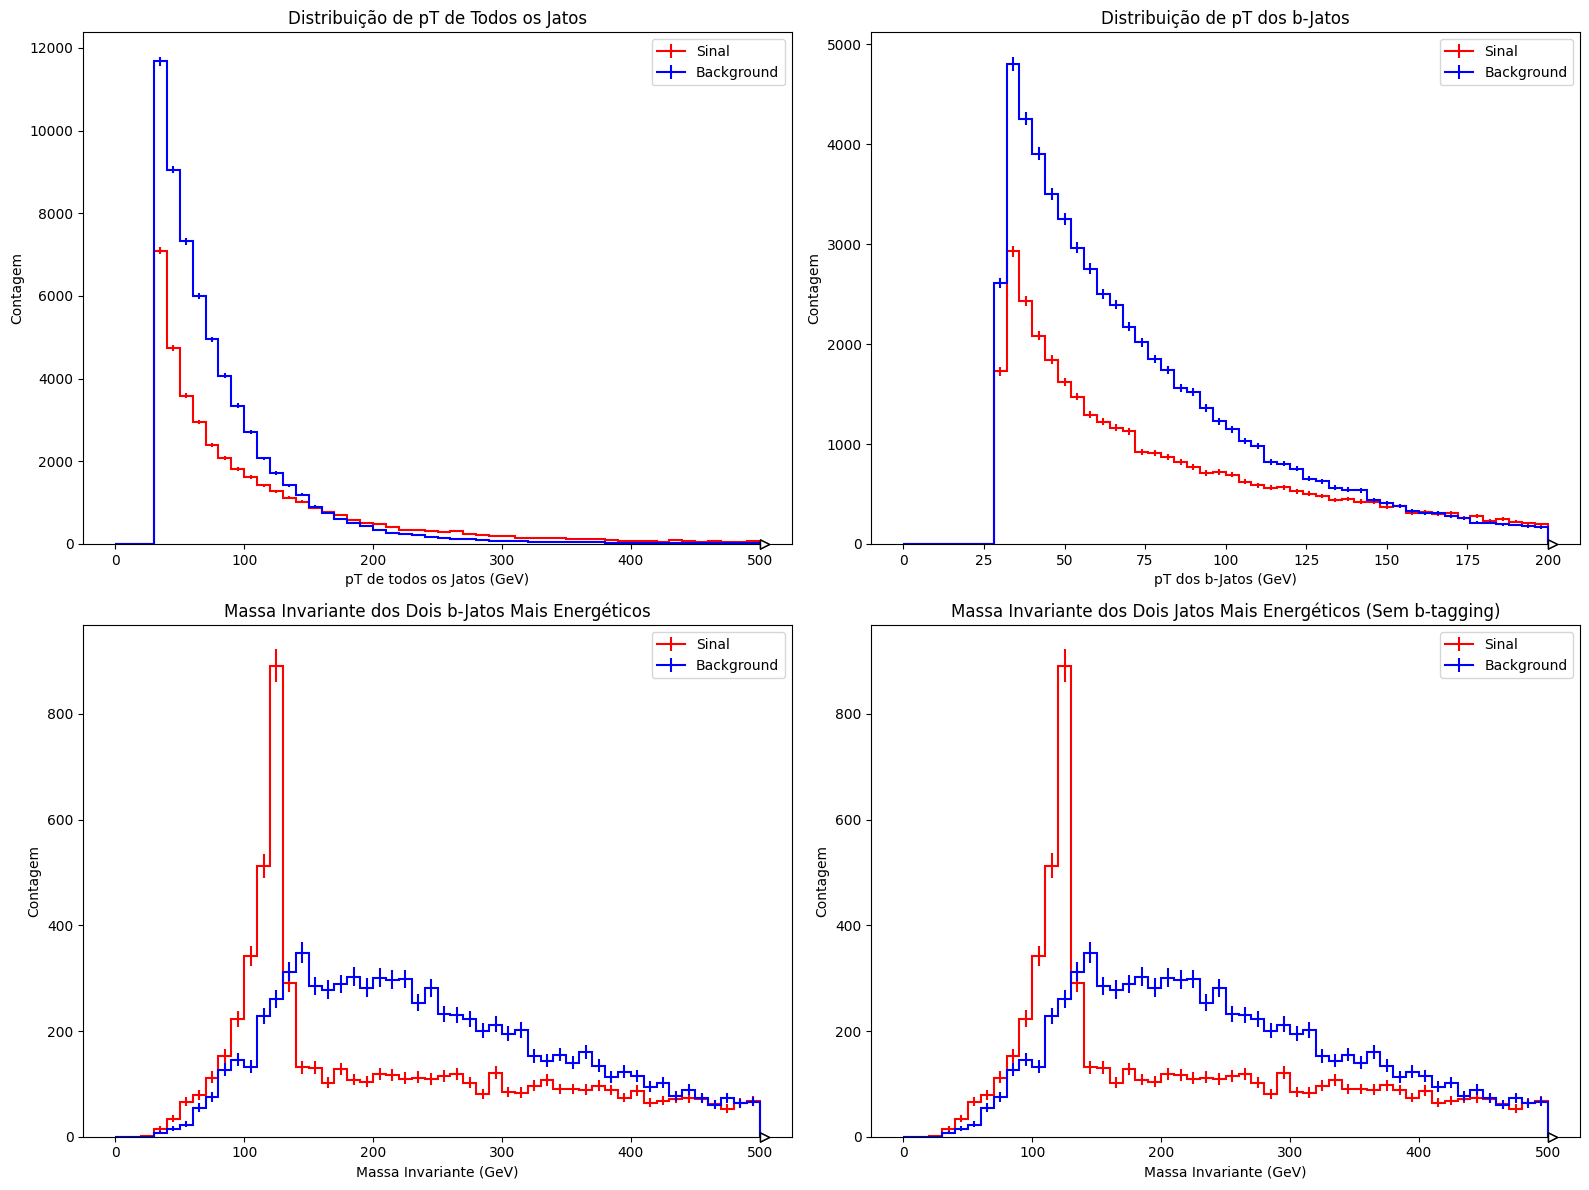

In [3]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj
import psutil
import os
import gc

# Função para verificar o uso de memória
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Limite máximo de eventos
max_events = 10000  # Total de eventos a serem processados
chunk_size = 500   # Eventos por chunk

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background_file = '/home/levi/Documentos/Sinal_background/pp_tt_100TeV_background.hepmc'

# Definir histogramas
histo_jets_pt_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_pt_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_pt_sinal = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt_bg = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()

# Função para ler eventos HEPMC em chunks
def read_hepmc_file_in_chunks(hepmc_file, max_events=max_events, chunk_size=chunk_size):
    events = []
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            events.append(event)
            if (i + 1) % chunk_size == 0:  # Processar chunk
                yield events
                events = []  # Limpar lista de eventos
                print(f"Eventos lidos: {i + 1}")
                print_memory_usage()
                gc.collect()  # Forçar liberação de memória
        if events:  # Processar eventos restantes
            yield events

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, particles, cone_radius=0.4):
    secondary_vertex_displacement = []
    for p in particles:
        if p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)
    if len(secondary_vertex_displacement) > 0:
        return np.mean(secondary_vertex_displacement) > 1.0
    return False

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para remover múons das partículas
def remove_muons(particles):
    return [p for p in particles if abs(p.pid) != 13]  # Múons têm PID ±13

# Função para processar eventos e preencher histogramas de jatos
def analyze_events(events, histo_all_jets, histo_bjets_pt, histo_bjets_mass, histo_jets_mass):
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis)
        particles = [p for p in event.particles if p.status == 1]
        
        # Remover múons das partículas
        particles_no_muons = remove_muons(particles)
        
        # Converter partículas para objetos PseudoJet do FastJet
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles_no_muons]
        
        # Definir o algoritmo de clustering (anti-kT, R = 0.4)
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        
        # Clusterizar as partículas em jatos
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        
        # Selecionar jatos com pT > 30 GeV
        jets = clusterer.inclusive_jets(30.0)
        
        # Preencher histograma de pT de todos os jatos
        for jet in jets:
            histo_all_jets.fill(jet.pt())
        
        # Filtrar jatos b-tagged
        b_jets = [jet for jet in jets if is_b_tagged(jet, particles_no_muons)]
        
        # Preencher histograma de pT dos jatos b-tagged
        for jet in b_jets:
            histo_bjets_pt.fill(jet.pt())
        
        # Selecionar os dois jatos de maior pT (b-tagged)
        if len(b_jets) >= 2:
            b_jets_sorted = sorted(b_jets, key=lambda j: j.pt(), reverse=True)  # Ordenar por pT
            b_jets_selected = b_jets_sorted[:2]
            
            # Verificar se os jatos selecionados são realmente b-tagged
            if all(is_b_tagged(jet, particles_no_muons) for jet in b_jets_selected):
                # Calcular a massa invariante dos dois jatos b-tagged selecionados
                mass = invariant_mass(b_jets_selected[0], b_jets_selected[1])
                
                # Preencher histograma da massa invariante dos jatos b-tagged
                histo_bjets_mass.fill(mass)
        
        # Selecionar os dois jatos de maior pT (sem b-tagging)
        if len(jets) >= 2:
            jets_sorted = sorted(jets, key=lambda j: j.pt(), reverse=True)  # Ordenar por pT
            jets_selected = jets_sorted[:2]
            
            # Calcular a massa invariante dos dois jatos selecionados
            mass = invariant_mass(jets_selected[0], jets_selected[1])
            
            # Preencher histograma da massa invariante dos jatos (sem b-tagging)
            histo_jets_mass.fill(mass)
        
        # Liberar memória após processar o evento
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, fj_particles, jets, b_jets  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Processar eventos de sinal em chunks
print("Processando eventos de sinal...")
for chunk in read_hepmc_file_in_chunks(sinal_file):
    analyze_events(chunk, histo_jets_pt_sinal, histo_bjets_pt_sinal, histo_bjets_mass_sinal, histo_jets_mass_sinal)

# Processar eventos de background em chunks
print("\nProcessando eventos de background...")
for chunk in read_hepmc_file_in_chunks(background_file):
    analyze_events(chunk, histo_jets_pt_bg, histo_bjets_pt_bg, histo_bjets_mass_bg, histo_jets_mass_bg)

# Plotar histogramas
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

# Histogramas de pT de todos os jatos
histo_jets_pt_sinal.plot(ax=ax[0, 0], label='Sinal', color='red')
histo_jets_pt_bg.plot(ax=ax[0, 0], label='Background', color='blue')
ax[0, 0].set(xlabel='pT de todos os Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT de Todos os Jatos')
ax[0, 0].legend()

# Histogramas de pT dos jatos b-tagging
histo_bjets_pt_sinal.plot(ax=ax[0, 1], label='Sinal', color='red')
histo_bjets_pt_bg.plot(ax=ax[0, 1], label='Background', color='blue')
ax[0, 1].set(xlabel='pT dos b-Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT dos b-Jatos')
ax[0, 1].legend()

# Histogramas da massa invariante dos dois b-jatos mais energéticos
histo_bjets_mass_sinal.plot(ax=ax[1, 0], label='Sinal', color='red')
histo_bjets_mass_bg.plot(ax=ax[1, 0], label='Background', color='blue')
ax[1, 0].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois b-Jatos Mais Energéticos')
ax[1, 0].legend()

# Histogramas da massa invariante dos dois jatos mais energéticos (sem b-tagging)
histo_jets_mass_sinal.plot(ax=ax[1, 1], label='Sinal', color='red')
histo_jets_mass_bg.plot(ax=ax[1, 1], label='Background', color='blue')
ax[1, 1].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois Jatos Mais Energéticos (Sem b-tagging)')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

# Dois_backgrounds

Processando eventos de sinal...
Eventos lidos: 500
Uso de memória: 3437.16 MB
Eventos lidos: 1000
Uso de memória: 3437.98 MB
Eventos lidos: 1500
Uso de memória: 3437.80 MB
Eventos lidos: 2000
Uso de memória: 3437.45 MB
Eventos lidos: 2500
Uso de memória: 3434.05 MB
Eventos lidos: 3000
Uso de memória: 3434.05 MB
Eventos lidos: 3500
Uso de memória: 3434.04 MB
Eventos lidos: 4000
Uso de memória: 3434.04 MB
Eventos lidos: 4500
Uso de memória: 3433.93 MB
Eventos lidos: 5000
Uso de memória: 3433.57 MB
Eventos lidos: 5500
Uso de memória: 3433.30 MB
Eventos lidos: 6000
Uso de memória: 3433.28 MB
Eventos lidos: 6500
Uso de memória: 3433.25 MB
Eventos lidos: 7000
Uso de memória: 3433.23 MB
Eventos lidos: 7500
Uso de memória: 3433.23 MB
Eventos lidos: 8000
Uso de memória: 3433.23 MB
Eventos lidos: 8500
Uso de memória: 3433.20 MB
Eventos lidos: 9000
Uso de memória: 3433.20 MB
Eventos lidos: 9500
Uso de memória: 3433.20 MB
Eventos lidos: 10000
Uso de memória: 3433.20 MB

Processando eventos de back

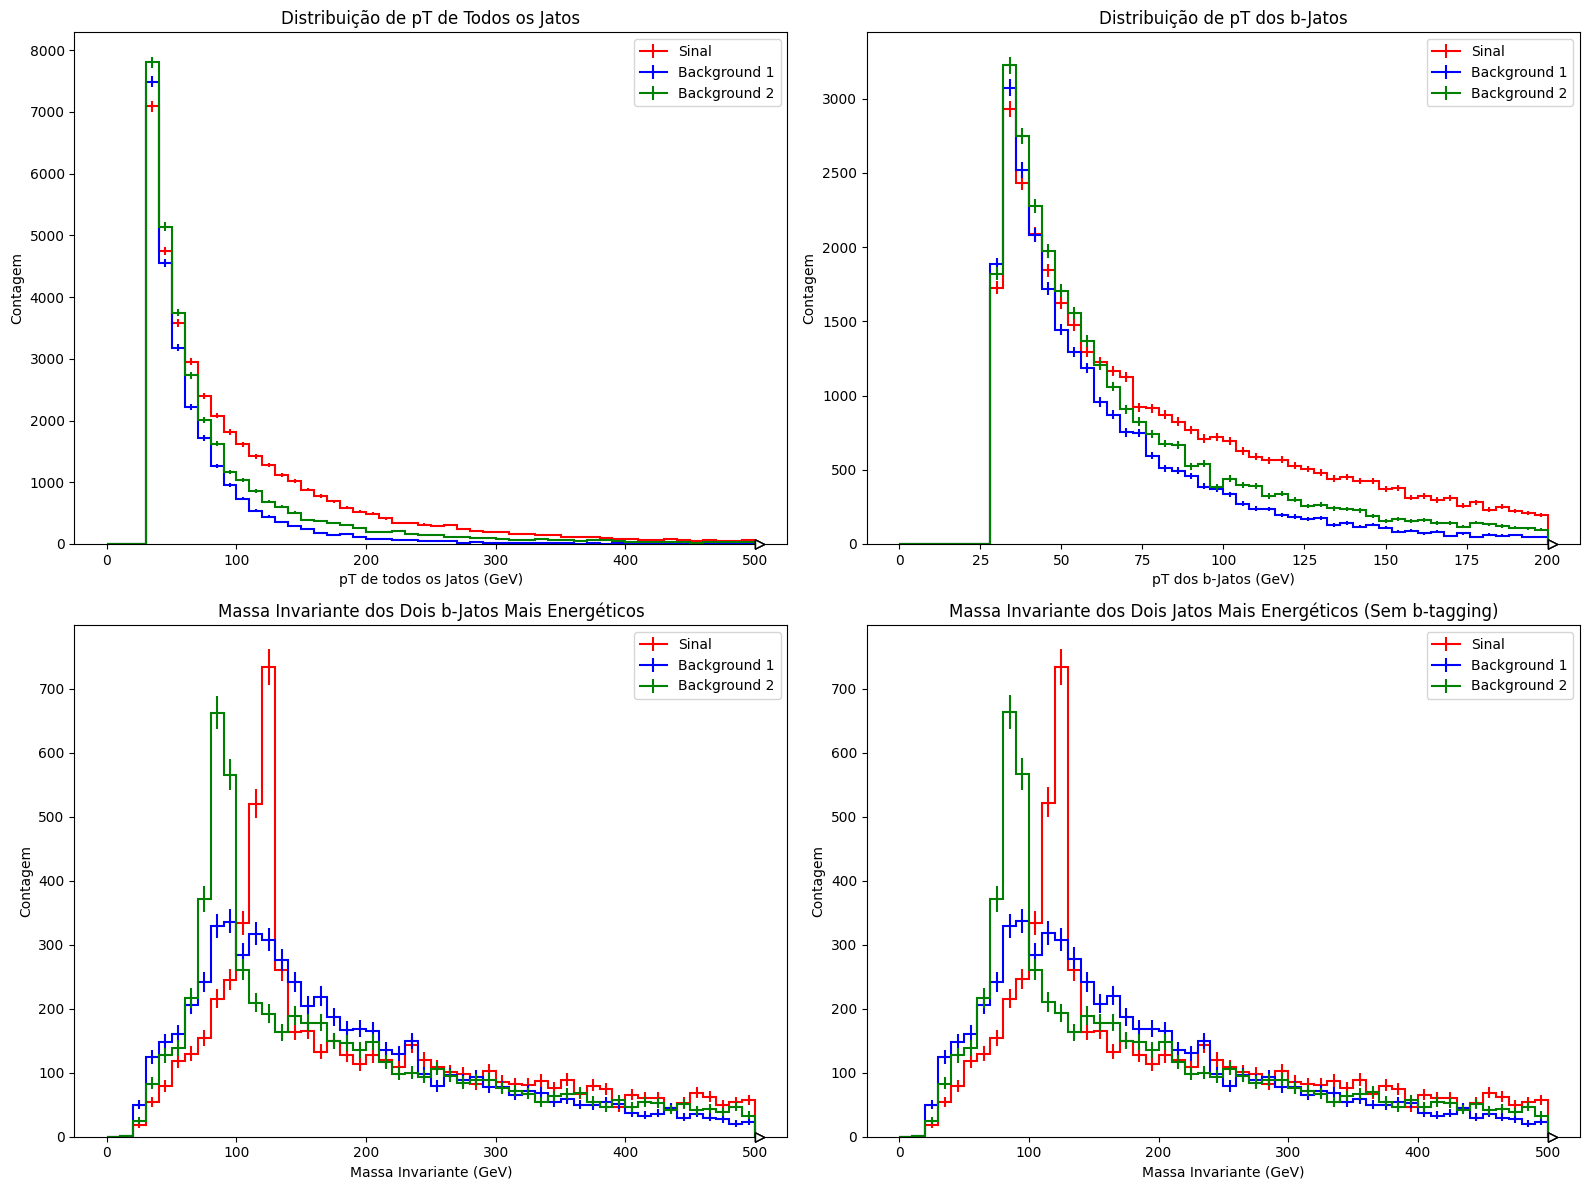

In [6]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj
import psutil
import os
import gc

# Função para verificar o uso de memória
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Limite máximo de eventos
max_events = 10000  # Total de eventos a serem processados
chunk_size = 500   # Eventos por chunk

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background_file1 = '/home/levi/Documentos/Sinal_background/background_pp_jjmumu.hepmc'
background_file2 = '/home/levi/Documentos/Sinal_background/pp_zz_background_nobornQCD.hepmc'

# Definir histogramas
histo_jets_pt_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_pt_bg1 = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_pt_bg2 = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_pt_sinal = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt_bg1 = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt_bg2 = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_mass_bg1 = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_mass_bg2 = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_bg1 = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_bg2 = hist.Hist.new.Reg(50, 0., 500.).Double()

# Função para ler eventos HEPMC em chunks
def read_hepmc_file_in_chunks(hepmc_file, max_events=max_events, chunk_size=chunk_size):
    events = []
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            events.append(event)
            if (i + 1) % chunk_size == 0:  # Processar chunk
                yield events
                events = []  # Limpar lista de eventos
                print(f"Eventos lidos: {i + 1}")
                print_memory_usage()
                gc.collect()  # Forçar liberação de memória
        if events:  # Processar eventos restantes
            yield events

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, particles, cone_radius=0.4):
    secondary_vertex_displacement = []
    for p in particles:
        if p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)
    if len(secondary_vertex_displacement) > 0:
        return np.mean(secondary_vertex_displacement) > 1.0
    return False

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para remover múons das partículas
def remove_muons(particles):
    return [p for p in particles if abs(p.pid) != 13]  # Múons têm PID ±13

# Função para processar eventos e preencher histogramas de jatos
def analyze_events(events, histo_all_jets, histo_bjets_pt, histo_bjets_mass, histo_jets_mass):
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis)
        particles = [p for p in event.particles if p.status == 1]
        
        # Remover múons das partículas
        particles_no_muons = remove_muons(particles)
        
        # Converter partículas para objetos PseudoJet do FastJet
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles_no_muons]
        
        # Definir o algoritmo de clustering (anti-kT, R = 0.4)
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        
        # Clusterizar as partículas em jatos
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        
        # Selecionar jatos com pT > 30 GeV
        jets = clusterer.inclusive_jets(30.0)
        
        # Preencher histograma de pT de todos os jatos
        for jet in jets:
            histo_all_jets.fill(jet.pt())
        
        # Filtrar jatos b-tagged
        b_jets = [jet for jet in jets if is_b_tagged(jet, particles_no_muons)]
        
        # Preencher histograma de pT dos jatos b-tagged
        for jet in b_jets:
            histo_bjets_pt.fill(jet.pt())
        
        # Selecionar os dois jatos de maior energia (b-tagged)
        if len(b_jets) >= 2:
            b_jets_sorted = sorted(b_jets, key=lambda j: j.e(), reverse=True)  # Ordenar por energia
            b_jets_selected = b_jets_sorted[:2]
            
            # Verificar se os jatos selecionados são realmente b-tagged
            if all(is_b_tagged(jet, particles_no_muons) for jet in b_jets_selected):
                # Calcular a massa invariante dos dois jatos b-tagged selecionados
                mass = invariant_mass(b_jets_selected[0], b_jets_selected[1])
                
                # Preencher histograma da massa invariante dos jatos b-tagged
                histo_bjets_mass.fill(mass)
        
        # Selecionar os dois jatos de maior energia (sem b-tagging)
        if len(jets) >= 2:
            jets_sorted = sorted(jets, key=lambda j: j.e(), reverse=True)  # Ordenar por energia
            jets_selected = jets_sorted[:2]
            
            # Calcular a massa invariante dos dois jatos selecionados
            mass = invariant_mass(jets_selected[0], jets_selected[1])
            
            # Preencher histograma da massa invariante dos jatos (sem b-tagging)
            histo_jets_mass.fill(mass)
        
        # Liberar memória após processar o evento
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, fj_particles, jets, b_jets  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Processar eventos de sinal em chunks
print("Processando eventos de sinal...")
for chunk in read_hepmc_file_in_chunks(sinal_file):
    analyze_events(chunk, histo_jets_pt_sinal, histo_bjets_pt_sinal, histo_bjets_mass_sinal, histo_jets_mass_sinal)

# Processar eventos de background 1 em chunks
print("\nProcessando eventos de background 1...")
for chunk in read_hepmc_file_in_chunks(background_file1):
    analyze_events(chunk, histo_jets_pt_bg1, histo_bjets_pt_bg1, histo_bjets_mass_bg1, histo_jets_mass_bg1)

# Processar eventos de background 2 em chunks
print("\nProcessando eventos de background 2...")
for chunk in read_hepmc_file_in_chunks(background_file2):
    analyze_events(chunk, histo_jets_pt_bg2, histo_bjets_pt_bg2, histo_bjets_mass_bg2, histo_jets_mass_bg2)

# Plotar histogramas
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

# Histogramas de pT de todos os jatos
histo_jets_pt_sinal.plot(ax=ax[0, 0], label='Sinal', color='red')
histo_jets_pt_bg1.plot(ax=ax[0, 0], label='Background 1', color='blue')
histo_jets_pt_bg2.plot(ax=ax[0, 0], label='Background 2', color='green')
ax[0, 0].set(xlabel='pT de todos os Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT de Todos os Jatos')
ax[0, 0].legend()

# Histogramas de pT dos jatos b-tagging
histo_bjets_pt_sinal.plot(ax=ax[0, 1], label='Sinal', color='red')
histo_bjets_pt_bg1.plot(ax=ax[0, 1], label='Background 1', color='blue')
histo_bjets_pt_bg2.plot(ax=ax[0, 1], label='Background 2', color='green')
ax[0, 1].set(xlabel='pT dos b-Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT dos b-Jatos')
ax[0, 1].legend()

# Histogramas da massa invariante dos dois b-jatos mais energéticos
histo_bjets_mass_sinal.plot(ax=ax[1, 0], label='Sinal', color='red')
histo_bjets_mass_bg1.plot(ax=ax[1, 0], label='Background 1', color='blue')
histo_bjets_mass_bg2.plot(ax=ax[1, 0], label='Background 2', color='green')
ax[1, 0].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois b-Jatos Mais Energéticos')
ax[1, 0].legend()

# Histogramas da massa invariante dos dois jatos mais energéticos (sem b-tagging)
histo_jets_mass_sinal.plot(ax=ax[1, 1], label='Sinal', color='red')
histo_jets_mass_bg1.plot(ax=ax[1, 1], label='Background 1', color='blue')
histo_jets_mass_bg2.plot(ax=ax[1, 1], label='Background 2', color='green')
ax[1, 1].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois Jatos Mais Energéticos (Sem b-tagging)')
ax[1, 1].legend()

plt.tight_layout()
plt.show()


Processando eventos de sinal...
Eventos lidos: 500
Uso de memória: 1820.91 MB
Eventos lidos: 1000
Uso de memória: 1820.91 MB
Eventos lidos: 1500
Uso de memória: 1821.69 MB
Eventos lidos: 2000
Uso de memória: 1822.46 MB
Eventos lidos: 2500
Uso de memória: 1824.11 MB
Eventos lidos: 3000
Uso de memória: 1824.11 MB
Eventos lidos: 3500
Uso de memória: 1824.27 MB
Eventos lidos: 4000
Uso de memória: 1824.27 MB
Eventos lidos: 4500
Uso de memória: 1824.48 MB
Eventos lidos: 5000
Uso de memória: 1824.27 MB
Eventos lidos: 5500
Uso de memória: 1824.27 MB
Eventos lidos: 6000
Uso de memória: 1824.26 MB
Eventos lidos: 6500
Uso de memória: 1824.26 MB
Eventos lidos: 7000
Uso de memória: 1824.51 MB
Eventos lidos: 7500
Uso de memória: 1824.51 MB
Eventos lidos: 8000
Uso de memória: 1824.51 MB
Eventos lidos: 8500
Uso de memória: 1824.51 MB
Eventos lidos: 9000
Uso de memória: 1824.51 MB
Eventos lidos: 9500
Uso de memória: 1823.56 MB
Eventos lidos: 10000
Uso de memória: 1823.46 MB

Processando eventos de back

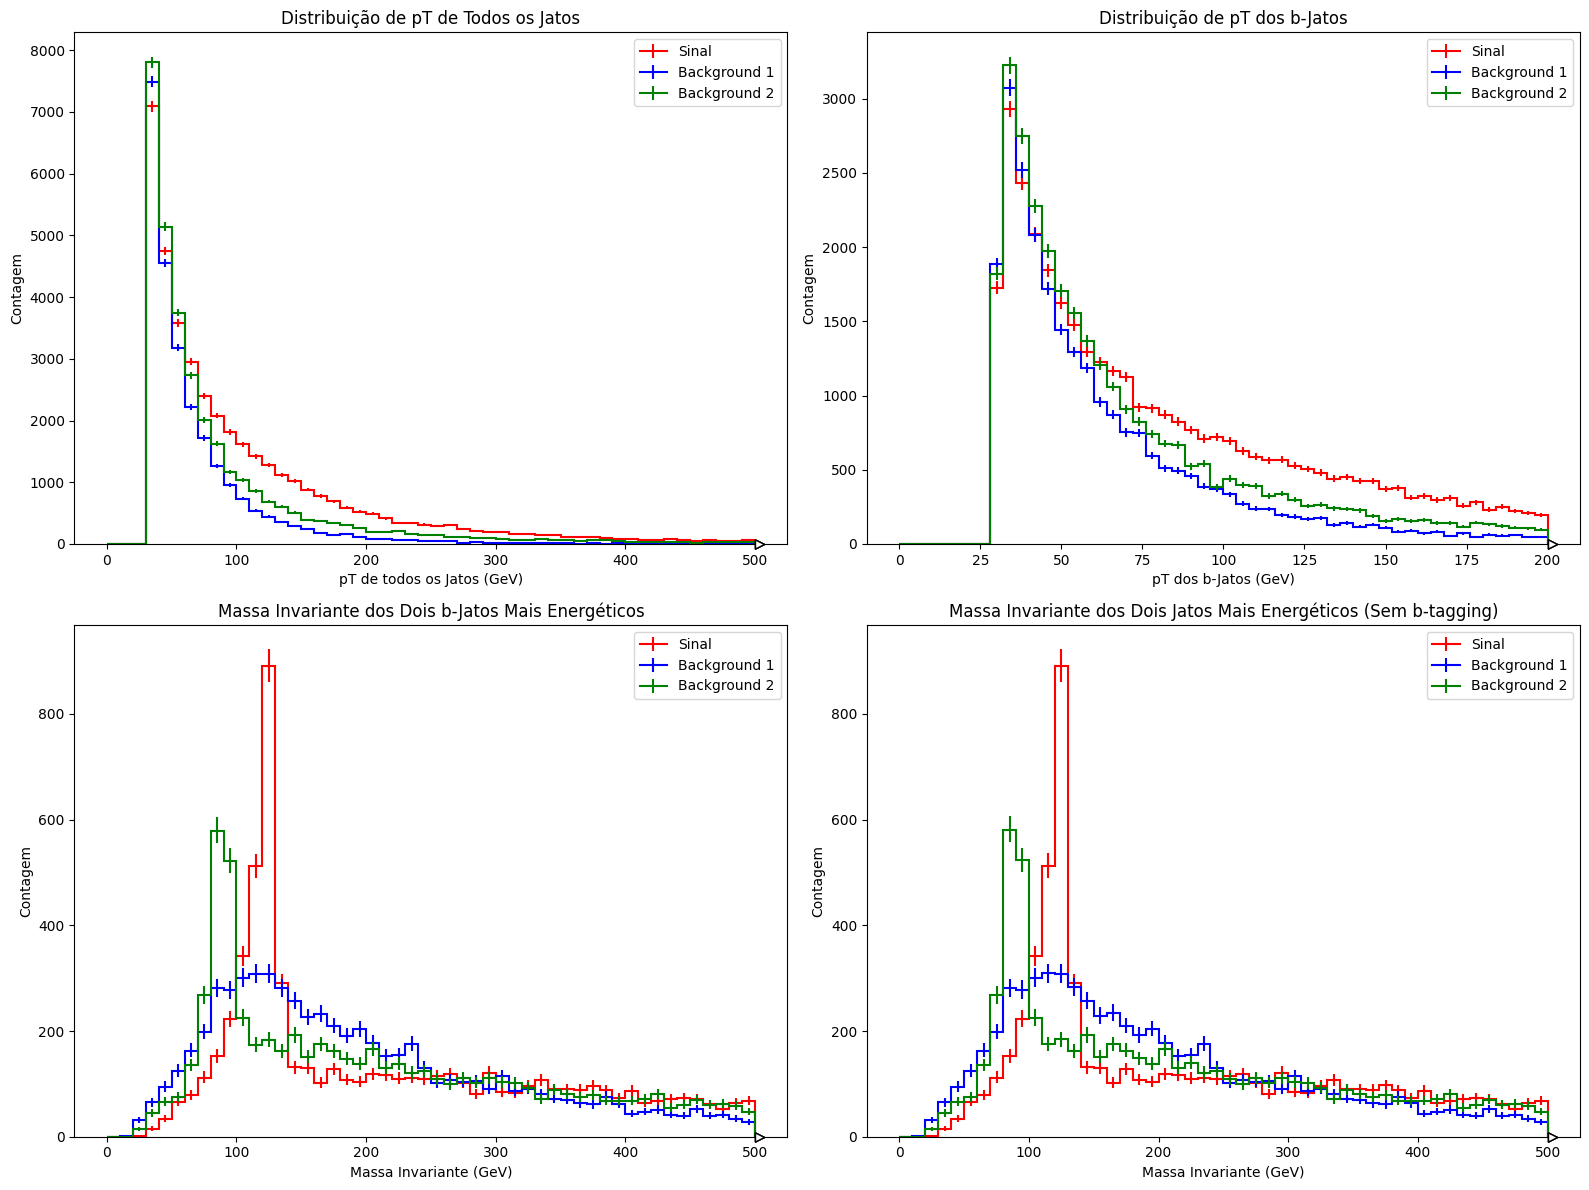

In [4]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj
import psutil
import os
import gc

# Função para verificar o uso de memória
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Limite máximo de eventos
max_events = 10000  # Total de eventos a serem processados
chunk_size = 500   # Eventos por chunk

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background_file1 = '/home/levi/Documentos/Sinal_background/background_pp_jjmumu.hepmc'
background_file2 = '/home/levi/Documentos/Sinal_background/pp_zz_background_nobornQCD.hepmc'

# Definir histogramas
histo_jets_pt_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_pt_bg1 = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_pt_bg2 = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_pt_sinal = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt_bg1 = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt_bg2 = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_mass_bg1 = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_mass_bg2 = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_bg1 = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_bg2 = hist.Hist.new.Reg(50, 0., 500.).Double()

# Função para ler eventos HEPMC em chunks
def read_hepmc_file_in_chunks(hepmc_file, max_events=max_events, chunk_size=chunk_size):
    events = []
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            events.append(event)
            if (i + 1) % chunk_size == 0:  # Processar chunk
                yield events
                events = []  # Limpar lista de eventos
                print(f"Eventos lidos: {i + 1}")
                print_memory_usage()
                gc.collect()  # Forçar liberação de memória
        if events:  # Processar eventos restantes
            yield events

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, particles, cone_radius=0.4):
    secondary_vertex_displacement = []
    for p in particles:
        if p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)
    if len(secondary_vertex_displacement) > 0:
        return np.mean(secondary_vertex_displacement) > 1.0
    return False

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para remover múons das partículas
def remove_muons(particles):
    return [p for p in particles if abs(p.pid) != 13]  # Múons têm PID ±13

# Função para processar eventos e preencher histogramas de jatos
def analyze_events(events, histo_all_jets, histo_bjets_pt, histo_bjets_mass, histo_jets_mass):
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis)
        particles = [p for p in event.particles if p.status == 1]
        
        # Remover múons das partículas
        particles_no_muons = remove_muons(particles)
        
        # Converter partículas para objetos PseudoJet do FastJet
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles_no_muons]
        
        # Definir o algoritmo de clustering (anti-kT, R = 0.4)
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        
        # Clusterizar as partículas em jatos
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        
        # Selecionar jatos com pT > 30 GeV
        jets = clusterer.inclusive_jets(30.0)
        
        # Preencher histograma de pT de todos os jatos
        for jet in jets:
            histo_all_jets.fill(jet.pt())
        
        # Filtrar jatos b-tagged
        b_jets = [jet for jet in jets if is_b_tagged(jet, particles_no_muons)]
        
        # Preencher histograma de pT dos jatos b-tagged
        for jet in b_jets:
            histo_bjets_pt.fill(jet.pt())
        
        # Selecionar os dois jatos de maior pT (b-tagged)
        if len(b_jets) >= 2:
            b_jets_sorted = sorted(b_jets, key=lambda j: j.pt(), reverse=True)  # Ordenar por pT
            b_jets_selected = b_jets_sorted[:2]
            
            # Verificar se os jatos selecionados são realmente b-tagged
            if all(is_b_tagged(jet, particles_no_muons) for jet in b_jets_selected):
                # Calcular a massa invariante dos dois jatos b-tagged selecionados
                mass = invariant_mass(b_jets_selected[0], b_jets_selected[1])
                
                # Preencher histograma da massa invariante dos jatos b-tagged
                histo_bjets_mass.fill(mass)
        
        # Selecionar os dois jatos de maior pT (sem b-tagging)
        if len(jets) >= 2:
            jets_sorted = sorted(jets, key=lambda j: j.pt(), reverse=True)  # Ordenar por pT
            jets_selected = jets_sorted[:2]
            
            # Calcular a massa invariante dos dois jatos selecionados
            mass = invariant_mass(jets_selected[0], jets_selected[1])
            
            # Preencher histograma da massa invariante dos jatos (sem b-tagging)
            histo_jets_mass.fill(mass)
        
        # Liberar memória após processar o evento
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, fj_particles, jets, b_jets  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Processar eventos de sinal em chunks
print("Processando eventos de sinal...")
for chunk in read_hepmc_file_in_chunks(sinal_file):
    analyze_events(chunk, histo_jets_pt_sinal, histo_bjets_pt_sinal, histo_bjets_mass_sinal, histo_jets_mass_sinal)

# Processar eventos de background 1 em chunks
print("\nProcessando eventos de background 1...")
for chunk in read_hepmc_file_in_chunks(background_file1):
    analyze_events(chunk, histo_jets_pt_bg1, histo_bjets_pt_bg1, histo_bjets_mass_bg1, histo_jets_mass_bg1)

# Processar eventos de background 2 em chunks
print("\nProcessando eventos de background 2...")
for chunk in read_hepmc_file_in_chunks(background_file2):
    analyze_events(chunk, histo_jets_pt_bg2, histo_bjets_pt_bg2, histo_bjets_mass_bg2, histo_jets_mass_bg2)

# Plotar histogramas
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

# Histogramas de pT de todos os jatos
histo_jets_pt_sinal.plot(ax=ax[0, 0], label='Sinal', color='red')
histo_jets_pt_bg1.plot(ax=ax[0, 0], label='Background 1', color='blue')
histo_jets_pt_bg2.plot(ax=ax[0, 0], label='Background 2', color='green')
ax[0, 0].set(xlabel='pT de todos os Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT de Todos os Jatos')
ax[0, 0].legend()

# Histogramas de pT dos jatos b-tagging
histo_bjets_pt_sinal.plot(ax=ax[0, 1], label='Sinal', color='red')
histo_bjets_pt_bg1.plot(ax=ax[0, 1], label='Background 1', color='blue')
histo_bjets_pt_bg2.plot(ax=ax[0, 1], label='Background 2', color='green')
ax[0, 1].set(xlabel='pT dos b-Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT dos b-Jatos')
ax[0, 1].legend()

# Histogramas da massa invariante dos dois b-jatos mais energéticos
histo_bjets_mass_sinal.plot(ax=ax[1, 0], label='Sinal', color='red')
histo_bjets_mass_bg1.plot(ax=ax[1, 0], label='Background 1', color='blue')
histo_bjets_mass_bg2.plot(ax=ax[1, 0], label='Background 2', color='green')
ax[1, 0].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois b-Jatos Mais Energéticos')
ax[1, 0].legend()

# Histogramas da massa invariante dos dois jatos mais energéticos (sem b-tagging)
histo_jets_mass_sinal.plot(ax=ax[1, 1], label='Sinal', color='red')
histo_jets_mass_bg1.plot(ax=ax[1, 1], label='Background 1', color='blue')
histo_jets_mass_bg2.plot(ax=ax[1, 1], label='Background 2', color='green')
ax[1, 1].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois Jatos Mais Energéticos (Sem b-tagging)')
ax[1, 1].legend()

plt.tight_layout()
plt.show()


Processando eventos de sinal...
Eventos lidos: 500
Uso de memória: 1759.54 MB
Eventos lidos: 1000
Uso de memória: 1759.54 MB
Eventos lidos: 1500
Uso de memória: 1759.54 MB
Eventos lidos: 2000
Uso de memória: 1757.91 MB
Eventos lidos: 2500
Uso de memória: 1757.91 MB
Eventos lidos: 3000
Uso de memória: 1757.91 MB
Eventos lidos: 3500
Uso de memória: 1745.63 MB
Eventos lidos: 4000
Uso de memória: 1745.63 MB
Eventos lidos: 4500
Uso de memória: 1745.63 MB
Eventos lidos: 5000
Uso de memória: 1746.66 MB
Eventos lidos: 5500
Uso de memória: 1750.27 MB
Eventos lidos: 6000
Uso de memória: 1750.53 MB
Eventos lidos: 6500
Uso de memória: 1750.79 MB
Eventos lidos: 7000
Uso de memória: 1766.51 MB
Eventos lidos: 7500
Uso de memória: 1766.51 MB
Eventos lidos: 8000
Uso de memória: 1767.54 MB
Eventos lidos: 8500
Uso de memória: 1767.54 MB
Eventos lidos: 9000
Uso de memória: 1767.80 MB
Eventos lidos: 9500
Uso de memória: 1767.80 MB
Eventos lidos: 10000
Uso de memória: 1767.80 MB

Processando eventos de back

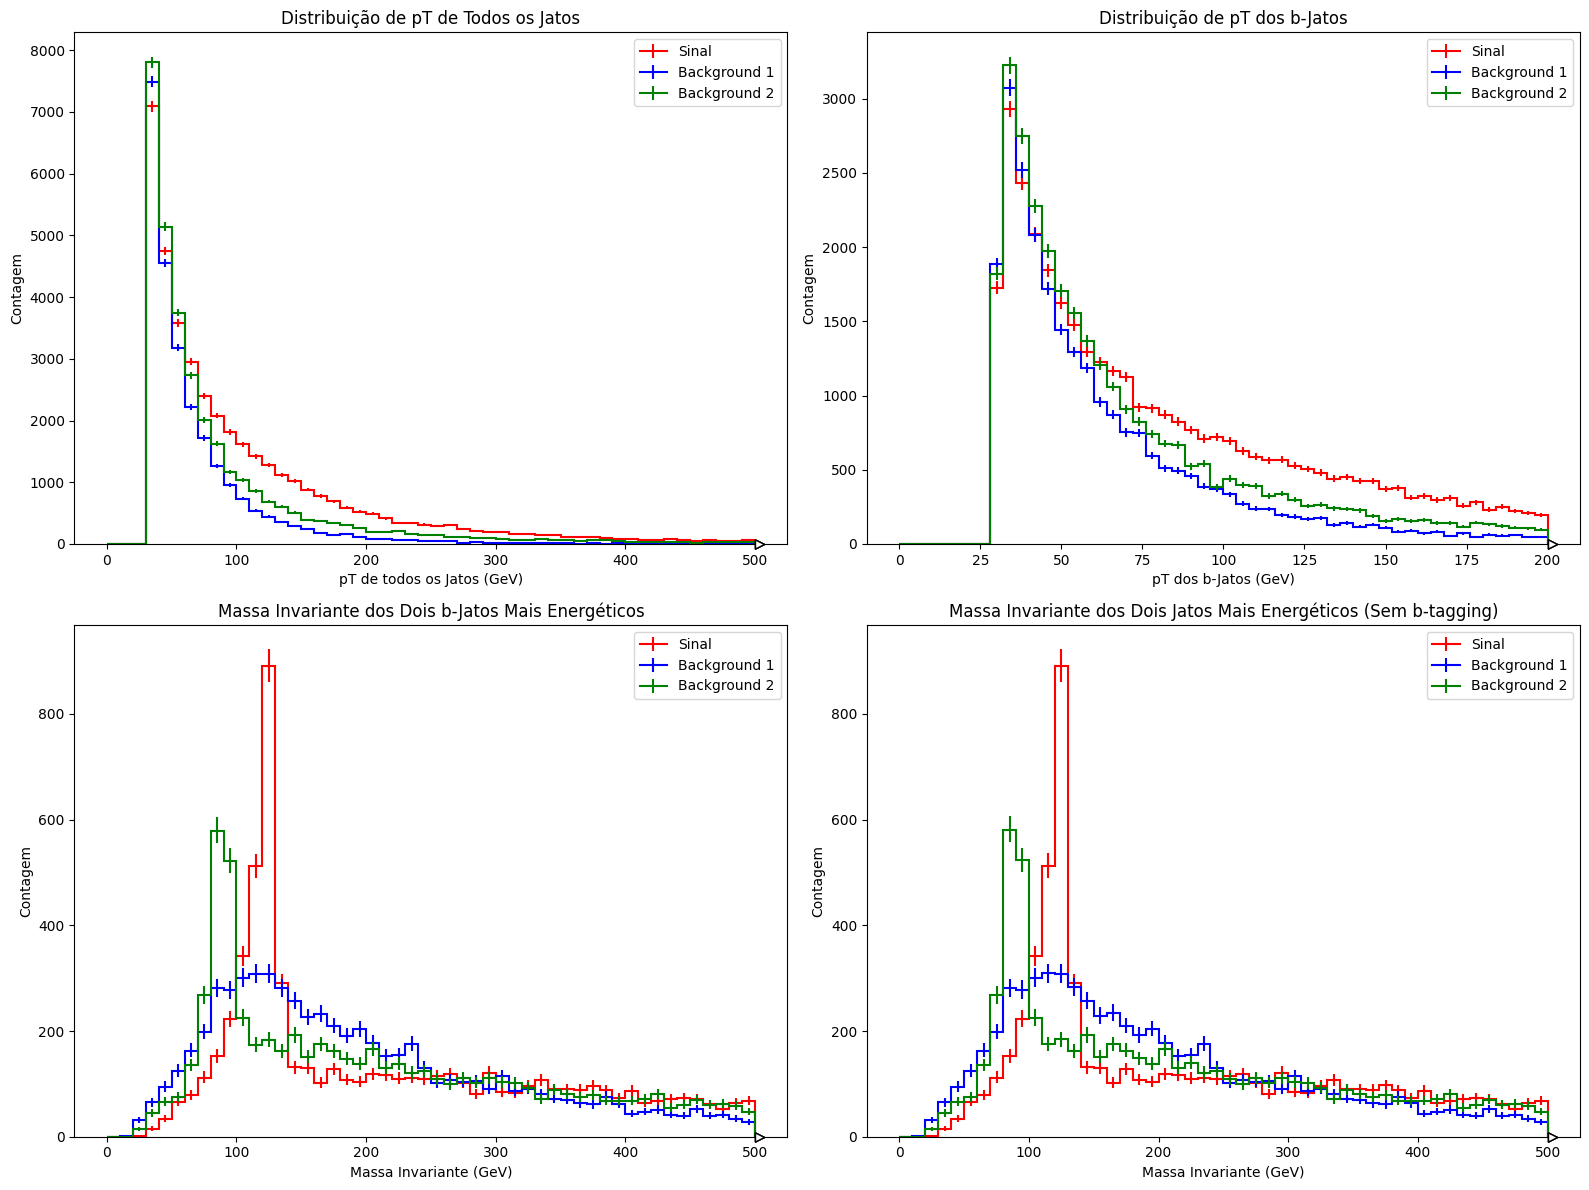

In [2]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj
import psutil
import os
import gc

# Função para verificar o uso de memória
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Limite máximo de eventos
max_events = 10000  # Total de eventos a serem processados
chunk_size = 500   # Eventos por chunk

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background_file1 = '/home/levi/Documentos/Sinal_background/background_pp_jjmumu.hepmc'
background_file2 = '/home/levi/Documentos/Sinal_background/pp_zz_background_nobornQCD.hepmc'

# Definir histogramas
histo_jets_pt_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_pt_bg1 = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_pt_bg2 = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_pt_sinal = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt_bg1 = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt_bg2 = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_mass_bg1 = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_mass_bg2 = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_bg1 = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_bg2 = hist.Hist.new.Reg(50, 0., 500.).Double()

# Função para ler eventos HEPMC em chunks
def read_hepmc_file_in_chunks(hepmc_file, max_events=max_events, chunk_size=chunk_size):
    events = []
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            events.append(event)
            if (i + 1) % chunk_size == 0:  # Processar chunk
                yield events
                events = []  # Limpar lista de eventos
                print(f"Eventos lidos: {i + 1}")
                print_memory_usage()
                gc.collect()  # Forçar liberação de memória
        if events:  # Processar eventos restantes
            yield events

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, particles, cone_radius=0.4):
    secondary_vertex_displacement = []
    for p in particles:
        if p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)
    if len(secondary_vertex_displacement) > 0:
        return np.mean(secondary_vertex_displacement) > 1.0
    return False

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para remover múons das partículas
def remove_muons(particles):
    return [p for p in particles if abs(p.pid) != 13]  # Múons têm PID ±13

# Função para processar eventos e preencher histogramas de jatos
def analyze_events(events, histo_all_jets, histo_bjets_pt, histo_bjets_mass, histo_jets_mass):
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis)
        particles = [p for p in event.particles if p.status == 1]
        
        # Remover múons das partículas
        particles_no_muons = remove_muons(particles)
        
        # Converter partículas para objetos PseudoJet do FastJet
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles_no_muons]
        
        # Definir o algoritmo de clustering (anti-kT, R = 0.4)
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        
        # Clusterizar as partículas em jatos
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        
        # Selecionar jatos com pT > 30 GeV
        jets = clusterer.inclusive_jets(30.0)
        
        # Preencher histograma de pT de todos os jatos
        for jet in jets:
            histo_all_jets.fill(jet.pt())
        
        # Filtrar jatos b-tagged
        b_jets = [jet for jet in jets if is_b_tagged(jet, particles_no_muons)]
        
        # Preencher histograma de pT dos jatos b-tagged
        for jet in b_jets:
            histo_bjets_pt.fill(jet.pt())
        
        # Selecionar os dois jatos de maior pT (b-tagged)
        if len(b_jets) >= 2:
            b_jets_sorted = sorted(b_jets, key=lambda j: j.pt(), reverse=True)  # Ordenar por pT
            b_jets_selected = b_jets_sorted[:2]
            
            # Verificar se os jatos selecionados são realmente b-tagged
            if all(is_b_tagged(jet, particles_no_muons) for jet in b_jets_selected):
                # Calcular a massa invariante dos dois jatos b-tagged selecionados
                mass = invariant_mass(b_jets_selected[0], b_jets_selected[1])
                
                # Preencher histograma da massa invariante dos jatos b-tagged
                histo_bjets_mass.fill(mass)
        
        # Selecionar os dois jatos de maior pT (sem b-tagging)
        if len(jets) >= 2:
            jets_sorted = sorted(jets, key=lambda j: j.pt(), reverse=True)  # Ordenar por pT
            jets_selected = jets_sorted[:2]
            
            # Calcular a massa invariante dos dois jatos selecionados
            mass = invariant_mass(jets_selected[0], jets_selected[1])
            
            # Preencher histograma da massa invariante dos jatos (sem b-tagging)
            histo_jets_mass.fill(mass)
        
        # Liberar memória após processar o evento
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, fj_particles, jets, b_jets  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Processar eventos de sinal em chunks
print("Processando eventos de sinal...")
for chunk in read_hepmc_file_in_chunks(sinal_file):
    analyze_events(chunk, histo_jets_pt_sinal, histo_bjets_pt_sinal, histo_bjets_mass_sinal, histo_jets_mass_sinal)

# Processar eventos de background 1 em chunks
print("\nProcessando eventos de background 1...")
for chunk in read_hepmc_file_in_chunks(background_file1):
    analyze_events(chunk, histo_jets_pt_bg1, histo_bjets_pt_bg1, histo_bjets_mass_bg1, histo_jets_mass_bg1)

# Processar eventos de background 2 em chunks
print("\nProcessando eventos de background 2...")
for chunk in read_hepmc_file_in_chunks(background_file2):
    analyze_events(chunk, histo_jets_pt_bg2, histo_bjets_pt_bg2, histo_bjets_mass_bg2, histo_jets_mass_bg2)

# Plotar histogramas
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

# Histogramas de pT de todos os jatos
histo_jets_pt_sinal.plot(ax=ax[0, 0], label='Sinal', color='red')
histo_jets_pt_bg1.plot(ax=ax[0, 0], label='Background 1', color='blue')
histo_jets_pt_bg2.plot(ax=ax[0, 0], label='Background 2', color='green')
ax[0, 0].set(xlabel='pT de todos os Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT de Todos os Jatos')
ax[0, 0].legend()

# Histogramas de pT dos jatos b-tagging
histo_bjets_pt_sinal.plot(ax=ax[0, 1], label='Sinal', color='red')
histo_bjets_pt_bg1.plot(ax=ax[0, 1], label='Background 1', color='blue')
histo_bjets_pt_bg2.plot(ax=ax[0, 1], label='Background 2', color='green')
ax[0, 1].set(xlabel='pT dos b-Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT dos b-Jatos')
ax[0, 1].legend()

# Histogramas da massa invariante dos dois b-jatos mais energéticos
histo_bjets_mass_sinal.plot(ax=ax[1, 0], label='Sinal', color='red')
histo_bjets_mass_bg1.plot(ax=ax[1, 0], label='Background 1', color='blue')
histo_bjets_mass_bg2.plot(ax=ax[1, 0], label='Background 2', color='green')
ax[1, 0].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois b-Jatos Mais Energéticos')
ax[1, 0].legend()

# Histogramas da massa invariante dos dois jatos mais energéticos (sem b-tagging)
histo_jets_mass_sinal.plot(ax=ax[1, 1], label='Sinal', color='red')
histo_jets_mass_bg1.plot(ax=ax[1, 1], label='Background 1', color='blue')
histo_jets_mass_bg2.plot(ax=ax[1, 1], label='Background 2', color='green')
ax[1, 1].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois Jatos Mais Energéticos (Sem b-tagging)')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

Eventos processados: 1000
Uso de memória: 2550.86 MB
Eventos processados: 2000
Uso de memória: 2552.62 MB
Eventos processados: 3000
Uso de memória: 2552.50 MB
Eventos processados: 4000
Uso de memória: 2552.46 MB
Eventos processados: 5000
Uso de memória: 2549.63 MB
Eventos processados: 6000
Uso de memória: 2549.32 MB
Eventos processados: 7000
Uso de memória: 2549.32 MB
Eventos processados: 8000
Uso de memória: 2549.32 MB
Eventos processados: 9000
Uso de memória: 2549.32 MB
Eventos processados: 10000
Uso de memória: 2549.32 MB
Eventos processados: 1000
Uso de memória: 2550.14 MB
Eventos processados: 2000
Uso de memória: 2549.32 MB
Eventos processados: 3000
Uso de memória: 2549.32 MB
Eventos processados: 4000
Uso de memória: 2549.32 MB
Eventos processados: 5000
Uso de memória: 2549.32 MB
Eventos processados: 6000
Uso de memória: 2549.84 MB
Eventos processados: 7000
Uso de memória: 2549.77 MB
Eventos processados: 8000
Uso de memória: 2549.70 MB
Eventos processados: 9000
Uso de memória: 254

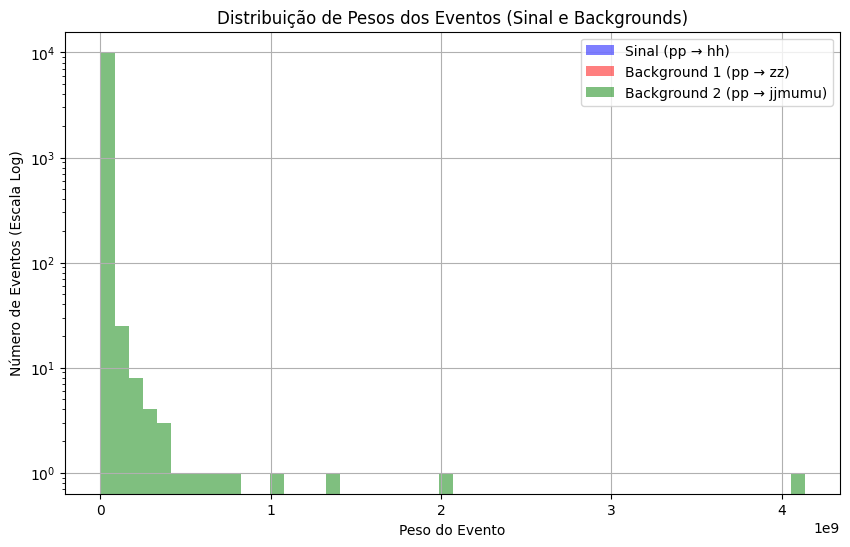

In [10]:
import pyhepmc as hep
import numpy as np
import matplotlib.pyplot as plt
import psutil
import os
import gc

# Função para verificar o uso de memória
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Limite máximo de eventos
max_events = 10000  # Total de eventos a serem processados

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background1_file = '/home/levi/Documentos/Sinal_background/pp_zz_background_nobornQCD.hepmc'
background2_file = '/home/levi/Documentos/Sinal_background/background_pp_jjmumu.hepmc'

# Luminosidade e seção de choque
luminosidade = 3000  # 3000 fb^-1
cross_section_sinal = 1.0  # Seção de choque do sinal (em pb)
cross_section_bkg1 = 1.0  # Seção de choque do background 1 (em pb)
cross_section_bkg2 = 1.0   # Seção de choque do background 2 (em pb)

# Função para calcular o peso normalizado
def calcular_peso_normalizado(event_weight, cross_section, n_gen):
    return (luminosidade * cross_section * 1e3 * event_weight) / n_gen  # 1e3 para converter de pb para fb

# Função para processar eventos
def processar_eventos(input_file, cross_section, max_events):
    weights = []
    n_gen = 0

    with hep.open(input_file) as f:
        for event in f:
            if n_gen >= max_events:
                break
            n_gen += 1

            # Peso do evento (usando o peso fornecido pelo Pythia)
            event_weight = event.weight()  # Chamar o método como uma função

            # Calcular o peso normalizado
            weight = calcular_peso_normalizado(event_weight, cross_section, n_gen)
            weights.append(weight)

            # Liberar memória após processar o evento
            if (n_gen) % 1000 == 0:
                print(f"Eventos processados: {n_gen}")
                print_memory_usage()
                del event  # Liberar memória
                gc.collect()  # Forçar liberação de memória
    return np.array(weights)

# Processar sinal e backgrounds
weights_sinal = processar_eventos(sinal_file, cross_section_sinal, max_events)
weights_bkg1 = processar_eventos(background1_file, cross_section_bkg1, max_events)
weights_bkg2 = processar_eventos(background2_file, cross_section_bkg2, max_events)

# Criar histograma com escala logarítmica no eixo y
plt.figure(figsize=(10, 6))
plt.hist(weights_sinal, bins=50, alpha=0.5, label='Sinal (pp → hh)', color='blue')
plt.hist(weights_bkg1, bins=50, alpha=0.5, label='Background 1 (pp → zz)', color='red')
plt.hist(weights_bkg2, bins=50, alpha=0.5, label='Background 2 (pp → jjmumu)', color='green')

# Configurar escala logarítmica no eixo y
plt.yscale('log')

plt.xlabel('Peso do Evento')
plt.ylabel('Número de Eventos (Escala Log)')
plt.title('Distribuição de Pesos dos Eventos (Sinal e Backgrounds)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [11]:
print("Pesos do Sinal:", weights_sinal)
print("Pesos do Background 1:", weights_bkg1)
print("Pesos do Background 2:", weights_bkg2)

Pesos do Sinal: [5.85928470e+02 2.92964235e+02 1.95309490e+02 ... 5.86045679e-02
 5.85987069e-02 5.85928470e-02]
Pesos do Background 1: [1.24670364e+06 6.23351820e+05 4.15567880e+05 ... 1.24695303e+02
 1.24682832e+02 1.24670364e+02]
Pesos do Background 2: [4.13735520e+09 2.06867760e+09 1.37911840e+09 ... 4.13818284e+05
 4.13776898e+05 4.13735520e+05]


Eventos processados: 1000
Uso de memória: 2556.24 MB
Eventos processados: 2000
Uso de memória: 2552.76 MB
Eventos processados: 3000
Uso de memória: 2550.57 MB
Eventos processados: 4000
Uso de memória: 2550.55 MB
Eventos processados: 5000
Uso de memória: 2549.46 MB
Eventos processados: 6000
Uso de memória: 2549.37 MB
Eventos processados: 7000
Uso de memória: 2549.37 MB
Eventos processados: 8000
Uso de memória: 2549.37 MB
Eventos processados: 9000
Uso de memória: 2549.37 MB
Eventos processados: 10000
Uso de memória: 2549.37 MB
Eventos processados: 1000
Uso de memória: 2550.28 MB
Eventos processados: 2000
Uso de memória: 2551.45 MB
Eventos processados: 3000
Uso de memória: 2551.41 MB
Eventos processados: 4000
Uso de memória: 2551.38 MB
Eventos processados: 5000
Uso de memória: 2550.30 MB
Eventos processados: 6000
Uso de memória: 2550.19 MB
Eventos processados: 7000
Uso de memória: 2550.19 MB
Eventos processados: 8000
Uso de memória: 2550.18 MB
Eventos processados: 9000
Uso de memória: 255

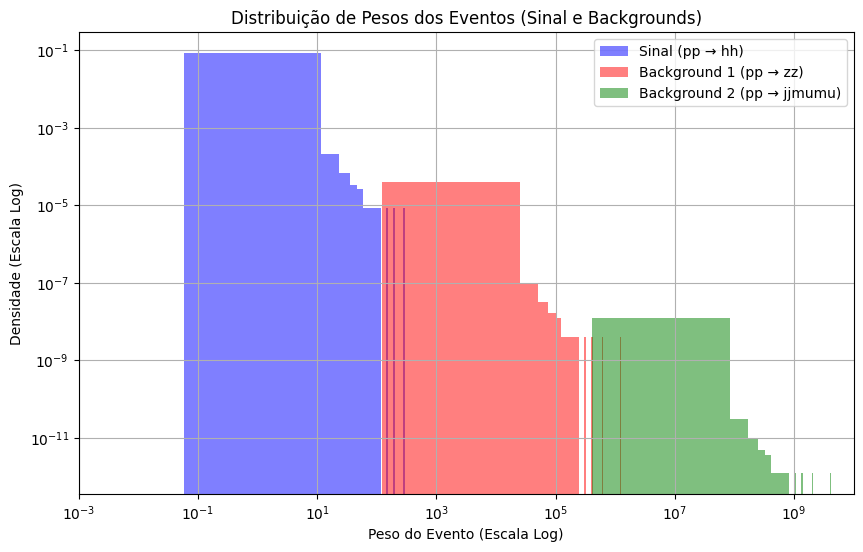

In [13]:
import pyhepmc as hep
import numpy as np
import matplotlib.pyplot as plt
import psutil
import os
import gc

# Função para verificar o uso de memória
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Limite máximo de eventos
max_events = 10000  # Total de eventos a serem processados

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background1_file = '/home/levi/Documentos/Sinal_background/pp_zz_background_nobornQCD.hepmc'
background2_file = '/home/levi/Documentos/Sinal_background/background_pp_jjmumu.hepmc'

# Luminosidade e seção de choque
luminosidade = 3000  # 3000 fb^-1
cross_section_sinal = 1.0  # Seção de choque do sinal (em pb)
cross_section_bkg1 = 10.0  # Seção de choque do background 1 (em pb)
cross_section_bkg2 = 5.0   # Seção de choque do background 2 (em pb)

# Função para calcular o peso normalizado
def calcular_peso_normalizado(event_weight, cross_section, n_gen):
    return (luminosidade * cross_section * 1e3 * event_weight) / n_gen  # 1e3 para converter de pb para fb

# Função para processar eventos
def processar_eventos(input_file, cross_section, max_events):
    weights = []
    n_gen = 0

    with hep.open(input_file) as f:
        for event in f:
            if n_gen >= max_events:
                break
            n_gen += 1

            # Peso do evento (usando o peso fornecido pelo Pythia)
            event_weight = event.weight()  # Chamar o método como uma função

            # Calcular o peso normalizado
            weight = calcular_peso_normalizado(event_weight, cross_section, n_gen)
            weights.append(weight)

            # Liberar memória após processar o evento
            if (n_gen) % 1000 == 0:
                print(f"Eventos processados: {n_gen}")
                print_memory_usage()
                del event  # Liberar memória
                gc.collect()  # Forçar liberação de memória

    return np.array(weights)

# Processar sinal e backgrounds
weights_sinal = processar_eventos(sinal_file, cross_section_sinal, max_events)
weights_bkg1 = processar_eventos(background1_file, cross_section_bkg1, max_events)
weights_bkg2 = processar_eventos(background2_file, cross_section_bkg2, max_events)

# Verificar os pesos e o número de eventos
print("Pesos do Sinal:", weights_sinal)
print("Pesos do Background 1:", weights_bkg1)
print("Pesos do Background 2:", weights_bkg2)

print(f"Número de eventos do sinal: {len(weights_sinal)}")
print(f"Número de eventos do background 1: {len(weights_bkg1)}")
print(f"Número de eventos do background 2: {len(weights_bkg2)}")

# Criar histograma com escala logarítmica nos eixos x e y
plt.figure(figsize=(10, 6))

# Histograma do sinal
plt.hist(weights_sinal, bins=50, alpha=0.5, label='Sinal (pp → hh)', color='blue', density=True)

# Histograma do background 1
plt.hist(weights_bkg1, bins=50, alpha=0.5, label='Background 1 (pp → zz)', color='red', density=True)

# Histograma do background 2
plt.hist(weights_bkg2, bins=50, alpha=0.5, label='Background 2 (pp → jjmumu)', color='green', density=True)

# Configurar escalas logarítmicas nos eixos x e y
plt.xscale('log')
plt.yscale('log')

# Ajustar limites do eixo x (se necessário)
plt.xlim(1e-3, 1e10)  # Ajuste conforme os dados

# Rótulos e título
plt.xlabel('Peso do Evento (Escala Log)')
plt.ylabel('Densidade (Escala Log)')
plt.title('Distribuição de Pesos dos Eventos (Sinal e Backgrounds)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

Eventos processados: 1000
Uso de memória: 2567.78 MB
Eventos processados: 2000
Uso de memória: 2567.46 MB
Eventos processados: 3000
Uso de memória: 2564.52 MB
Eventos processados: 4000
Uso de memória: 2564.39 MB
Eventos processados: 5000
Uso de memória: 2564.29 MB
Eventos processados: 6000
Uso de memória: 2564.20 MB
Eventos processados: 7000
Uso de memória: 2564.20 MB
Eventos processados: 8000
Uso de memória: 2564.10 MB
Eventos processados: 9000
Uso de memória: 2564.07 MB
Eventos processados: 10000
Uso de memória: 2564.07 MB
Eventos processados: 1000
Uso de memória: 2565.64 MB
Eventos processados: 2000
Uso de memória: 2565.43 MB
Eventos processados: 3000
Uso de memória: 2565.29 MB
Eventos processados: 4000
Uso de memória: 2564.17 MB
Eventos processados: 5000
Uso de memória: 2564.12 MB
Eventos processados: 6000
Uso de memória: 2564.02 MB
Eventos processados: 7000
Uso de memória: 2564.02 MB
Eventos processados: 8000
Uso de memória: 2564.02 MB
Eventos processados: 9000
Uso de memória: 256

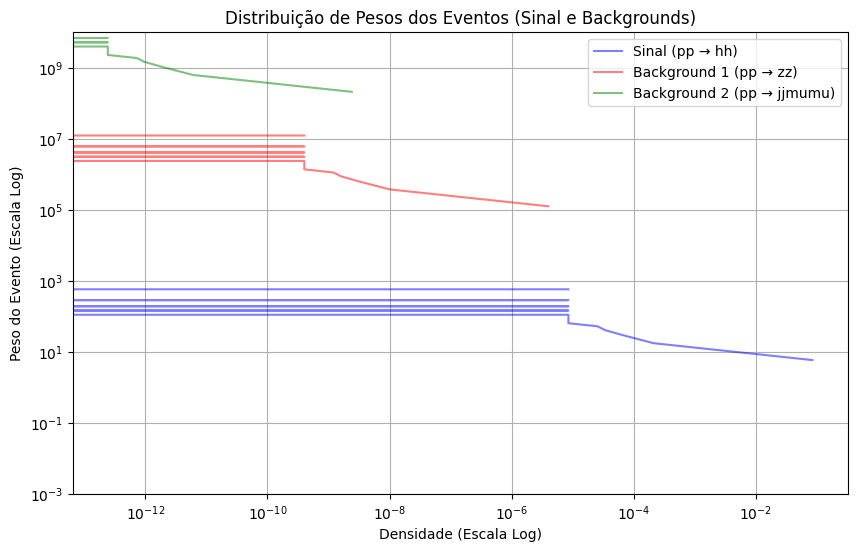

In [16]:
import pyhepmc as hep
import numpy as np
import matplotlib.pyplot as plt
import psutil
import os
import gc

# Função para verificar o uso de memória
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Limite máximo de eventos
max_events = 10000  # Total de eventos a serem processados

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background1_file = '/home/levi/Documentos/Sinal_background/pp_zz_background_nobornQCD.hepmc'
background2_file = '/home/levi/Documentos/Sinal_background/background_pp_jjmumu.hepmc'

# Luminosidade e seção de choque
luminosidade = 3000  # 3000 fb^-1
cross_section_sinal = 1.0  # Seção de choque do sinal (em pb)
cross_section_bkg1 = 10.0  # Seção de choque do background 1 (em pb)
cross_section_bkg2 = 5.0   # Seção de choque do background 2 (em pb)

# Função para calcular o peso normalizado
def calcular_peso_normalizado(event_weight, cross_section, n_gen):
    return (luminosidade * cross_section * 1e3 * event_weight) / n_gen  # 1e3 para converter de pb para fb

# Função para processar eventos
def processar_eventos(input_file, cross_section, max_events):
    weights = []
    n_gen = 0

    with hep.open(input_file) as f:
        for event in f:
            if n_gen >= max_events:
                break
            n_gen += 1

            # Peso do evento (usando o peso fornecido pelo Pythia)
            event_weight = event.weight()  # Chamar o método como uma função

            # Calcular o peso normalizado
            weight = calcular_peso_normalizado(event_weight, cross_section, n_gen)
            weights.append(weight)

            # Liberar memória após processar o evento
            if (n_gen) % 1000 == 0:
                print(f"Eventos processados: {n_gen}")
                print_memory_usage()
                del event  # Liberar memória
                gc.collect()  # Forçar liberação de memória

    return np.array(weights)

# Processar sinal e backgrounds
weights_sinal = processar_eventos(sinal_file, cross_section_sinal, max_events)
weights_bkg1 = processar_eventos(background1_file, cross_section_bkg1, max_events)
weights_bkg2 = processar_eventos(background2_file, cross_section_bkg2, max_events)

# Verificar os pesos e o número de eventos
print("Pesos do Sinal:", weights_sinal)
print("Pesos do Background 1:", weights_bkg1)
print("Pesos do Background 2:", weights_bkg2)

print(f"Número de eventos do sinal: {len(weights_sinal)}")
print(f"Número de eventos do background 1: {len(weights_bkg1)}")
print(f"Número de eventos do background 2: {len(weights_bkg2)}")

# Criar histograma com escala logarítmica nos eixos x e y
plt.figure(figsize=(10, 6))

# Calcular histogramas manualmente
counts_sinal, bin_edges_sinal = np.histogram(weights_sinal, bins=50, density=True)
counts_bkg1, bin_edges_bkg1 = np.histogram(weights_bkg1, bins=50, density=True)
counts_bkg2, bin_edges_bkg2 = np.histogram(weights_bkg2, bins=50, density=True)

# Trocar eixos x e y: densidade no eixo x, pesos no eixo y
plt.plot(counts_sinal, (bin_edges_sinal[:-1] + bin_edges_sinal[1:]) / 2, alpha=0.5, label='Sinal (pp → hh)', color='blue')
plt.plot(counts_bkg1, (bin_edges_bkg1[:-1] + bin_edges_bkg1[1:]) / 2, alpha=0.5, label='Background 1 (pp → zz)', color='red')
plt.plot(counts_bkg2, (bin_edges_bkg2[:-1] + bin_edges_bkg2[1:]) / 2, alpha=0.5, label='Background 2 (pp → jjmumu)', color='green')

# Configurar escalas logarítmicas nos eixos x e y
plt.xscale('log')
plt.yscale('log')

# Ajustar limites do eixo y (que agora é o eixo dos pesos)
plt.ylim(1e-3, 1e10)  # Ajuste conforme os dados

# Rótulos e título
plt.xlabel('Densidade (Escala Log)')  # Agora o eixo x representa a densidade
plt.ylabel('Peso do Evento (Escala Log)')  # Agora o eixo y representa os pesos
plt.title('Distribuição de Pesos dos Eventos (Sinal e Backgrounds)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

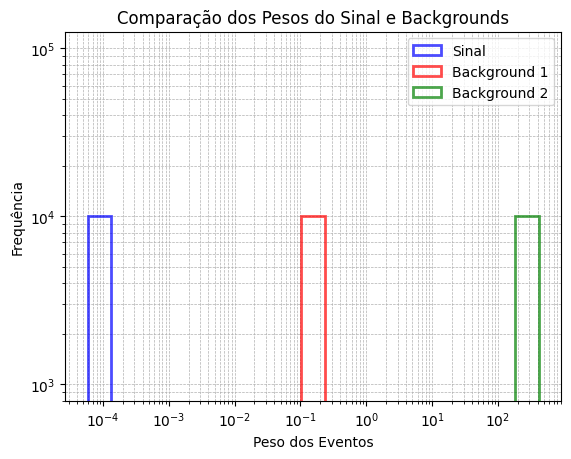

Uso de memória: 2591.45 MB


31618

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import hist
import psutil
import os
import gc
import pyhepmc as hep

# Função para verificar o uso de memória
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Limite máximo de eventos
max_events = 10000  # Total de eventos a serem processados
chunk_size = 500   # Eventos por chunk

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background_file1 = '/home/levi/Documentos/Sinal_background/pp_zz_background_nobornQCD.hepmc'
background_file2 = '/home/levi/Documentos/Sinal_background/background_pp_jjmumu.hepmc'

# Luminosidade para a análise (em fb^-1)
lumi = 3000  # 3000 fb^-1

# Função para extrair pesos dos eventos
def extrair_pesos(arquivo):
    pesos = []
    with hep.open(arquivo) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            pesos.append(event.weights[0])  # Supondo que o peso relevante está na primeira posição
    return np.array(pesos)

# Extração dos pesos reais dos arquivos HepMC
pesos_sinal = extrair_pesos(sinal_file)
pesos_bkg1 = extrair_pesos(background_file1)
pesos_bkg2 = extrair_pesos(background_file2)

# Número de eventos gerados em Monte Carlo
N_gen_sinal = len(pesos_sinal)
N_gen_bkg1 = len(pesos_bkg1)
N_gen_bkg2 = len(pesos_bkg2)

# Cálculo dos pesos normalizados
w_sinal = (lumi * pesos_sinal) / N_gen_sinal
w_bkg1 = (lumi * pesos_bkg1) / N_gen_bkg1
w_bkg2 = (lumi * pesos_bkg2) / N_gen_bkg2

# Criar histograma
bins = np.logspace(np.log10(min(w_sinal.min(), w_bkg1.min(), w_bkg2.min())),
                   np.log10(max(w_sinal.max(), w_bkg1.max(), w_bkg2.max())), 20)

plt.hist(w_sinal, bins=bins, alpha=0.7, label='Sinal', color='blue', histtype='step', linewidth=2)
plt.hist(w_bkg1, bins=bins, alpha=0.7, label='Background 1', color='red', histtype='step', linewidth=2)
plt.hist(w_bkg2, bins=bins, alpha=0.7, label='Background 2', color='green', histtype='step', linewidth=2)

# Configurações do gráfico
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Peso dos Eventos')
plt.ylabel('Frequência')
plt.legend()
plt.title('Comparação dos Pesos do Sinal e Backgrounds')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Mostrar o histograma
plt.show()

# Liberar memória após processar os eventos
print_memory_usage()
gc.collect()
